

















# **Pruning and Sparsing**





This colab notebook provides code and a framework for ***Pruning and sparsing***.



# **Setup**

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


The system cannot find the path specified.


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

from torch.utils.data import Dataset

import os
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader,random_split,Subset,TensorDataset
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
from torch.utils.data import ConcatDataset
import torchvision.models as models
import torchvision
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score


assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [5]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [ ]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

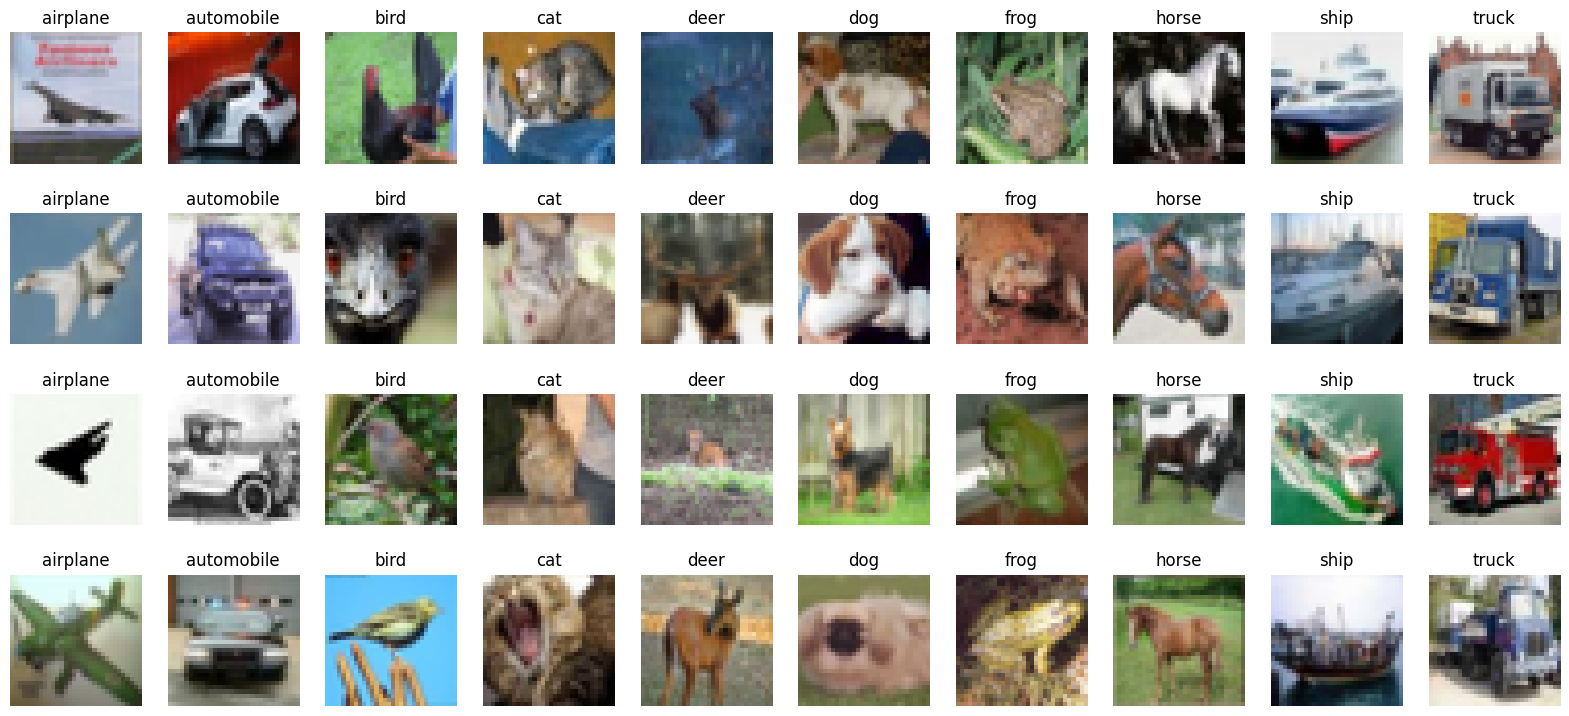

In [6]:

samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

In [7]:
# import shutil
# from sklearn.model_selection import train_test_split

# # Function to split data
# def split_data(source_dir, train_subdir, test_subdir, val_subdir, test_size=0.1, val_size=0.2):
#     # Get list of all files in the source directory
#     files = os.listdir(source_dir)

#     # Split files into training and testing sets
#     train_files, test_files = train_test_split(files, test_size=test_size+val_size, random_state=42)
#     test_files, val_files = train_test_split(test_files, test_size=val_size/(val_size+test_size), random_state=42)

#     # Move files to train and test directories
#     for file in train_files:
#         shutil.move(os.path.join(source_dir, file), os.path.join(train_subdir, file))

#     for file in test_files:
#         shutil.move(os.path.join(source_dir, file), os.path.join(test_subdir, file))

#     for file in val_files:
#         shutil.move(os.path.join(source_dir, file), os.path.join(val_subdir, file))



# # Define paths
# base_dir = '/content/drive/MyDrive/Papers/PhD/Colab/dataset_cancer_v1/classificacao_binaria/'

# sub_dirs=['400X','200X','100X','40X']

# for m in sub_dirs:
#   b_dir=os.path.join(base_dir,m)
#   train_dir = os.path.join(b_dir, 'train')
#   test_dir = os.path.join(b_dir, 'test')
#   val_dir = os.path.join(b_dir, 'val')

#   # Create train and test directories
#   os.makedirs(os.path.join(train_dir, 'benign'), exist_ok=True)
#   os.makedirs(os.path.join(test_dir, 'benign'), exist_ok=True)
#   os.makedirs(os.path.join(val_dir, 'benign'), exist_ok=True)
#   os.makedirs(os.path.join(train_dir, 'malignant'), exist_ok=True)
#   os.makedirs(os.path.join(test_dir, 'malignant'), exist_ok=True)
#   os.makedirs(os.path.join(val_dir, 'malignant'), exist_ok=True)

#   # Split benign data
#   split_data(os.path.join(b_dir, 'benign'), os.path.join(train_dir, 'benign'), os.path.join(test_dir, 'benign'), os.path.join(val_dir, 'benign'))

#   # Split malignant data
#   split_data(os.path.join(b_dir, 'malignant'), os.path.join(train_dir, 'malignant'), os.path.join(test_dir, 'malignant'), os.path.join(val_dir, 'malignant'))

# print("Data split into training and testing sets.")

In [8]:
# # Reaccumulate the images

# base_dir = 'H:\sutanu\BreaKHis\BreaKHis_v2\'

# sub_dirs=['400X','200X','100X','40X']


# for m in sub_dirs:
#   b_dir=os.path.join(base_dir,m)
#   benign_dir = os.path.join(b_dir, 'benign')
#   malignant_dir = os.path.join(b_dir, 'malignant')

#   train_dir_b = os.path.join(b_dir, 'train','benign')
#   train_dir_m = os.path.join(b_dir, 'train','malignant')

#   files_b = os.listdir(train_dir_b)
#   files_m = os.listdir(train_dir_m)

#   # merging benign data
#   for file in files_b:
#     shutil.move( os.path.join(train_dir_b, file),benign_dir)

#   # merging malignant data
#   for file in files_m:
#     shutil.move(os.path.join(train_dir_m, file), malignant_dir)

#   test_dir_b = os.path.join(b_dir, 'test','benign')
#   test_dir_m = os.path.join(b_dir, 'test','malignant')

#   files_b = os.listdir(test_dir_b)
#   files_m = os.listdir(test_dir_m)

#   # merging benign data
#   for file in files_b:
#     shutil.move( os.path.join(test_dir_b, file), benign_dir)

#   # merging malignant data
#   for file in files_m:
#     shutil.move(os.path.join(test_dir_m, file), malignant_dir)


#   val_dir_b = os.path.join(b_dir, 'val','benign')
#   val_dir_m = os.path.join(b_dir, 'val','malignant')

#   files_b = os.listdir(val_dir_b)
#   files_m = os.listdir(val_dir_m)

#   # merging benign data
#   for file in files_b:
#     shutil.move( os.path.join(val_dir_b, file), benign_dir)

#   # merging malignant data
#   for file in files_m:
#     shutil.move(os.path.join(val_dir_m, file), malignant_dir)

# print("Data merge into benign and maignant sets.")

In [9]:
magf='400X'


path='H:\sutanu\BreaKHis\BreaKHis_v2'
sub_dirs=['400X','200X','100X','40X']
types=['train','test']

image_size = 224
train_transform = Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        # Grayscale(num_output_channels=1),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])
# # Define separate transforms
# train_transform = Compose([
#     transforms.Resize((80, 80)),  
#     transforms.RandomRotation(20),  
#     transforms.RandomAffine(degrees=0, shear=20),  
#     transforms.RandomHorizontalFlip(p=0.5),  
#     transforms.RandomVerticalFlip(p=0.5),  
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
#     transforms.ToTensor(),  
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
# ])

test_transform = Compose([
    ToTensor(),  
])

dataset={}
dataloader={}

root_dir,image_dataset={},{}
for d in sub_dirs:
    root_dir[d]=os.path.join(path, d)

    # Load dataset
    image_dataset[d] = ImageFolder(root=root_dir[d])

    # Define split sizes
    train_test_val_pecentage=[0.80, 0.20]
    
    test_size = int(train_test_val_pecentage[1]* len(image_dataset[d]))   # 80% for training
    train_size = len(image_dataset[d]) - test_size                        # Remaining 20%
        
    train_indices, test_indices = random_split(image_dataset[d], [train_size, test_size])

    # Create separate datasets with different transforms
    train_dataset = ImageFolder(root=root_dir[d], transform=train_transform)  
    test_dataset = ImageFolder(root=root_dir[d], transform=test_transform)  

    dataset[d]={}

    # Apply the split indices
    dataset[d] = {
    "train": torch.utils.data.Subset(train_dataset, train_indices.indices),
    "test": torch.utils.data.Subset(test_dataset, test_indices.indices),
    }

    dataloader[d]={}
    # Create DataLoaders
    batch_size = 32
    dataloader[d] = {
    "train": DataLoader(dataset[d]["train"], batch_size=batch_size, shuffle=True),
    "test": DataLoader(dataset[d]["test"], batch_size=batch_size, shuffle=False)
    }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.897759..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.265406..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44257697..2.5528543].


{'400X': {'train': <torch.utils.data.dataset.Subset object at 0x000001B64DFDD2B0>, 'test': <torch.utils.data.dataset.Subset object at 0x000001B64E01FE20>}, '200X': {'train': <torch.utils.data.dataset.Subset object at 0x000001B64DFD0B80>, 'test': <torch.utils.data.dataset.Subset object at 0x000001B64E0205E0>}, '100X': {'train': <torch.utils.data.dataset.Subset object at 0x000001B64E0204F0>, 'test': <torch.utils.data.dataset.Subset object at 0x000001B64E020250>}, '40X': {'train': <torch.utils.data.dataset.Subset object at 0x000001B64E01BFD0>, 'test': <torch.utils.data.dataset.Subset object at 0x000001B64DFD4760>}}
Magnification:400X, Type:train, size: torch.Size([3, 224, 224])
Magnification:400X, Type:test, size: torch.Size([3, 460, 700])
Magnification:200X, Type:train, size: torch.Size([3, 224, 224])
Magnification:200X, Type:test, size: torch.Size([3, 460, 700])
Magnification:100X, Type:train, size: torch.Size([3, 224, 224])
Magnification:100X, Type:test, size: torch.Size([3, 460, 700])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057422955..2.3611329].


Magnification:40X, Type:train, size: torch.Size([3, 224, 224])
Magnification:40X, Type:test, size: torch.Size([3, 460, 700])


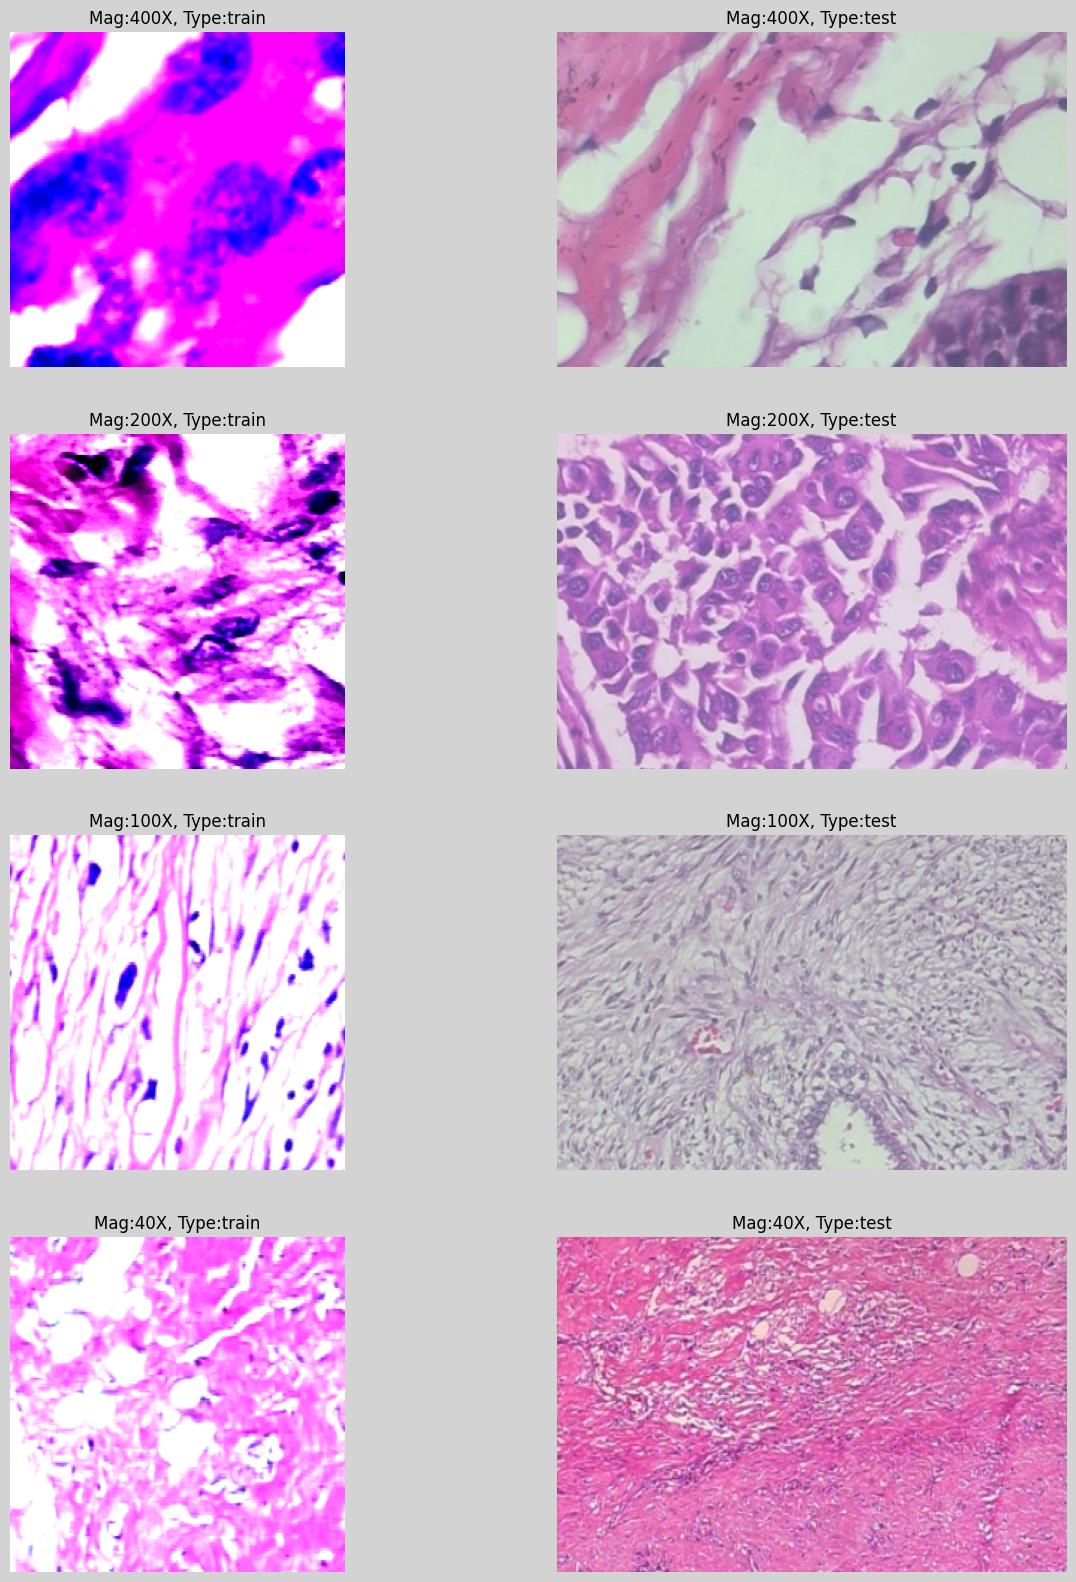

In [11]:
for d in sub_dirs:
    root_dir[d]=os.path.join(path, d)
print(dataset)
width=2
fig, ax = plt.subplots(4, width, figsize=(15, 20))
fig.set_facecolor('lightgrey')
i,j=0,0

for d in sub_dirs:
    j=0
    for t in types:
        image=dataset[d][t][0][0]
        print(f"Magnification:{d}, Type:{t}, size: {image.shape}")
        ax[i,j].imshow(image.permute(1, 2, 0),cmap='gray')
        ax[i,j].set_title(f"Mag:{d}, Type:{t}")
        ax[i,j].axis("off")
        j=j+1
    i=i+1
plt.show()


In [14]:
for image, label in dataloader['40X']["train"]:
  print("[image] , shape: {}".format(image.shape))
  print("[label] , shape: {}".format(label.shape))
  break

[image] , shape: torch.Size([32, 3, 224, 224])
[label] , shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24999997..2.64].


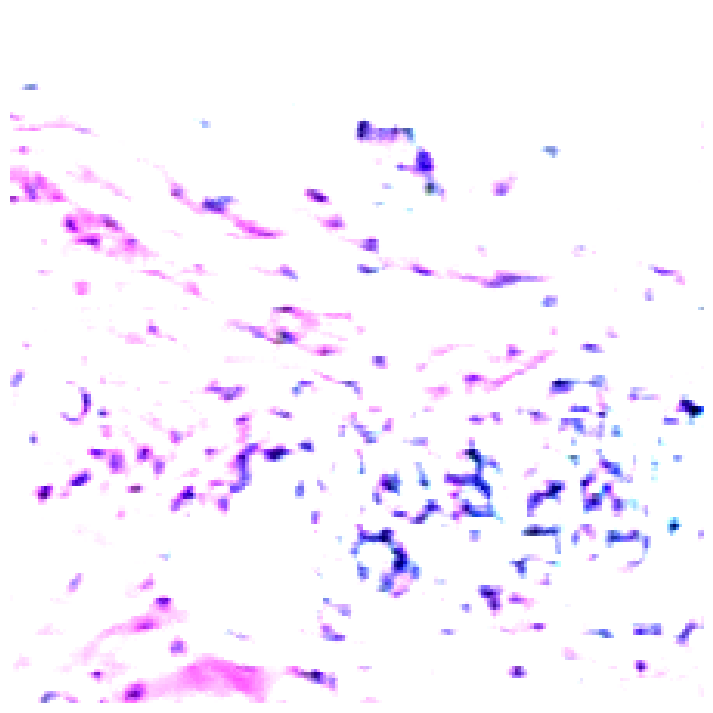

In [15]:
i=random.randint(0,len(image))
img=image[i]
plt.figure(figsize=(20, 9))

# 3. Display the image
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis('off')  # Turn off axis labels
plt.show()


class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
  # ARCH = [32 , 32, 'M', 64, 64,'M',128, 128, 'M', 256, 256, 'M', 512, 512]

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
#    self.fc1 = nn.Linear(2024, 500)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
#    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = VGG().cuda()

In [16]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
  # ARCH = [32 , 32, 'M', 64, 64,'M',128, 128, 'M', 256, 256, 'M', 512, 512]

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
#    self.fc1 = nn.Linear(2024, 500)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
#    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = VGG().cuda()

In [ ]:
## import torch
import torch.nn as nn

# Define the basic block for ResNet (used in ResNet-18 and ResNet-34)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the bottleneck block for ResNet (used in ResNet-50 and above)
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU(inplace=True)(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.ReLU(inplace=True)(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = nn.ReLU(inplace=True)(out)

        return out

# Define the ResNet model
class MyResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, trim_percentages=None):
        super(MyResNet, self).__init__()
        if trim_percentages is not None:
            assert len(trim_percentages) == sum(layers)+1, "Invalid trim_percentages"
            self.trim_percentages = trim_percentages
        else:
            self.trim_percentages = [1] * (sum(layers)+1)

        self.in_channels = round(64*self.trim_percentages[0])
        self.conv1 = nn.Conv2d(3, round(64*self.trim_percentages[0]), kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(round(64*self.trim_percentages[0]))
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        start_ind=1
        end_ind=start_ind+layers[0]
        self.layer1 = self._make_layer(block, 64, layers[0],trim_percentages=self.trim_percentages[start_ind:end_ind])
        start_ind=end_ind
        end_ind=start_ind+layers[1]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,trim_percentages=self.trim_percentages[start_ind:end_ind])
        start_ind=end_ind
        end_ind=start_ind+layers[2]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,trim_percentages=self.trim_percentages[start_ind:end_ind])
        start_ind=end_ind
        end_ind=start_ind+layers[3]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,trim_percentages=self.trim_percentages[start_ind:end_ind])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear( round(512 * block.expansion*self.trim_percentages[-1]), num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1,trim_percentages=None):
        if trim_percentages is None:
            trim_percentages=[1]*block
        downsample = None
        if stride != 1 or self.in_channels != round(out_channels * block.expansion * trim_percentages[0]):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, round(out_channels * block.expansion * trim_percentages[0]), kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(round(out_channels * block.expansion * trim_percentages[0])),
            )
        layers = []
        layers.append(block(self.in_channels, round(out_channels*trim_percentages[0]), stride, downsample))
        self.in_channels = round(out_channels * block.expansion*trim_percentages[0])

        for i in range(1, blocks):
            downsample=None
            if stride != 1 or self.in_channels != round(out_channels * block.expansion * trim_percentages[i]):
                downsample = nn.Sequential(
                        nn.Conv2d(self.in_channels, round(out_channels * block.expansion * trim_percentages[i]), kernel_size=1, bias=False),
                        nn.BatchNorm2d(round(out_channels * block.expansion * trim_percentages[i])),
                    )

            layers.append(block(self.in_channels, round(out_channels*trim_percentages[i]),downsample=downsample))
            self.in_channels = round(out_channels * block.expansion*trim_percentages[i])

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Define functions to create different ResNet models
def Myresnet18(num_classes=1000,trim_percentages=None):
    return MyResNet(BasicBlock, [2, 2, 2, 2], num_classes,trim_percentages).cuda()

def Myresnet34(num_classes=1000,trim_percentages=None):
    return MyResNet(BasicBlock, [3, 4, 6, 3], num_classes,trim_percentages).cuda()

def Myresnet50(num_classes=1000,trim_percentages=None):
    return MyResNet(Bottleneck, [3, 4, 6, 3], num_classes,trim_percentages).cuda()

def Myresnet101(num_classes=1000,trim_percentages=None):
    return MyResNet(Bottleneck, [3, 4, 23, 3], num_classes,trim_percentages).cuda()

def Myresnet152(num_classes=1000,trim_percentages=None):
    return MyResNet(Bottleneck, [3, 8, 36, 3], num_classes,trim_percentages).cuda()



In [17]:
# model = models.mobilenet_v2(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)


# model = Myresnet152()
# model.fc = torch.nn.Linear(model.fc.in_features, 2)  # num_classes is the number of output classes

model = VGG()
# Freeze the feature layers by setting requires_grad=False

# Replace the final layer (fully connected) to fit your dataset

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  epoch=0,
  callbacks = None
) -> float:
  model.train()
  total_loss = 0
  for inputs, targets in tqdm(dataloader, desc=f'train epoch:{epoch}', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)

    loss = criterion(outputs, targets)
    total_loss += loss.item()


    # Backward propagation
    loss.backward()
    # Update optimizer and LR scheduler
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  return total_loss/len(dataloader)


In [20]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  criterion =None,
  verbose=True,
) :
  model.eval()
  total_loss = float(0)
  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs1 = model(inputs)

    # Convert logits to class indices
    outputs = outputs1.argmax(dim=1)

    # Calculate loss
    if criterion is not None:
      loss = criterion(outputs1, targets)
      total_loss += loss.item()


    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item(), total_loss/len(dataloader)

Helper Functions (Flops, Model Size calculation, etc.)

---
* The computation cost can be estimated by the number of [multiply–accumulate operations (MACs)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation) using [TorchProfile](https://github.com/zhijian-liu/torchprofile):


In [21]:

def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

# We can train the model directly


*As* we are working on a classification problem, we will apply [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function to optimize the model:

In [22]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using [stochastic gradient descent (SGD) or ADAM]
1. 40X: lr:0.0001 m:0.9
2. 100X: lr:0.001 to 0.0001 m:0.9
3. 200X: lr:0.0001 m:0.9
4. 400X: lr:0.0001 m:0.9





In [23]:
# optimizer = Adam(
#   model.parameters(),
#   lr=0.0001,
#   betas=(0.9, 0.999),
#   eps=1e-08,
#   weight_decay=0.0
# )

optimizer = SGD(
  model.parameters(),
  lr=0.0001,
  momentum=0.9,
  weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler (which is adapted from [this blog series](https://myrtle.ai/learn/how-to-train-your-resnet/)):

In [26]:
num_epochs = 20
steps_per_epoch = len(dataloader["train"][magf])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.0001, num_epochs],
  [0, 1, 0]
)[0]

lambda_lr = lambda x:30*( 0.333 ** (x // 10))

# Visualize the learning rate schedule
steps = np.arange(num_epochs)
plt.plot(steps, [lambda_lr(step)  for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lambda_lr)

KeyError: 'train'

With training and evaluation functions, we can finally start training the model! This will take around 10 minutes.

In [24]:
torch.cuda.empty_cache()

In [24]:
scheduler.get_last_lr()

[0.003]

In [25]:
losses, val_losses,test_losses, accs = [], [],[], []

In [28]:
best_acc=0
best_model=None
for epoch_num in tqdm(range(1, num_epochs + 1)):
  loss=train(model, dataloader["train"], criterion, optimizer, epoch=epoch_num)
  acc, val_loss = evaluate(model, dataloader["val"], criterion)
  if test_size > 0:
    test_acc, test_loss = evaluate(model, dataloader["test"], criterion)
    print(f"Training Loss: {loss:.6f}. ,Validation Loss: {val_loss:.4f},Test Loss: {test_loss:.4f}, validation Accuracy {acc:.4f},Test Accuracy {test_acc:.4f}")
    test_losses.append(test_loss)
  else:
    print(f"Training Loss: {loss:.6f} LR:{scheduler.get_last_lr()} ,Test Loss: {val_loss:.4f}, Test Accuracy {acc:.4f}")
  if acc>best_acc:
    best_acc=acc
    best_model=copy.deepcopy(model)
  losses.append(loss)
  val_losses.append(val_loss)
  accs.append(acc)
  if scheduler is not None:
    scheduler.step()


  0%|          | 0/100 [00:00<?, ?it/s]

train epoch:1:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.450541 LR:[0.003] ,Test Loss: 0.3257, Test Accuracy 86.5385


train epoch:2:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.343437 LR:[0.003] ,Test Loss: 0.3833, Test Accuracy 84.3407


train epoch:3:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.319502 LR:[0.003] ,Test Loss: 0.5335, Test Accuracy 72.5275


train epoch:4:   0%|          | 0/46 [00:00<?, ?it/s]

KeyboardInterrupt: 

Saving the trained model

In [ ]:
model=copy.deepcopy(best_model)
metric,_ = evaluate(model, dataloader["val"])
print(f"epoch {epoch_num}:", metric)

In [30]:
metric,l = evaluate(model, dataloader["val"])
print("accuracy :", metric)
print(l)

eval:   0%|          | 0/12 [00:00<?, ?it/s]

accuracy : 81.86813354492188
0.0


In [30]:
model

MyResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Ba

In [59]:
for inputs, targets in dataloader['val']:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

def get_labels_preds(model, dataloader):
  all_labels = []
  all_preds = []
  all_outputs=[]
  for inputs, targets in dataloader:
    preds1=model(inputs.cuda())
    preds=preds1.argmax(dim=1)
    preds = preds.cpu().numpy()  # Convert to numpy array for sklearn
    all_outputs.append(preds1.cpu().detach().numpy())
    all_preds.append(preds)
    all_labels.append(targets.numpy())  # Convert to numpy array for sklearn
    loss = criterion(preds1, targets.cuda())

  all_preds=[item for sublist in all_preds for item in sublist]
  all_labels = [item for sublist in all_labels for item in sublist]
  all_outputs = [item for sublist in all_outputs for item in sublist]

  return all_labels, all_preds, all_outputs, loss
all_labels, all_preds,all_outputs,loss = get_labels_preds(model, dataloader["test"])

print(all_outputs)
print(all_preds)
print(all_labels)
print(loss)

[inputs] dtype: torch.float32, shape: torch.Size([32, 3, 224, 224])
[targets] dtype: torch.int64, shape: torch.Size([32])


UnboundLocalError: local variable 'loss' referenced before assignment

In [134]:
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix

NameError: name 'all_labels' is not defined

In [135]:
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

NameError: name 'all_labels' is not defined

In [ ]:
PATH="/content/vgg.cifar.pretrained.pth"
torch.save(model.state_dict(), PATH)
cp = torch.load(download_url(PATH), map_location="cpu")
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = torch.nn.Linear(num_features, 2)  # num_classes is the number of output classes

# model = VGG()
# Freeze the feature layers by setting requires_grad=False

# Replace the final layer (fully connected) to fit your dataset

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
recover_model = lambda: model.load_state_dict(cp)
recover_model()
metric,_ = evaluate(model, dataloader["test"])
print(f"epoch {epoch_num}:", metric)

<ipython-input-176-2d37bc3c978d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cp = torch.load(download_url(PATH), map_location="cpu")
/usr/local/lib/python3.10/dist-pack

eval:   0%|          | 0/7 [00:00<?, ?it/s]

epoch 5: 99.50248718261719


#OR Optional dowloading

Load the pretrained model and the CIFAR-10 dataset. This part is optional


In [ ]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint)
recover_model = lambda: model.load_state_dict(checkpoint)

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


<ipython-input-17-f1f022fb6140>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained VGG model for classifying images in CIFAR10 dataset.

Let's first evaluate the accuracy and model size of this model.

In [ ]:
dense_model_accuracy,_ = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
model_macs=get_model_macs(model, torch.randn(1,3,224,224).to('cuda'))
model_sparsity=get_model_sparsity(model)
num_parameters=get_num_parameters(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
print(f"number of macs for the model={model_macs}")
print(f"model parameters={num_parameters}")


eval:   0%|          | 0/7 [00:00<?, ?it/s]

dense model has accuracy=99.50%
dense model has size=8.49 MiB
number of macs for the model=306176224
model parameters=2226434


Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.

The goal of pruning is to reduce the model size while maintaining the accuracy.

In [ ]:
epochs=[i for i in range(len(accs))]

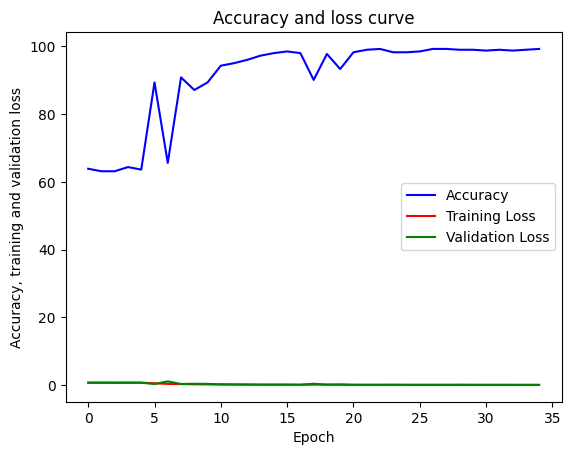

In [ ]:
plt.plot(epochs, accs, label='Accuracy', color='b')  # Plot first curve in blue
plt.plot(epochs, losses, label='Training Loss', color='r')  # Plot second curve in red
plt.plot(epochs, val_losses, label='Validation Loss', color='g')  # Plot second curve in red

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy, training and validation loss')
plt.title('Accuracy and loss curve')

# Show the legend
plt.legend()

# Display the plot
plt.show()

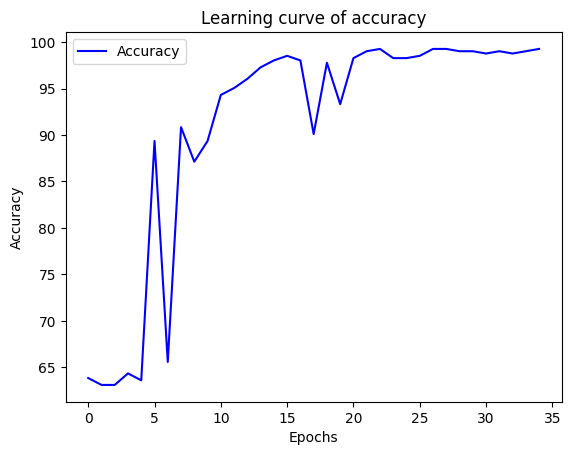

In [ ]:
plt.plot(epochs, accs, label='Accuracy', color='b')  # Plot first curve in blue

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning curve of accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()

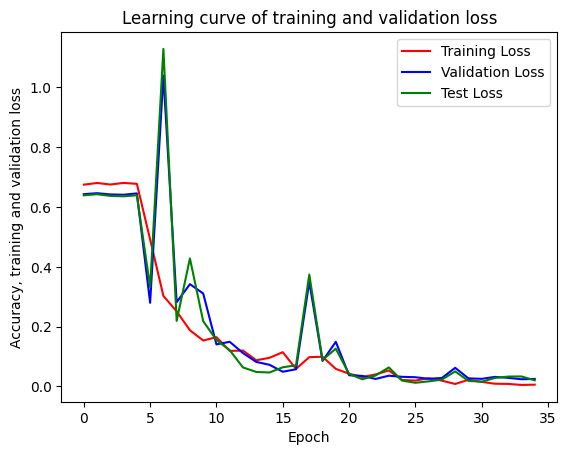

In [ ]:
plt.plot(epochs, losses, label='Training Loss', color='r')  # Plot second curve in red
plt.plot(epochs, val_losses, label='Validation Loss', color='b')  # Plot second curve in red
plt.plot(epochs, test_losses, label='Test Loss', color='g')  # Plot second curve in red

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy, training and validation loss')
plt.title('Learning curve of training and validation loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

# Fine-grained Pruning

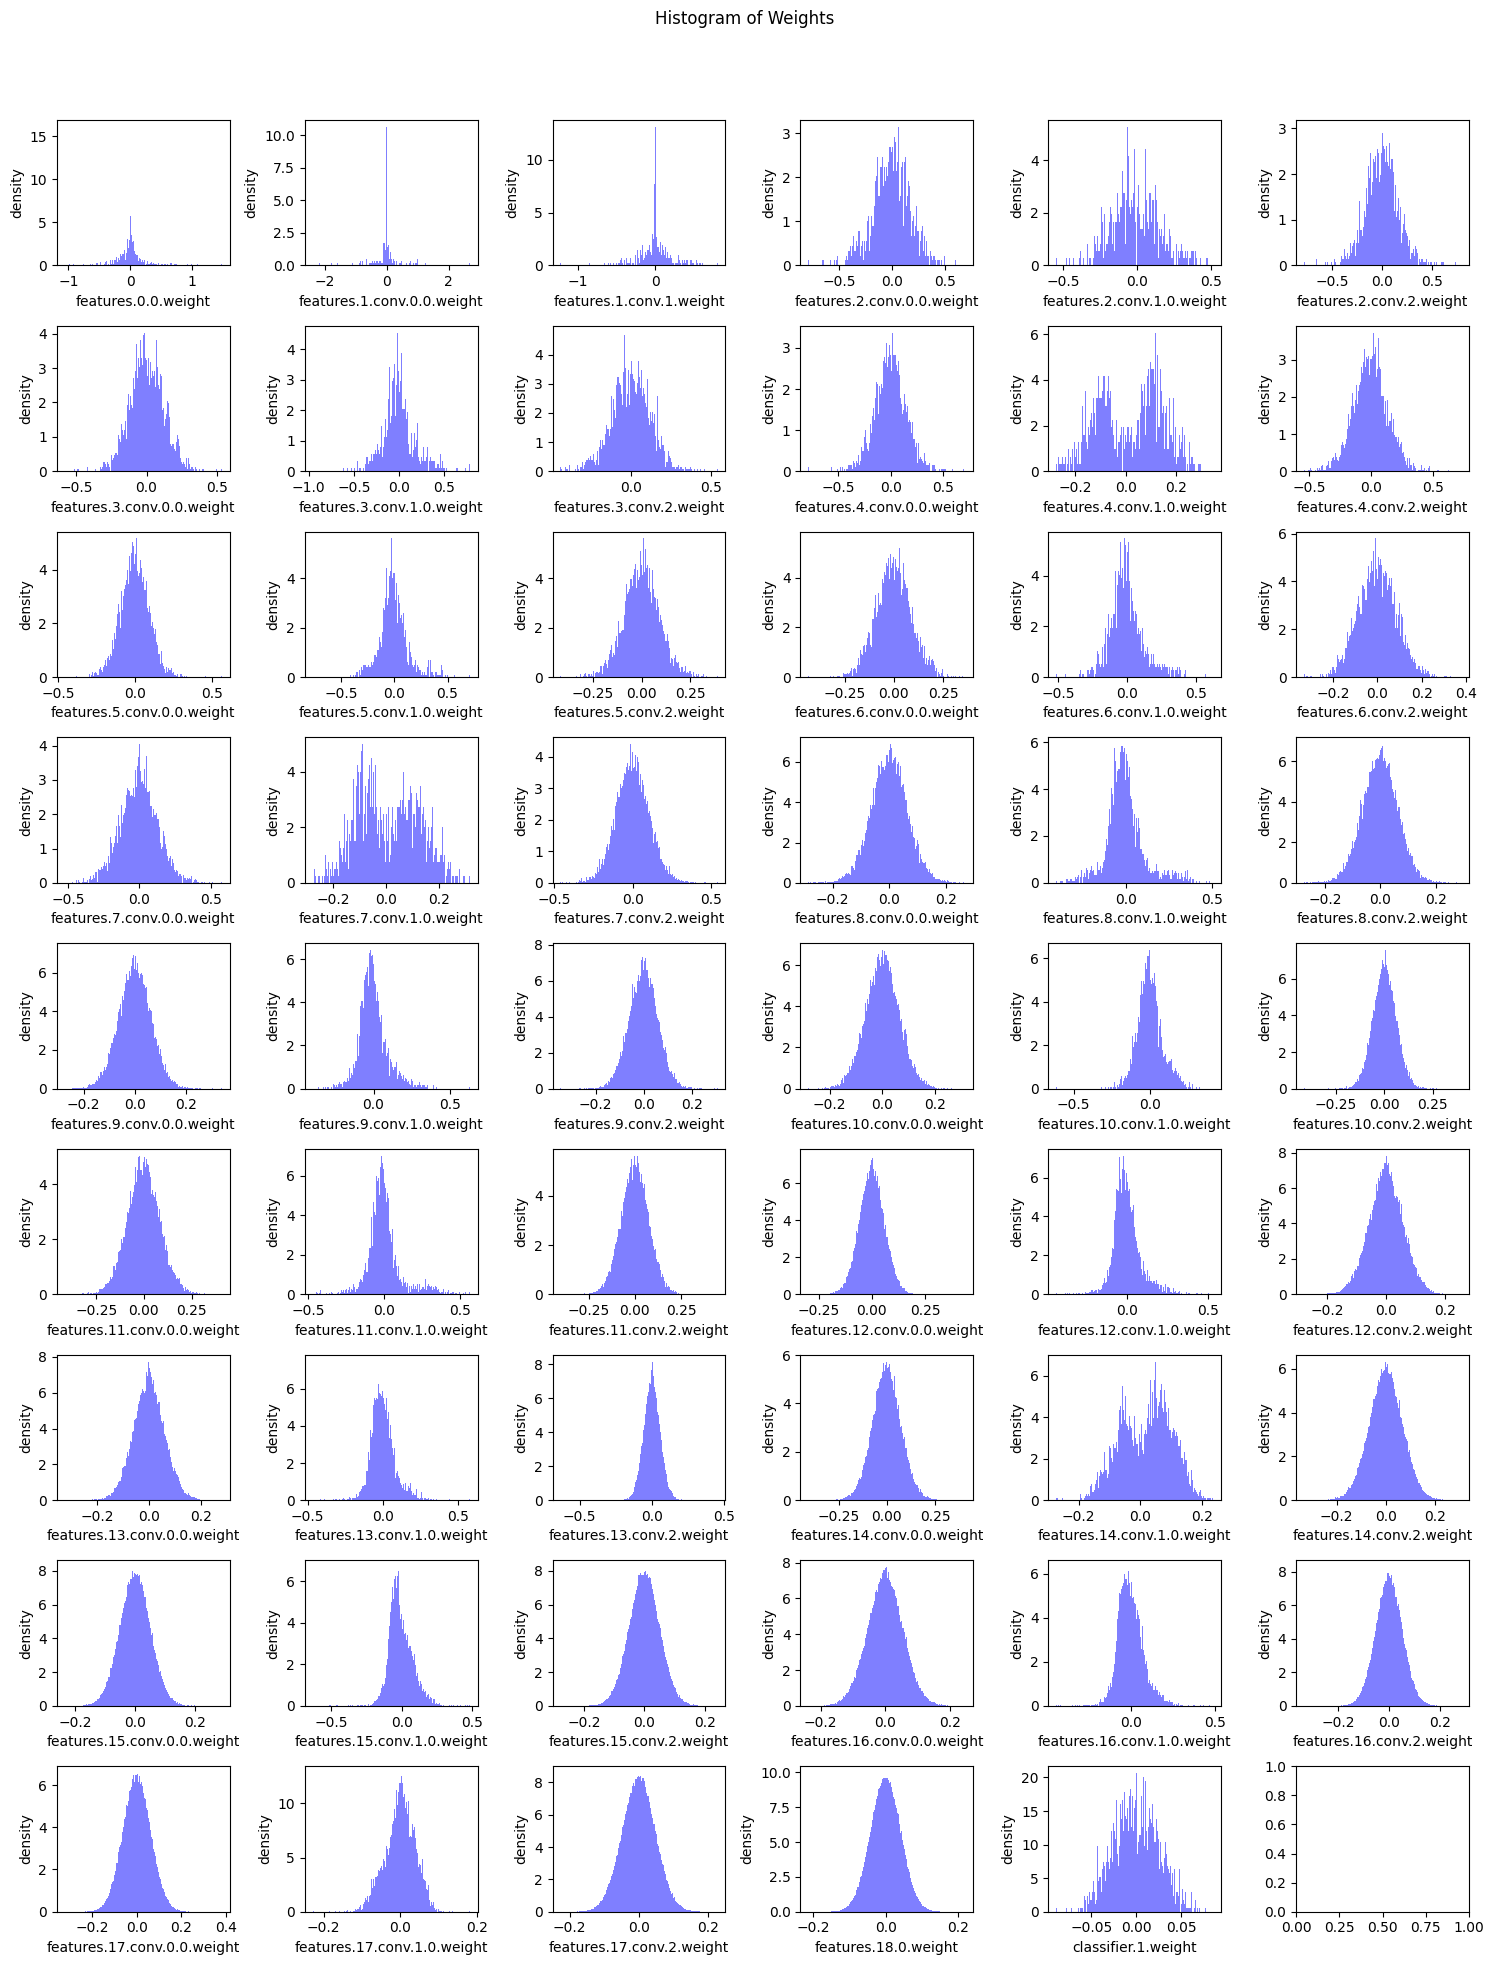

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(9,6, figsize=(15, 20))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

Define misc functions for verification.

In [ ]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    #fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.

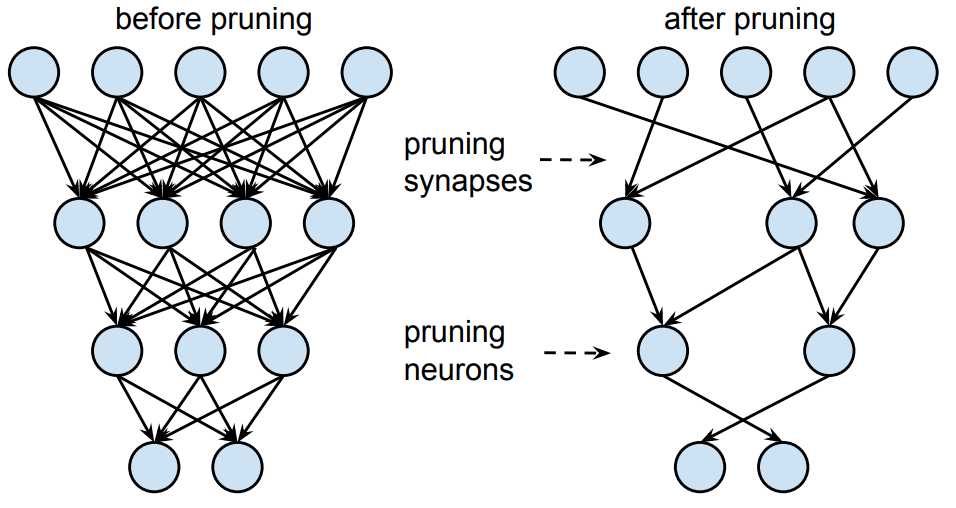

## Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

Please complete the following magnitude-based fine-grained pruning function.

**Hint**:
*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [ ]:
sparsity = min(max(0.0, 0.75), 1.0)

TypeError: 'Tensor' object is not callable

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements*sparsity)
    print(num_zeros)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    print(importance)
    # Step 3: calculate the pruning threshold
    threshold,ind=  torch.kthvalue(torch.abs(tensor.view(-1)), num_zeros)
    print(threshold)
    # Step 4: calculate the pruning mask
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance.gt(threshold)
    print(mask)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

Let's verify the functionality of defined fine-grained pruning by applying the function above on a dummy tensor.

### Test pruning fuction





The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

TypeError: 'Tensor' object is not callable

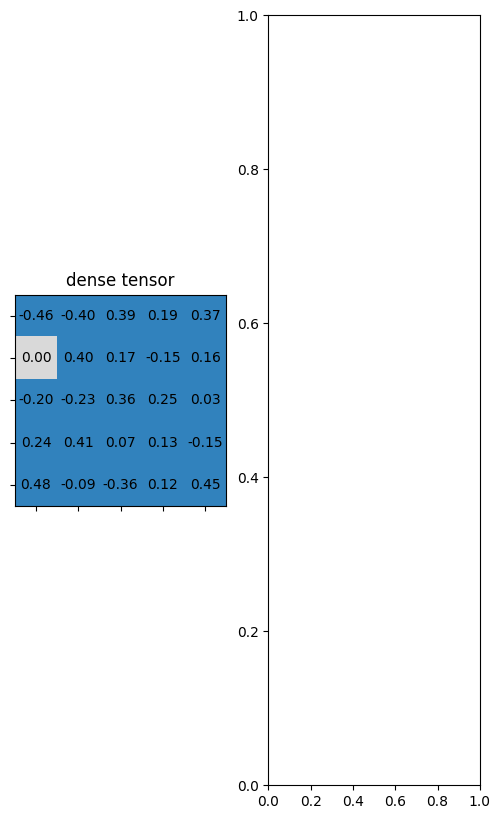

In [ ]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = .75 # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=6)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


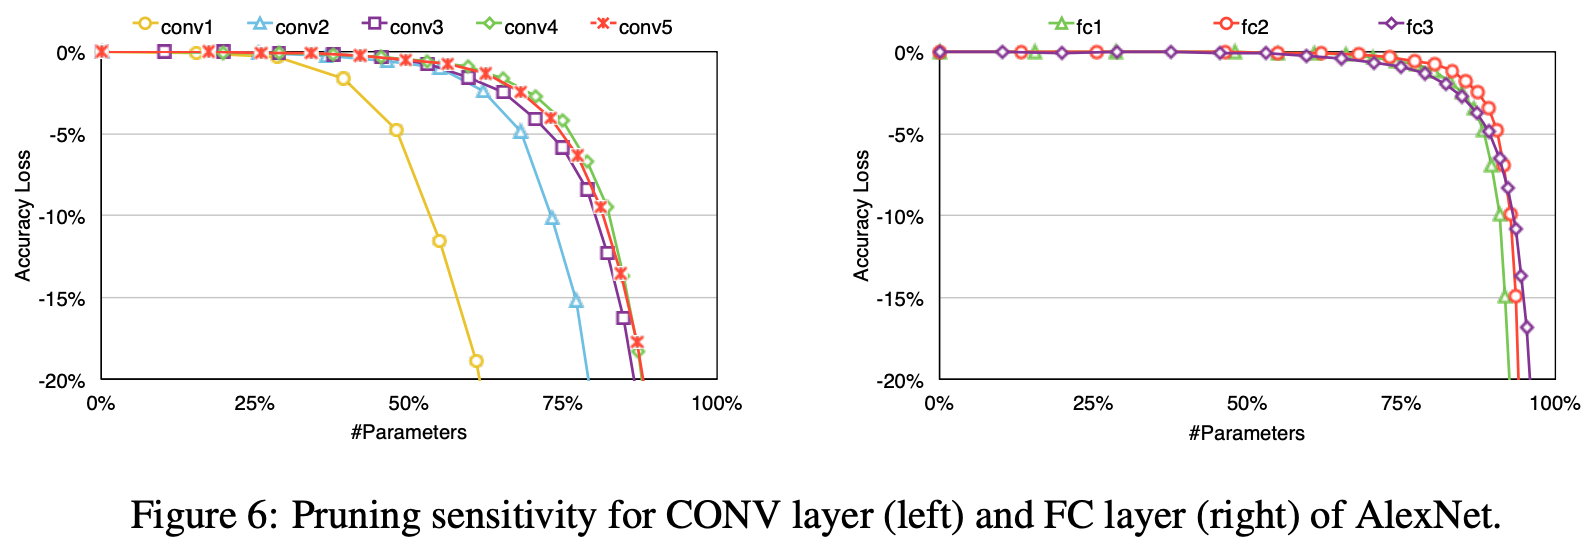

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc,_ = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

Please run the following cells to plot the sensitivity curves. It should take around 2 minutes to finish.

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['val'], scan_step=0.1, scan_start=0.1, scan_end=1.0)

scanning 0/53 weight - features.0.0.weight:   0%|          | 0/9 [00:00<?, ?it/s]

TypeError: 'Tensor' object is not callable

IndexError: index 21 is out of bounds for axis 0 with size 21

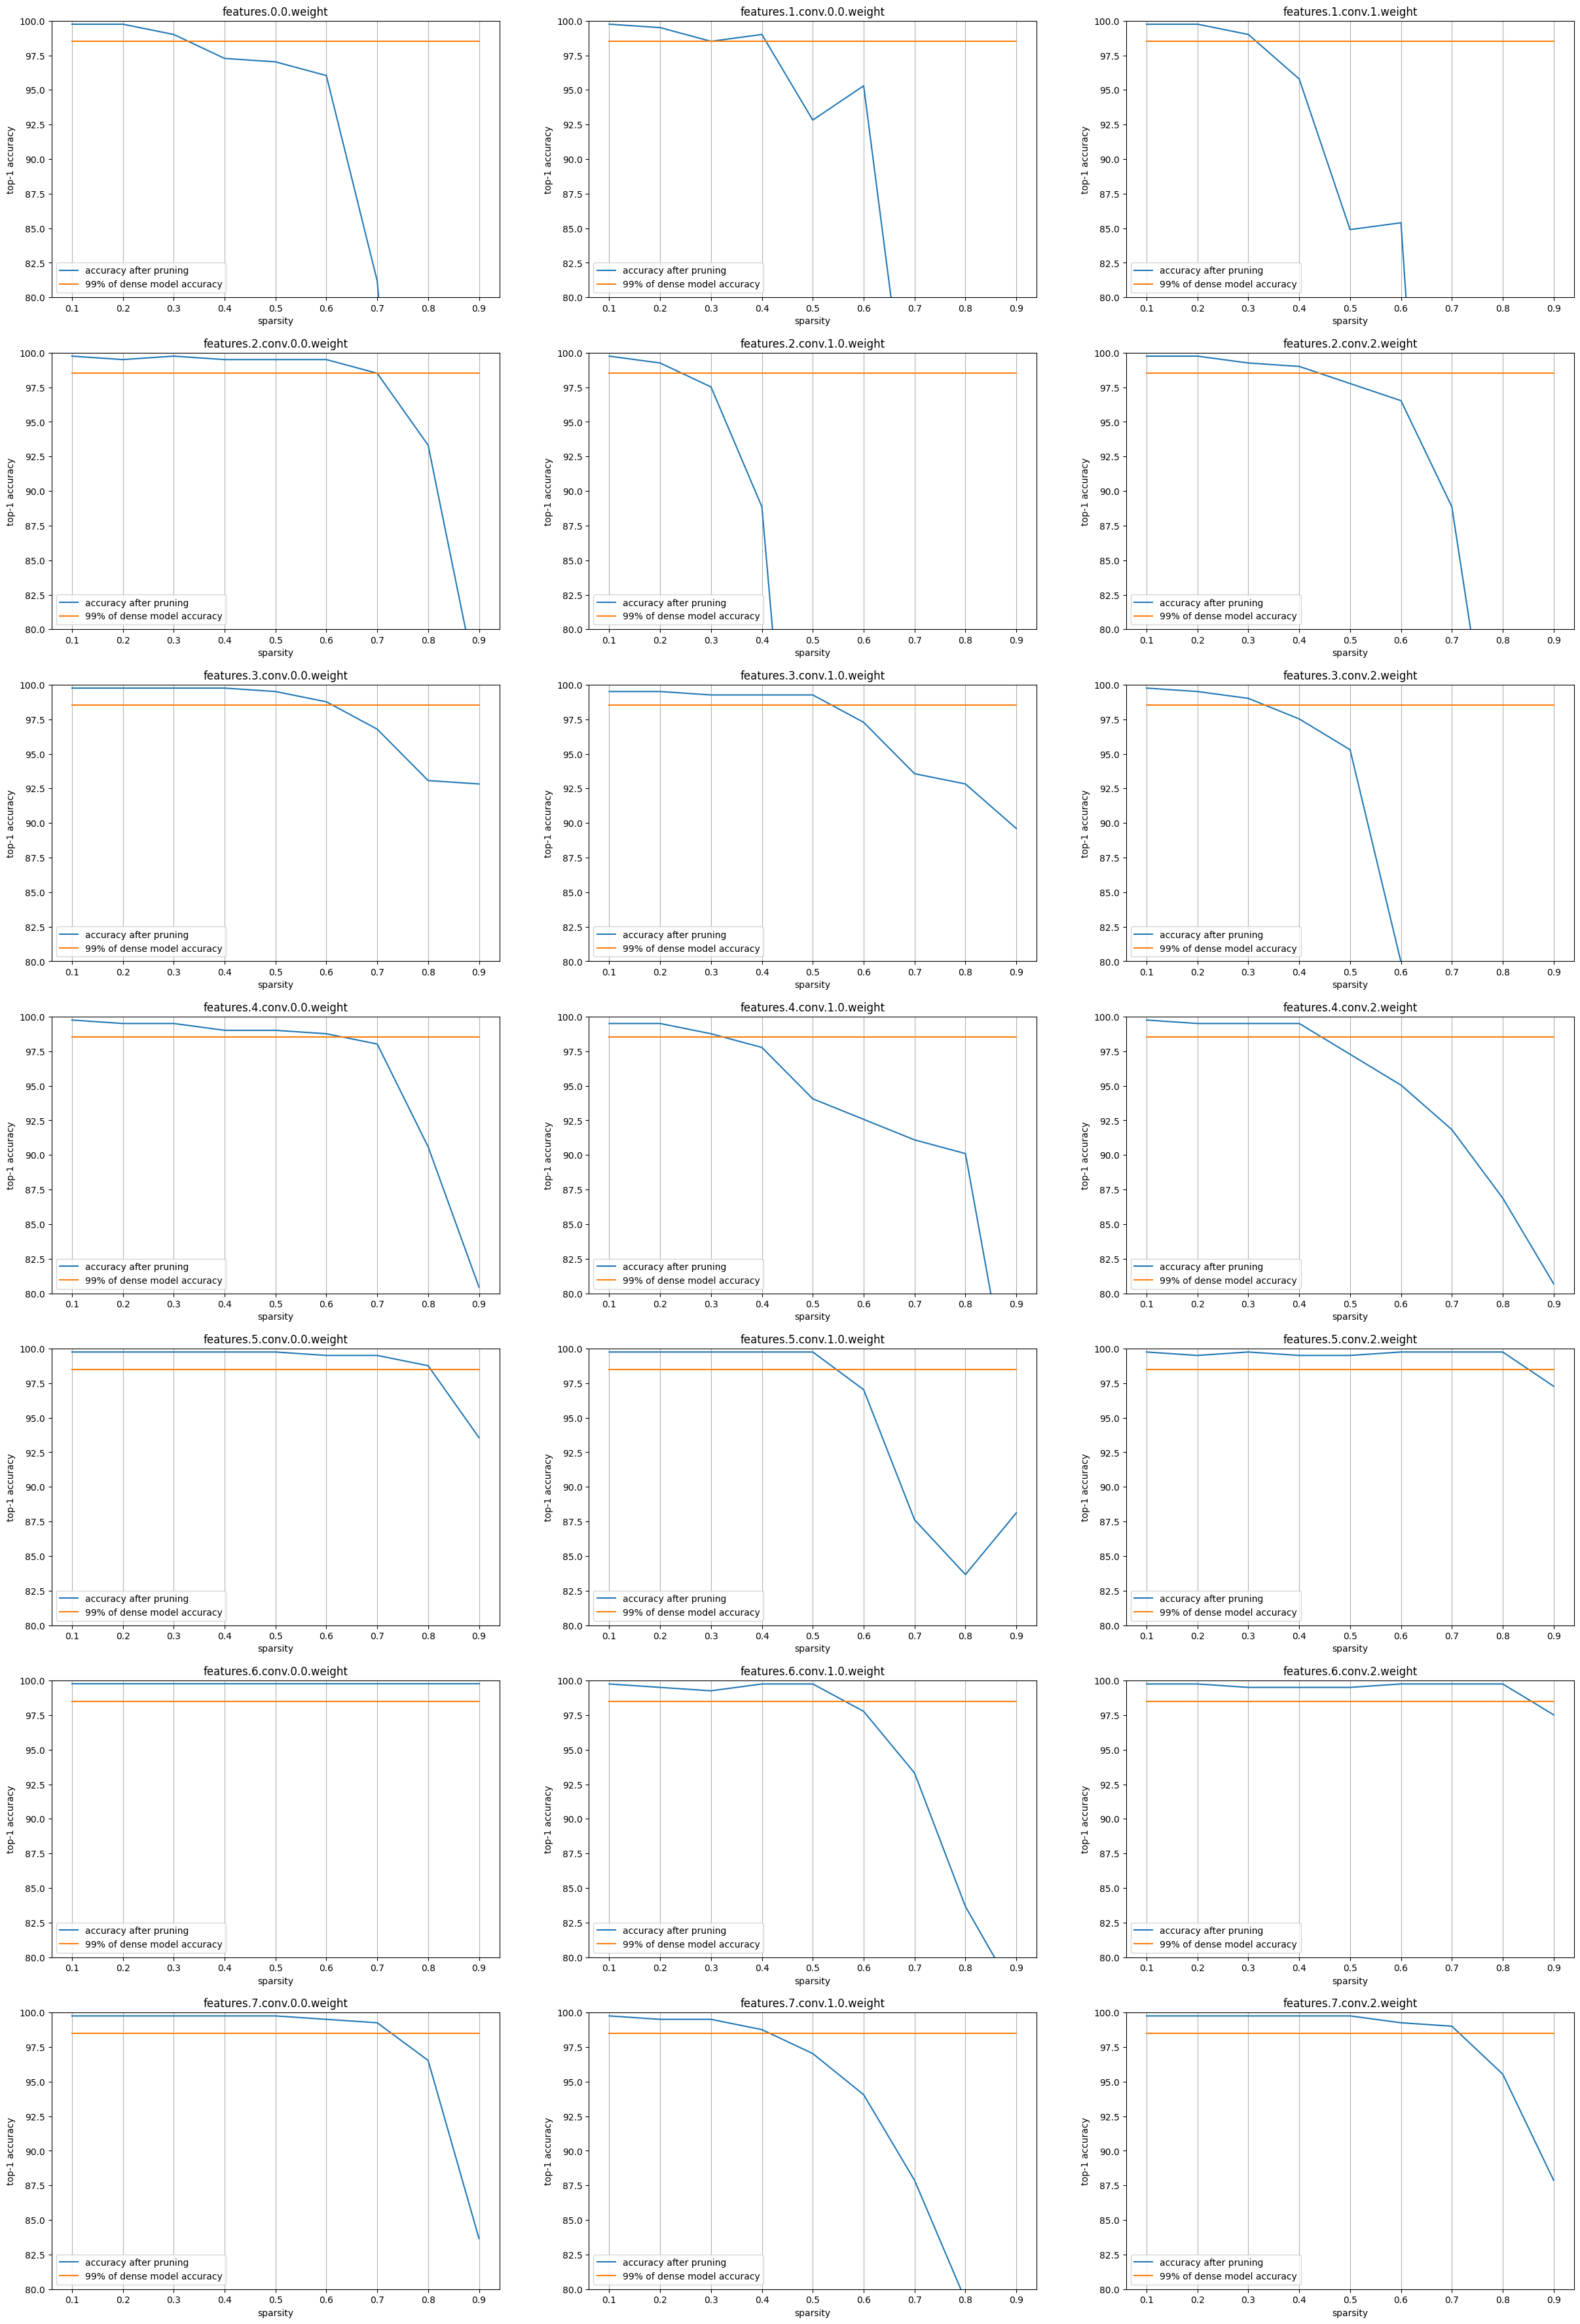

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(7, 3,figsize=(30,45))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.1, stop=1.0, step=0.1))
            ax.set_ylim(80, 100)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

#### Important points

* The relationship between pruning sparsity and model accuracy (*i.e.*, does accuracy increase or decrease when sparsity becomes higher?)

* All the layers does not have the same sensitivity

* Layer with less parameters is the most sensitive to the pruning sparsity

* In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

In [ ]:
thrshold=[]
t=90
for acc in accuracies:
  tn = torch.tensor(acc)
  bin=tn>t
  thrshold.append(int(torch.nonzero(bin)[-1])*.1)
thrshold

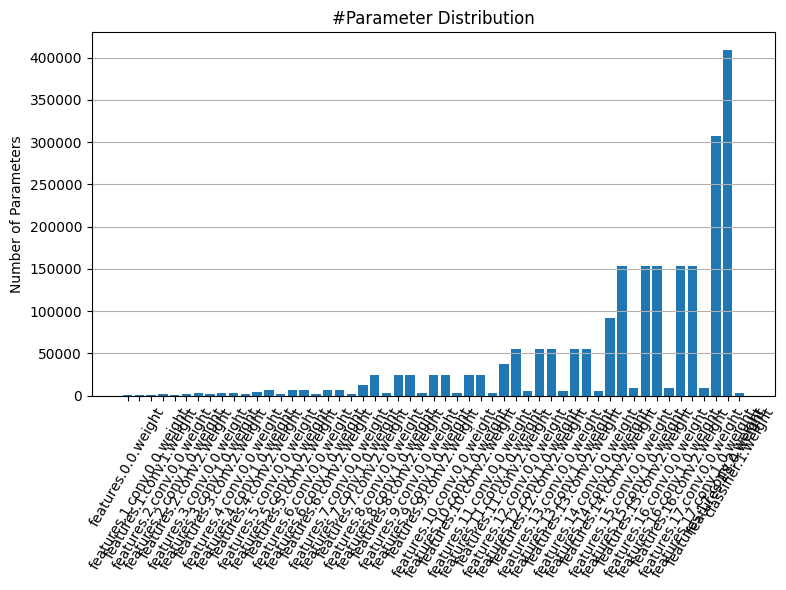

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution





Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.
:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [ ]:
evaluate(model, dataloader["val"])

eval:   0%|          | 0/13 [00:00<?, ?it/s]

(99.75247192382812, 0.0)

In [ ]:
print(thrshold)

[0.5, 0.5, 0.30000000000000004, 0.7000000000000001, 0.2, 0.5, 0.8, 0.7000000000000001, 0.4, 0.7000000000000001, 0.7000000000000001, 0.6000000000000001, 0.8, 0.5, 0.8, 0.8, 0.6000000000000001, 0.8, 0.7000000000000001, 0.5, 0.7000000000000001, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7000000000000001, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]


In [ ]:
i=0
for name, parameter in model.named_parameters():
    if parameter.dim() > 1:
        print(f"'{name}': {thrshold[i]},")
        i+=1


'features.0.0.weight': 0.5,
'features.1.conv.0.0.weight': 0.5,
'features.1.conv.1.weight': 0.30000000000000004,
'features.2.conv.0.0.weight': 0.7000000000000001,
'features.2.conv.1.0.weight': 0.2,
'features.2.conv.2.weight': 0.5,
'features.3.conv.0.0.weight': 0.8,
'features.3.conv.1.0.weight': 0.7000000000000001,
'features.3.conv.2.weight': 0.4,
'features.4.conv.0.0.weight': 0.7000000000000001,
'features.4.conv.1.0.weight': 0.7000000000000001,
'features.4.conv.2.weight': 0.6000000000000001,
'features.5.conv.0.0.weight': 0.8,
'features.5.conv.1.0.weight': 0.5,
'features.5.conv.2.weight': 0.8,
'features.6.conv.0.0.weight': 0.8,
'features.6.conv.1.0.weight': 0.6000000000000001,
'features.6.conv.2.weight': 0.8,
'features.7.conv.0.0.weight': 0.7000000000000001,
'features.7.conv.1.0.weight': 0.5,
'features.7.conv.2.weight': 0.7000000000000001,
'features.8.conv.0.0.weight': 0.8,
'features.8.conv.1.0.weight': 0.8,
'features.8.conv.2.weight': 0.8,
'features.9.conv.0.0.weight': 0.8,
'features.9.

In [ ]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
'features.0.0.weight': 0.5,
'features.1.conv.0.0.weight': 0.5,
'features.1.conv.1.weight': 0.30000000000000004,
'features.2.conv.0.0.weight': 0.7000000000000001,
'features.2.conv.1.0.weight': 0.2,
'features.2.conv.2.weight': 0.5,
'features.3.conv.0.0.weight': 0.8,
'features.3.conv.1.0.weight': 0.7000000000000001,
'features.3.conv.2.weight': 0.4,
'features.4.conv.0.0.weight': 0.7000000000000001,
'features.4.conv.1.0.weight': 0.7000000000000001,
'features.4.conv.2.weight': 0.6000000000000001,
'features.5.conv.0.0.weight': 0.8,
'features.5.conv.1.0.weight': 0.5,
'features.5.conv.2.weight': 0.8,
'features.6.conv.0.0.weight': 0.8,
'features.6.conv.1.0.weight': 0.6000000000000001,
'features.6.conv.2.weight': 0.8,
'features.7.conv.0.0.weight': 0.7000000000000001,
'features.7.conv.1.0.weight': 0.5,
'features.7.conv.2.weight': 0.7000000000000001,
'features.8.conv.0.0.weight': 0.8,
'features.8.conv.1.0.weight': 0.8,
'features.8.conv.2.weight': 0.8,
'features.9.conv.0.0.weight': 0.8,
'features.9.conv.1.0.weight': 0.8,
'features.9.conv.2.weight': 0.8,
'features.10.conv.0.0.weight': 0.8,
'features.10.conv.1.0.weight': 0.8,
'features.10.conv.2.weight': 0.8,
'features.11.conv.0.0.weight': 0.8,
'features.11.conv.1.0.weight': 0.8,
'features.11.conv.2.weight': 0.8,
'features.12.conv.0.0.weight': 0.8,
'features.12.conv.1.0.weight': 0.8,
'features.12.conv.2.weight': 0.8,
'features.13.conv.0.0.weight': 0.8,
'features.13.conv.1.0.weight': 0.8,
'features.13.conv.2.weight': 0.8,
'features.14.conv.0.0.weight': 0.8,
'features.14.conv.1.0.weight': 0.7000000000000001,
'features.14.conv.2.weight': 0.8,
'features.15.conv.0.0.weight': 0.8,
'features.15.conv.1.0.weight': 0.8,
'features.15.conv.2.weight': 0.8,
'features.16.conv.0.0.weight': 0.8,
'features.16.conv.1.0.weight': 0.8,
'features.16.conv.2.weight': 0.8,
'features.17.conv.0.0.weight': 0.8,
'features.17.conv.1.0.weight': 0.8,
'features.17.conv.2.weight': 0.8,
'features.18.0.weight': 0.8,
'classifier.1.weight': 0.8,
      ##################### YOUR CODE ENDS HERE #######################
}

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.0.1.num_batches_tracked", "features.1.conv.0.0.weight", "features.1.conv.0.1.weight", "features.1.conv.0.1.bias", "features.1.conv.0.1.running_mean", "features.1.conv.0.1.running_var", "features.1.conv.0.1.num_batches_tracked", "features.1.conv.1.weight", "features.1.conv.2.weight", "features.1.conv.2.bias", "features.1.conv.2.running_mean", "features.1.conv.2.running_var", "features.1.conv.2.num_batches_tracked", "features.2.conv.0.0.weight", "features.2.conv.0.1.weight", "features.2.conv.0.1.bias", "features.2.conv.0.1.running_mean", "features.2.conv.0.1.running_var", "features.2.conv.0.1.num_batches_tracked", "features.2.conv.1.0.weight", "features.2.conv.1.1.weight", "features.2.conv.1.1.bias", "features.2.conv.1.1.running_mean", "features.2.conv.1.1.running_var", "features.2.conv.1.1.num_batches_tracked", "features.2.conv.2.weight", "features.2.conv.3.weight", "features.2.conv.3.bias", "features.2.conv.3.running_mean", "features.2.conv.3.running_var", "features.2.conv.3.num_batches_tracked", "features.3.conv.0.0.weight", "features.3.conv.0.1.weight", "features.3.conv.0.1.bias", "features.3.conv.0.1.running_mean", "features.3.conv.0.1.running_var", "features.3.conv.0.1.num_batches_tracked", "features.3.conv.1.0.weight", "features.3.conv.1.1.weight", "features.3.conv.1.1.bias", "features.3.conv.1.1.running_mean", "features.3.conv.1.1.running_var", "features.3.conv.1.1.num_batches_tracked", "features.3.conv.2.weight", "features.3.conv.3.weight", "features.3.conv.3.bias", "features.3.conv.3.running_mean", "features.3.conv.3.running_var", "features.3.conv.3.num_batches_tracked", "features.4.conv.0.0.weight", "features.4.conv.0.1.weight", "features.4.conv.0.1.bias", "features.4.conv.0.1.running_mean", "features.4.conv.0.1.running_var", "features.4.conv.0.1.num_batches_tracked", "features.4.conv.1.0.weight", "features.4.conv.1.1.weight", "features.4.conv.1.1.bias", "features.4.conv.1.1.running_mean", "features.4.conv.1.1.running_var", "features.4.conv.1.1.num_batches_tracked", "features.4.conv.2.weight", "features.4.conv.3.weight", "features.4.conv.3.bias", "features.4.conv.3.running_mean", "features.4.conv.3.running_var", "features.4.conv.3.num_batches_tracked", "features.5.conv.0.0.weight", "features.5.conv.0.1.weight", "features.5.conv.0.1.bias", "features.5.conv.0.1.running_mean", "features.5.conv.0.1.running_var", "features.5.conv.0.1.num_batches_tracked", "features.5.conv.1.0.weight", "features.5.conv.1.1.weight", "features.5.conv.1.1.bias", "features.5.conv.1.1.running_mean", "features.5.conv.1.1.running_var", "features.5.conv.1.1.num_batches_tracked", "features.5.conv.2.weight", "features.5.conv.3.weight", "features.5.conv.3.bias", "features.5.conv.3.running_mean", "features.5.conv.3.running_var", "features.5.conv.3.num_batches_tracked", "features.6.conv.0.0.weight", "features.6.conv.0.1.weight", "features.6.conv.0.1.bias", "features.6.conv.0.1.running_mean", "features.6.conv.0.1.running_var", "features.6.conv.0.1.num_batches_tracked", "features.6.conv.1.0.weight", "features.6.conv.1.1.weight", "features.6.conv.1.1.bias", "features.6.conv.1.1.running_mean", "features.6.conv.1.1.running_var", "features.6.conv.1.1.num_batches_tracked", "features.6.conv.2.weight", "features.6.conv.3.weight", "features.6.conv.3.bias", "features.6.conv.3.running_mean", "features.6.conv.3.running_var", "features.6.conv.3.num_batches_tracked", "features.7.conv.0.0.weight", "features.7.conv.0.1.weight", "features.7.conv.0.1.bias", "features.7.conv.0.1.running_mean", "features.7.conv.0.1.running_var", "features.7.conv.0.1.num_batches_tracked", "features.7.conv.1.0.weight", "features.7.conv.1.1.weight", "features.7.conv.1.1.bias", "features.7.conv.1.1.running_mean", "features.7.conv.1.1.running_var", "features.7.conv.1.1.num_batches_tracked", "features.7.conv.2.weight", "features.7.conv.3.weight", "features.7.conv.3.bias", "features.7.conv.3.running_mean", "features.7.conv.3.running_var", "features.7.conv.3.num_batches_tracked", "features.8.conv.0.0.weight", "features.8.conv.0.1.weight", "features.8.conv.0.1.bias", "features.8.conv.0.1.running_mean", "features.8.conv.0.1.running_var", "features.8.conv.0.1.num_batches_tracked", "features.8.conv.1.0.weight", "features.8.conv.1.1.weight", "features.8.conv.1.1.bias", "features.8.conv.1.1.running_mean", "features.8.conv.1.1.running_var", "features.8.conv.1.1.num_batches_tracked", "features.8.conv.2.weight", "features.8.conv.3.weight", "features.8.conv.3.bias", "features.8.conv.3.running_mean", "features.8.conv.3.running_var", "features.8.conv.3.num_batches_tracked", "features.9.conv.0.0.weight", "features.9.conv.0.1.weight", "features.9.conv.0.1.bias", "features.9.conv.0.1.running_mean", "features.9.conv.0.1.running_var", "features.9.conv.0.1.num_batches_tracked", "features.9.conv.1.0.weight", "features.9.conv.1.1.weight", "features.9.conv.1.1.bias", "features.9.conv.1.1.running_mean", "features.9.conv.1.1.running_var", "features.9.conv.1.1.num_batches_tracked", "features.9.conv.2.weight", "features.9.conv.3.weight", "features.9.conv.3.bias", "features.9.conv.3.running_mean", "features.9.conv.3.running_var", "features.9.conv.3.num_batches_tracked", "features.10.conv.0.0.weight", "features.10.conv.0.1.weight", "features.10.conv.0.1.bias", "features.10.conv.0.1.running_mean", "features.10.conv.0.1.running_var", "features.10.conv.0.1.num_batches_tracked", "features.10.conv.1.0.weight", "features.10.conv.1.1.weight", "features.10.conv.1.1.bias", "features.10.conv.1.1.running_mean", "features.10.conv.1.1.running_var", "features.10.conv.1.1.num_batches_tracked", "features.10.conv.2.weight", "features.10.conv.3.weight", "features.10.conv.3.bias", "features.10.conv.3.running_mean", "features.10.conv.3.running_var", "features.10.conv.3.num_batches_tracked", "features.11.conv.0.0.weight", "features.11.conv.0.1.weight", "features.11.conv.0.1.bias", "features.11.conv.0.1.running_mean", "features.11.conv.0.1.running_var", "features.11.conv.0.1.num_batches_tracked", "features.11.conv.1.0.weight", "features.11.conv.1.1.weight", "features.11.conv.1.1.bias", "features.11.conv.1.1.running_mean", "features.11.conv.1.1.running_var", "features.11.conv.1.1.num_batches_tracked", "features.11.conv.2.weight", "features.11.conv.3.weight", "features.11.conv.3.bias", "features.11.conv.3.running_mean", "features.11.conv.3.running_var", "features.11.conv.3.num_batches_tracked", "features.12.conv.0.0.weight", "features.12.conv.0.1.weight", "features.12.conv.0.1.bias", "features.12.conv.0.1.running_mean", "features.12.conv.0.1.running_var", "features.12.conv.0.1.num_batches_tracked", "features.12.conv.1.0.weight", "features.12.conv.1.1.weight", "features.12.conv.1.1.bias", "features.12.conv.1.1.running_mean", "features.12.conv.1.1.running_var", "features.12.conv.1.1.num_batches_tracked", "features.12.conv.2.weight", "features.12.conv.3.weight", "features.12.conv.3.bias", "features.12.conv.3.running_mean", "features.12.conv.3.running_var", "features.12.conv.3.num_batches_tracked", "features.13.conv.0.0.weight", "features.13.conv.0.1.weight", "features.13.conv.0.1.bias", "features.13.conv.0.1.running_mean", "features.13.conv.0.1.running_var", "features.13.conv.0.1.num_batches_tracked", "features.13.conv.1.0.weight", "features.13.conv.1.1.weight", "features.13.conv.1.1.bias", "features.13.conv.1.1.running_mean", "features.13.conv.1.1.running_var", "features.13.conv.1.1.num_batches_tracked", "features.13.conv.2.weight", "features.13.conv.3.weight", "features.13.conv.3.bias", "features.13.conv.3.running_mean", "features.13.conv.3.running_var", "features.13.conv.3.num_batches_tracked", "features.14.conv.0.0.weight", "features.14.conv.0.1.weight", "features.14.conv.0.1.bias", "features.14.conv.0.1.running_mean", "features.14.conv.0.1.running_var", "features.14.conv.0.1.num_batches_tracked", "features.14.conv.1.0.weight", "features.14.conv.1.1.weight", "features.14.conv.1.1.bias", "features.14.conv.1.1.running_mean", "features.14.conv.1.1.running_var", "features.14.conv.1.1.num_batches_tracked", "features.14.conv.2.weight", "features.14.conv.3.weight", "features.14.conv.3.bias", "features.14.conv.3.running_mean", "features.14.conv.3.running_var", "features.14.conv.3.num_batches_tracked", "features.15.conv.0.0.weight", "features.15.conv.0.1.weight", "features.15.conv.0.1.bias", "features.15.conv.0.1.running_mean", "features.15.conv.0.1.running_var", "features.15.conv.0.1.num_batches_tracked", "features.15.conv.1.0.weight", "features.15.conv.1.1.weight", "features.15.conv.1.1.bias", "features.15.conv.1.1.running_mean", "features.15.conv.1.1.running_var", "features.15.conv.1.1.num_batches_tracked", "features.15.conv.2.weight", "features.15.conv.3.weight", "features.15.conv.3.bias", "features.15.conv.3.running_mean", "features.15.conv.3.running_var", "features.15.conv.3.num_batches_tracked", "features.16.conv.0.0.weight", "features.16.conv.0.1.weight", "features.16.conv.0.1.bias", "features.16.conv.0.1.running_mean", "features.16.conv.0.1.running_var", "features.16.conv.0.1.num_batches_tracked", "features.16.conv.1.0.weight", "features.16.conv.1.1.weight", "features.16.conv.1.1.bias", "features.16.conv.1.1.running_mean", "features.16.conv.1.1.running_var", "features.16.conv.1.1.num_batches_tracked", "features.16.conv.2.weight", "features.16.conv.3.weight", "features.16.conv.3.bias", "features.16.conv.3.running_mean", "features.16.conv.3.running_var", "features.16.conv.3.num_batches_tracked", "features.17.conv.0.0.weight", "features.17.conv.0.1.weight", "features.17.conv.0.1.bias", "features.17.conv.0.1.running_mean", "features.17.conv.0.1.running_var", "features.17.conv.0.1.num_batches_tracked", "features.17.conv.1.0.weight", "features.17.conv.1.1.weight", "features.17.conv.1.1.bias", "features.17.conv.1.1.running_mean", "features.17.conv.1.1.running_var", "features.17.conv.1.1.num_batches_tracked", "features.17.conv.2.weight", "features.17.conv.3.weight", "features.17.conv.3.bias", "features.17.conv.3.running_mean", "features.17.conv.3.running_var", "features.17.conv.3.num_batches_tracked", "features.18.0.weight", "features.18.1.weight", "features.18.1.bias", "features.18.1.running_mean", "features.18.1.running_var", "features.18.1.num_batches_tracked", "classifier.1.weight", "classifier.1.bias". 

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

In [ ]:
pruned_model=copy.deepcopy(model)

In [ ]:
pruner = FineGrainedPruner(pruned_model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in pruned_model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy,_ = evaluate(pruned_model, dataloader['val'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(pruned_model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [ ]:
num_finetune_epochs = 15
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train_loss=train(pruned_model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(pruned_model)])
    val_acc ,val_loss = evaluate(pruned_model, dataloader['val'],criterion)
    accuracy ,test_loss = evaluate(pruned_model, dataloader['test'],criterion)
    is_best = val_acc > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(pruned_model.state_dict())
        best_accuracy = val_acc
    print(f'    Epoch {epoch+1} Accuracy {val_acc:.2f}% / Best Accuracy: {best_accuracy:.2f}%, test accuracy:{accuracy:.2f} train loss: {train_loss:.4f}, val loss {val_loss:.4f}, test loss {test_loss:.4f}')

Finetuning Fine-grained Pruned Sparse Model


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 1 Accuracy 98.27% / Best Accuracy: 98.27%, test accuracy:97.01 train loss: 0.0571, val loss 0.0626, test loss 0.0735


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 2 Accuracy 98.27% / Best Accuracy: 98.27%, test accuracy:98.01 train loss: 0.0456, val loss 0.0543, test loss 0.0602


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 3 Accuracy 97.52% / Best Accuracy: 98.27%, test accuracy:97.51 train loss: 0.0523, val loss 0.0712, test loss 0.0653


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 4 Accuracy 98.02% / Best Accuracy: 98.27%, test accuracy:97.01 train loss: 0.0509, val loss 0.0595, test loss 0.0638


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 5 Accuracy 98.51% / Best Accuracy: 98.51%, test accuracy:98.51 train loss: 0.0532, val loss 0.0571, test loss 0.0549


Run the following cell to see the information of best finetuned sparse model.

In [ ]:
all_labels, all_preds,all_outputs,loss = get_labels_preds(pruned_model, dataloader["test"])
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
conf_matrix=confusion_matrix(all_labels, all_preds)
print(conf_matrix)

Precision: 0.9541, Recall: 0.9656, F1: 0.9595
[[ 60   2]
 [  5 132]]


In [ ]:
# load the best sparse model checkpoint to evaluate the final performance
pruned_model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

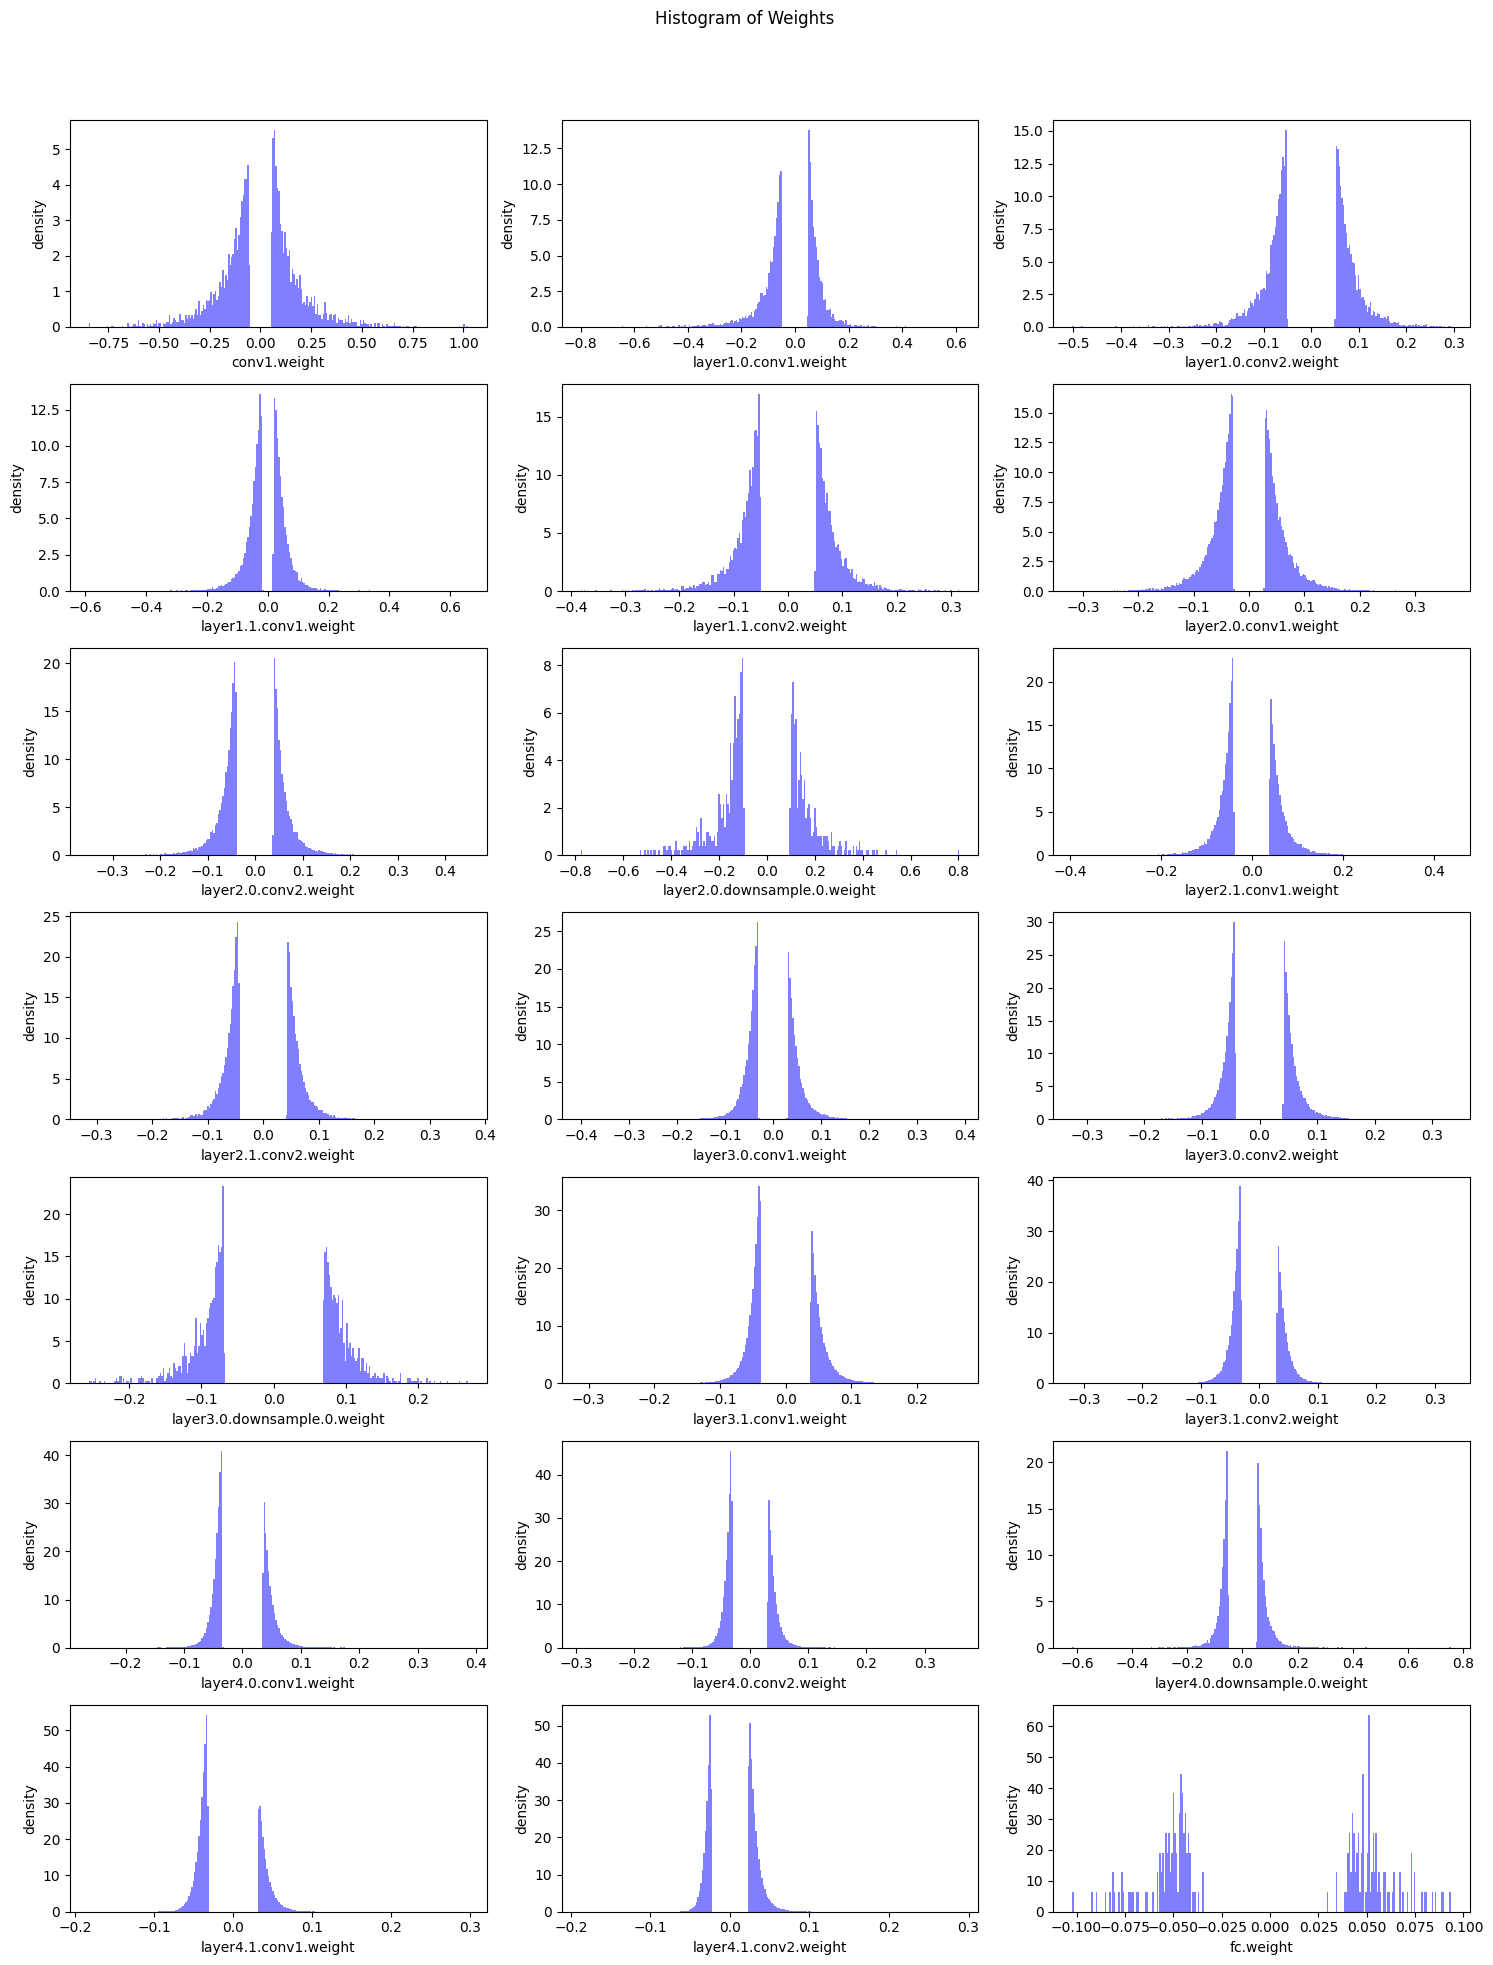

In [ ]:
plot_weight_distribution(pruned_model, count_nonzero_only=True)

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).cuda()
get_model_macs(pruned_model, dummy_input)

1816046592

In [ ]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 224, 224).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model,count_nonzero_only=True)
pruned_param = get_num_parameters(pruned_model,count_nonzero_only=True)
print(table_template.format('Param (M)',
                            round(int(original_param) / 1e6, 2),
                            round(int(pruned_param) / 1e6, 2),
                            round(int(original_param) / int(pruned_param), 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    55.2            63.6            0.9            
MACs (M)        1816            1816            1.0            
Param (M)       11.18           1.82            6.1            


# Channel Pruning

In this section, we will implement the channel pruning. Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm).

In [ ]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy,_ = evaluate(model, dataloader['val'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/14 [00:00<?, ?it/s]

dense model has accuracy=98.56%


## Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.


Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [ ]:
all_convs = [(name, layer) for name, layer in pruned_model.named_modules() if isinstance(layer, nn.Conv2d)]
all_bns = [(name, layer) for name, layer in pruned_model.named_modules() if isinstance(layer, nn.BatchNorm2d)]

for name, conv in all_convs:
  print(name, conv.weight.shape)

print()
for name, bn in all_bns:
  print(name, bn.weight.shape)

conv1 torch.Size([19, 3, 7, 7])
layer1.0.conv1 torch.Size([19, 19, 3, 3])
layer1.0.conv2 torch.Size([19, 19, 3, 3])
layer1.1.conv1 torch.Size([19, 19, 3, 3])
layer1.1.conv2 torch.Size([19, 19, 3, 3])
layer2.0.conv1 torch.Size([38, 19, 3, 3])
layer2.0.conv2 torch.Size([38, 38, 3, 3])
layer2.0.downsample.0 torch.Size([38, 19, 3, 3])
layer2.1.conv1 torch.Size([38, 38, 3, 3])
layer2.1.conv2 torch.Size([38, 38, 3, 3])
layer3.0.conv1 torch.Size([77, 38, 3, 3])
layer3.0.conv2 torch.Size([77, 77, 3, 3])
layer3.0.downsample.0 torch.Size([77, 38, 3, 3])
layer3.1.conv1 torch.Size([77, 77, 3, 3])
layer3.1.conv2 torch.Size([77, 77, 3, 3])
layer4.0.conv1 torch.Size([154, 77, 3, 3])
layer4.0.conv2 torch.Size([154, 154, 3, 3])
layer4.0.downsample.0 torch.Size([154, 77, 3, 3])
layer4.1.conv1 torch.Size([154, 154, 3, 3])
layer4.1.conv2 torch.Size([512, 154, 3, 3])

bn1 torch.Size([19])
layer1.0.bn1 torch.Size([19])
layer1.0.bn2 torch.Size([19])
layer1.1.bn1 torch.Size([19])
layer1.1.bn2 torch.Size([19])

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return round(channels*(1-prune_ratio))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([(name,layer) for name, layer in model.named_modules() if isinstance(layer, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [(name, layer) for name, layer in model.named_modules() if isinstance(layer, nn.Conv2d)]
    all_bns = [(name, layer) for name, layer in model.named_modules() if isinstance(layer, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        print(all_convs[i_ratio][0])
        if "downsample" in all_convs[i_ratio][0]:
          prev_conv = all_convs[i_ratio][1]
          prev_bn = all_bns[i_ratio][1]
          next_conv = all_convs[i_ratio + 1][1]
          original_channels = prev_conv.out_channels  # same as next_conv.in_channels
          n_keep = get_num_channels_to_keep(original_channels, p_ratio)
          print(prev_conv.weight.shape)
          # prune the output of the previous conv and bn
          prev_conv.weight.set_(prev_conv.weight.detach()[:,:n_keep//2])
          prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])

          prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
          prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
          prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
          prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])
          next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep])
        else:
          prev_conv = all_convs[i_ratio][1]
          prev_bn = all_bns[i_ratio][1]
          next_conv = all_convs[i_ratio + 1][1]
          original_channels = prev_conv.out_channels  # same as next_conv.in_channels
          n_keep = get_num_channels_to_keep(original_channels, p_ratio)

          # prune the output of the previous conv and bn
          prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
          prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
          prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
          prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
          prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])
          next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep])
    all_convs[n_conv-1].weight.set_(all_convs[n_conv-1].weight.detach()[:n_keep])
    all_bns[n_conv-1].weight.set_(all_bns[n_conv-1].weight.detach()[:n_keep])
    all_bns[n_conv-1].bias.set_(all_bns[n_conv-1].bias.detach()[:n_keep])
    all_bns[n_conv-1].running_mean.set_(all_bns[n_conv-1].running_mean.detach()[:n_keep])
    all_bns[n_conv-1].running_var.set_(all_bns[n_conv-1].running_var.detach()[:n_keep])
    model.fc.weight.set_(model.fc.weight.detach()[:,:n_keep])
    model.fc.bias.set_(model.fc.bias.detach()[:n_keep])
    return model


In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return round(channels*(1-prune_ratio))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep])
 #       next_conv.in_channels=n_keep
 #       prev_conv.out_channels=n_keep
        ##################### YOUR CODE ENDS HERE #####################

    return model


Run the following cell to perform a sanity check to make sure the implementation is correct.

In [ ]:
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d):
        print(name,layer.weight.shape)
    else:
        print(name)


conv1 torch.Size([64, 3, 7, 7])
bn1 torch.Size([64])
relu
maxpool
layer1
layer1.0
layer1.0.conv1 torch.Size([64, 64, 3, 3])
layer1.0.bn1 torch.Size([64])
layer1.0.conv2 torch.Size([64, 64, 3, 3])
layer1.0.bn2 torch.Size([64])
layer1.1
layer1.1.conv1 torch.Size([64, 64, 3, 3])
layer1.1.bn1 torch.Size([64])
layer1.1.conv2 torch.Size([64, 64, 3, 3])
layer1.1.bn2 torch.Size([64])
layer2
layer2.0
layer2.0.conv1 torch.Size([128, 64, 3, 3])
layer2.0.bn1 torch.Size([128])
layer2.0.conv2 torch.Size([128, 128, 3, 3])
layer2.0.bn2 torch.Size([128])
layer2.0.downsample
layer2.0.downsample.0 torch.Size([128, 64, 1, 1])
layer2.0.downsample.1 torch.Size([128])
layer2.1
layer2.1.conv1 torch.Size([128, 128, 3, 3])
layer2.1.bn1 torch.Size([128])
layer2.1.conv2 torch.Size([128, 128, 3, 3])
layer2.1.bn2 torch.Size([128])
layer3
layer3.0
layer3.0.conv1 torch.Size([256, 128, 3, 3])
layer3.0.bn1 torch.Size([256])
layer3.0.conv2 torch.Size([256, 256, 3, 3])
layer3.0.bn2 torch.Size([256])
layer3.0.downsample


In [ ]:
for name, layer in pruned_model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d):
        print(name,layer.weight.shape)
    else:
        print(name)


conv1 torch.Size([19, 3, 7, 7])
bn1 torch.Size([19])
relu
maxpool
layer1
layer1.0
layer1.0.conv1 torch.Size([19, 19, 3, 3])
layer1.0.bn1 torch.Size([19])
layer1.0.conv2 torch.Size([19, 19, 3, 3])
layer1.0.bn2 torch.Size([19])
layer1.1
layer1.1.conv1 torch.Size([19, 19, 3, 3])
layer1.1.bn1 torch.Size([19])
layer1.1.conv2 torch.Size([19, 19, 3, 3])
layer1.1.bn2 torch.Size([19])
layer2
layer2.0
layer2.0.conv1 torch.Size([38, 19, 3, 3])
layer2.0.bn1 torch.Size([38])
layer2.0.conv2 torch.Size([38, 38, 3, 3])
layer2.0.bn2 torch.Size([38])
layer2.0.downsample
layer2.0.downsample.0 torch.Size([38, 19, 1, 1])
layer2.0.downsample.1 torch.Size([38])
layer2.1
layer2.1.conv1 torch.Size([38, 38, 3, 3])
layer2.1.bn1 torch.Size([38])
layer2.1.conv2 torch.Size([38, 38, 3, 3])
layer2.1.bn2 torch.Size([38])
layer3
layer3.0
layer3.0.conv1 torch.Size([77, 38, 3, 3])
layer3.0.bn1 torch.Size([77])
layer3.0.conv2 torch.Size([77, 77, 3, 3])
layer3.0.bn2 torch.Size([77])
layer3.0.downsample
layer3.0.downsample

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).cuda()
pruned_model = channel_prune(model, prune_ratio=0.7)
macs = get_model_macs(model, dummy_input)
print("model macs:",macs)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print("pruned model macs:",pruned_macs)
# for name, param in pruned_model.named_parameters():
#   print(name+str(param.shape))
# print(model.backbone)
# print(macs)
# print(305388064-pruned_macs)

# assert pruned_macs == 305388064
# print('* Check passed. Right MACs for the pruned model.')

NameError: name 'channel_prune' is not defined

Now let's evaluate the performance of the model after uniform channel pruning with 30% pruning rate.

As you may see, directly removing 30% of the channels leads to low accuracy.

In [ ]:
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(name,layer.weight.shape)
    elif isinstance(layer, nn.BatchNorm2d):
        print(name,f"{layer.weight.shape}, {layer.bias.shape},{layer.running_mean.shape},{layer.running_var.shape}")


conv1 torch.Size([64, 3, 7, 7])
bn1 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer1.0.conv1 torch.Size([64, 64, 3, 3])
layer1.0.bn1 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer1.0.conv2 torch.Size([64, 64, 3, 3])
layer1.0.bn2 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer1.1.conv1 torch.Size([64, 64, 3, 3])
layer1.1.bn1 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer1.1.conv2 torch.Size([64, 64, 3, 3])
layer1.1.bn2 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer2.0.conv1 torch.Size([128, 64, 3, 3])
layer2.0.bn1 torch.Size([128]), torch.Size([128]),torch.Size([128]),torch.Size([128])
layer2.0.conv2 torch.Size([128, 128, 3, 3])
layer2.0.bn2 torch.Size([128]), torch.Size([128]),torch.Size([128]),torch.Size([128])
layer2.0.downsample.0 torch.Size([128, 64, 1, 1])
layer2.0.downsample.1 torch.Size([128]), torch.Size([128]),torch.Size([128]),torch.Size([1

In [ ]:
for name, layer in pruned_model.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(name,layer.weight.shape)
    elif isinstance(layer, nn.BatchNorm2d):
        print(name,f"{layer.weight.shape}, {layer.bias.shape},{layer.running_mean.shape},{layer.running_var.shape}")


conv1 torch.Size([19, 3, 7, 7])
bn1 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer1.0.conv1 torch.Size([19, 19, 3, 3])
layer1.0.bn1 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer1.0.conv2 torch.Size([19, 19, 3, 3])
layer1.0.bn2 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer1.1.conv1 torch.Size([19, 19, 3, 3])
layer1.1.bn1 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer1.1.conv2 torch.Size([19, 19, 3, 3])
layer1.1.bn2 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer2.0.conv1 torch.Size([38, 19, 3, 3])
layer2.0.bn1 torch.Size([38]), torch.Size([38]),torch.Size([38]),torch.Size([38])
layer2.0.conv2 torch.Size([38, 38, 3, 3])
layer2.0.bn2 torch.Size([38]), torch.Size([38]),torch.Size([38]),torch.Size([38])
layer2.0.downsample.0 torch.Size([38, 19, 1, 1])
layer2.0.downsample.1 torch.Size([38]), torch.Size([38]),torch.Size([38]),torch.Size([38])
layer2.1.co

In [ ]:
for name, layer in model.named_children():
    print(layer)


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:

dummy_input = torch.randn(1, 3, 224, 224).cuda()

# Iterate over each layer and pass the dummy input through it
print("Passing data through each layer input shape:\n")

# This is the first conv-bn-relu-maxpool part of ResNet18
x = dummy_input
identity=x
for name, layer in model.named_children():
    print(f"Layer: {name} | Input shape: {x.shape} ")
    if isinstance(layer, nn.Linear):
        x = torch.flatten(x, 1)
        print(layer.weight.shape)
    if isinstance(layer, nn.Sequential):
        for name, la in layer.named_children():
          for name, l in la.named_children():
            if(isinstance(l,nn.Sequential)):
              for name, ll in l.named_children():
                print(f"       Inner Sequential Layer: {ll.weight.shape} | Input shape: {x.shape} ")
                x = l(x)
                print(f"       Output Sequential shape: {x.shape}")
            else:
              print(f"       Inner Layer: {l} | Input shape: {x.shape} ")
              x = l(x)
              print(f"       Output shape: {x.shape}")
    else:
        x = layer(x)
    print(f"Layer: {name} | Output shape: {x.shape} ")


Passing data through each layer input shape:

Layer: conv1 | Input shape: torch.Size([1, 3, 224, 224]) 
Layer: conv1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer1 | Input shape: torch.Size([1, 19, 56, 56]) 
       Inner Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) | Input shape: torch.Size([1, 19, 56, 56]) 
       Output shape: torch.Size([1, 19, 56, 56])
       Inner Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) | Input shape: torch.Size([1, 19, 56, 56]) 
       Output shape: torch.Size([1, 19, 56, 56])
       Inner Layer: ReLU(inplace=True) | 

RuntimeError: Given groups=1, weight of size [38, 19, 1, 1], expected input[1, 38, 28, 28] to have 19 channels, but got 38 channels instead

In [ ]:

dummy_input = torch.randn(1, 3, 224, 224).cuda()

# Iterate over each layer and pass the dummy input through it
print("Passing data through each layer input shape:\n")

# This is the first conv-bn-relu-maxpool part of ResNet18
x = dummy_input
identity=x
for name, layer in pruned_model.named_children():
    print(f"Layer: {name} | Input shape: {x.shape} ")
    if isinstance(layer, nn.Linear):
        x = torch.flatten(x, 1)
        print(layer.weight.shape)
    if isinstance(layer, nn.Sequential):
        for name, l in layer.named_children():
            print(f"       Inner Layer: {name} | Input shape: {x.shape} ")
            x = l(x)
            print(f"       Output shape: {x.shape}")
    else:
        x = layer(x)
    print(f"Layer: {name} | Output shape: {x.shape} ")


Passing data through each layer input shape:

Layer: conv1 | Input shape: torch.Size([1, 3, 224, 224]) 
Layer: conv1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer1 | Input shape: torch.Size([1, 19, 56, 56]) 
       Inner Layer: 0 | Input shape: torch.Size([1, 19, 56, 56]) 
       Output shape: torch.Size([1, 19, 56, 56])
       Inner Layer: 1 | Input shape: torch.Size([1, 19, 56, 56]) 
       Output shape: torch.Size([1, 19, 56, 56])
Layer: 1 | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer2 | Input shape: torch.Size([1, 19, 56, 56]) 
       Inner Layer: 0 | Input shape: torch.Size([1, 19, 56, 56]) 
       Output sha

RuntimeError: The size of tensor a (512) must match the size of tensor b (154) at non-singleton dimension 1

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).cuda()

# Iterate over each layer and pass the dummy input through it
print("Passing data through each layer input shape:\n")

# This is the first conv-bn-relu-maxpool part of ResNet18
x = dummy_input
for name, layer in pruned_model.named_children():
    print(f"Layer: {name} | Input shape: {x.shape} ")
    if isinstance(layer, nn.Linear):
      x = torch.flatten(x, 1)
      print(layer.weight.shape)
    x = layer(x)
    print(f"Layer: {name} | Output shape: {x.shape} ")


Passing data through each layer input shape:

Layer: conv1 | Input shape: torch.Size([1, 3, 224, 224]) 
Layer: conv1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer1 | Input shape: torch.Size([1, 19, 56, 56]) 
Layer: layer1 | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer2 | Input shape: torch.Size([1, 19, 56, 56]) 
Layer: layer2 | Output shape: torch.Size([1, 38, 28, 28]) 
Layer: layer3 | Input shape: torch.Size([1, 38, 28, 28]) 
Layer: layer3 | Output shape: torch.Size([1, 77, 14, 14]) 
Layer: layer4 | Input shape: torch.Size([1, 77, 14, 14]) 


RuntimeError: The size of tensor a (512) must match the size of tensor b (154) at non-singleton dimension 1

In [ ]:
pruned_model_accuracy,_ = evaluate(pruned_model, dataloader['val'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/7 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [38, 38, 1, 1], expected input[32, 19, 56, 56] to have 38 channels, but got 19 channels instead

## Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.

### Question 7 (15 pts)
Please complete the following functions for sorting the weight tensor based on the Frobenius norm.

**Hint**:
* To calculate Frobenius norm of a tensor, Pytorch provides [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) APIs.

In [ ]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.linalg.norm(channel_weight)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Now run the following cell to sanity check if the results are correct.

In [ ]:
print('Before sorting...')
dense_model_accuracy,_ = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy,_ = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/13 [00:00<?, ?it/s]

dense model has accuracy=98.25%
After sorting...


eval:   0%|          | 0/13 [00:00<?, ?it/s]

sorted model has accuracy=98.25%
* Check passed.


Finally, we compare the pruned models' accuracy with and without sorting.

In [ ]:
channel_pruning_ratio = 0.7  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/13 [00:00<?, ?it/s]

pruned model has accuracy=68.67%
 * With sorting...


eval:   0%|          | 0/13 [00:00<?, ?it/s]

pruned model has accuracy=68.67%


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [ ]:
num_finetune_epochs = 20
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.00001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train_loss=train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy,test_loss = evaluate(pruned_model, dataloader['test'],criterion)
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%, train_loss:{train_loss:.4f}, test_loss:{test_loss:.4f}')

train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Accuracy 93.73% / Best Accuracy: 93.73%, train_loss:0.1711, test_loss:0.1578


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Accuracy 93.98% / Best Accuracy: 93.98%, train_loss:0.1644, test_loss:0.1548


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Accuracy 93.73% / Best Accuracy: 93.98%, train_loss:0.1835, test_loss:0.1634


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Accuracy 93.98% / Best Accuracy: 93.98%, train_loss:0.1460, test_loss:0.1630


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Accuracy 94.24% / Best Accuracy: 94.24%, train_loss:0.1764, test_loss:0.1525


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 Accuracy 93.98% / Best Accuracy: 94.24%, train_loss:0.1562, test_loss:0.1543


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 Accuracy 93.48% / Best Accuracy: 94.24%, train_loss:0.1584, test_loss:0.1571


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 Accuracy 93.98% / Best Accuracy: 94.24%, train_loss:0.1523, test_loss:0.1562


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 Accuracy 94.24% / Best Accuracy: 94.24%, train_loss:0.1824, test_loss:0.1525


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 Accuracy 93.98% / Best Accuracy: 94.24%, train_loss:0.1532, test_loss:0.1583


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 Accuracy 94.24% / Best Accuracy: 94.24%, train_loss:0.1490, test_loss:0.1547


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 Accuracy 93.98% / Best Accuracy: 94.24%, train_loss:0.1925, test_loss:0.1538


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 Accuracy 94.74% / Best Accuracy: 94.74%, train_loss:0.1671, test_loss:0.1573


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 Accuracy 94.74% / Best Accuracy: 94.74%, train_loss:0.1771, test_loss:0.1549


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 Accuracy 94.49% / Best Accuracy: 94.74%, train_loss:0.1573, test_loss:0.1602


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 Accuracy 95.24% / Best Accuracy: 95.24%, train_loss:0.1562, test_loss:0.1453


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 Accuracy 94.49% / Best Accuracy: 95.24%, train_loss:0.1446, test_loss:0.1511


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 Accuracy 94.49% / Best Accuracy: 95.24%, train_loss:0.1603, test_loss:0.1545


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 Accuracy 94.24% / Best Accuracy: 95.24%, train_loss:0.1604, test_loss:0.1502


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 Accuracy 94.99% / Best Accuracy: 95.24%, train_loss:0.1557, test_loss:0.1473


In [ ]:
sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

Sparse model has size=3.53 MiB = 19.61% of dense model size


In [ ]:
for name, param in pruned_model.named_parameters():
    if param.dim() > 1:
        print(name, param.shape)

backbone.conv0.weight torch.Size([10, 3, 3, 3])
backbone.conv1.weight torch.Size([10, 10, 3, 3])
backbone.conv2.weight torch.Size([19, 10, 3, 3])
backbone.conv3.weight torch.Size([19, 19, 3, 3])
backbone.conv4.weight torch.Size([38, 19, 3, 3])
backbone.conv5.weight torch.Size([38, 38, 3, 3])
backbone.conv6.weight torch.Size([77, 38, 3, 3])
backbone.conv7.weight torch.Size([77, 77, 3, 3])
backbone.conv8.weight torch.Size([154, 77, 3, 3])
backbone.conv9.weight torch.Size([512, 154, 3, 3])
fc2.weight torch.Size([2, 512])


## Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [ ]:
for name, layer in pruned_model.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(layer.weight.shape)

torch.Size([10, 3, 3, 3])
torch.Size([10, 10, 3, 3])
torch.Size([19, 10, 3, 3])
torch.Size([19, 19, 3, 3])
torch.Size([38, 19, 3, 3])
torch.Size([38, 38, 3, 3])
torch.Size([77, 38, 3, 3])
torch.Size([77, 77, 3, 3])
torch.Size([154, 77, 3, 3])
torch.Size([512, 154, 3, 3])


In [ ]:
table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 224, 224).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    98.9            21.1            4.7            
MACs (M)        3287            407             8.1            
Param (M)       4.72            0.92            5.1            


#### Point

Explain why removing 30% of channels roughly leads to 50% computation reduction.

Explain why the latency reduction ratio is slightly smaller than computation reduction.



After all experiments in this lab, you may have become familiar with both fine-grained pruning and channel pruning.

Please answer the following questions using what you have learned from the lectures and this lab.\

What are the advantages and disadvantages of fine-grained pruning and channel pruning? You can discuss from the perspective of compression ratio, accuracy, latency, hardware support (*i.e.*, requiring specialized hardware accelerator), etc.


If you want to make your model run faster on a smartphone, which pruning method will you use? Why?

In [ ]:

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Change output layer for 2 classes

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()


In [ ]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()  # This expects raw logits

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in dataloader["train"]:
        # Move inputs and labels to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Get logits
        loss = criterion(outputs, labels)  # Compute loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader["train"]):.4f}')


Epoch [1/10], Loss: 0.0147
Epoch [2/10], Loss: 0.0109
Epoch [3/10], Loss: 0.0102
Epoch [4/10], Loss: 0.0073
Epoch [5/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0195
Epoch [7/10], Loss: 0.0189
Epoch [8/10], Loss: 0.0083
Epoch [9/10], Loss: 0.0055
Epoch [10/10], Loss: 0.0071


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)  # Get logits
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Example usage (assuming you have a validation DataLoader)
# evaluate_model(model, val_loader)


In [ ]:
evaluate_model(model, dataloader["test"])

Accuracy: 96.99%




















# **Pruning and Sparsing**





This colab notebook provides code and a framework for ***Pruning and sparsing***.



# **Setup**

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


The system cannot find the path specified.


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

from torch.utils.data import Dataset

import os
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader,random_split,Subset,TensorDataset
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
from torch.utils.data import ConcatDataset
import torchvision.models as models
import torchvision
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score


assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [5]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


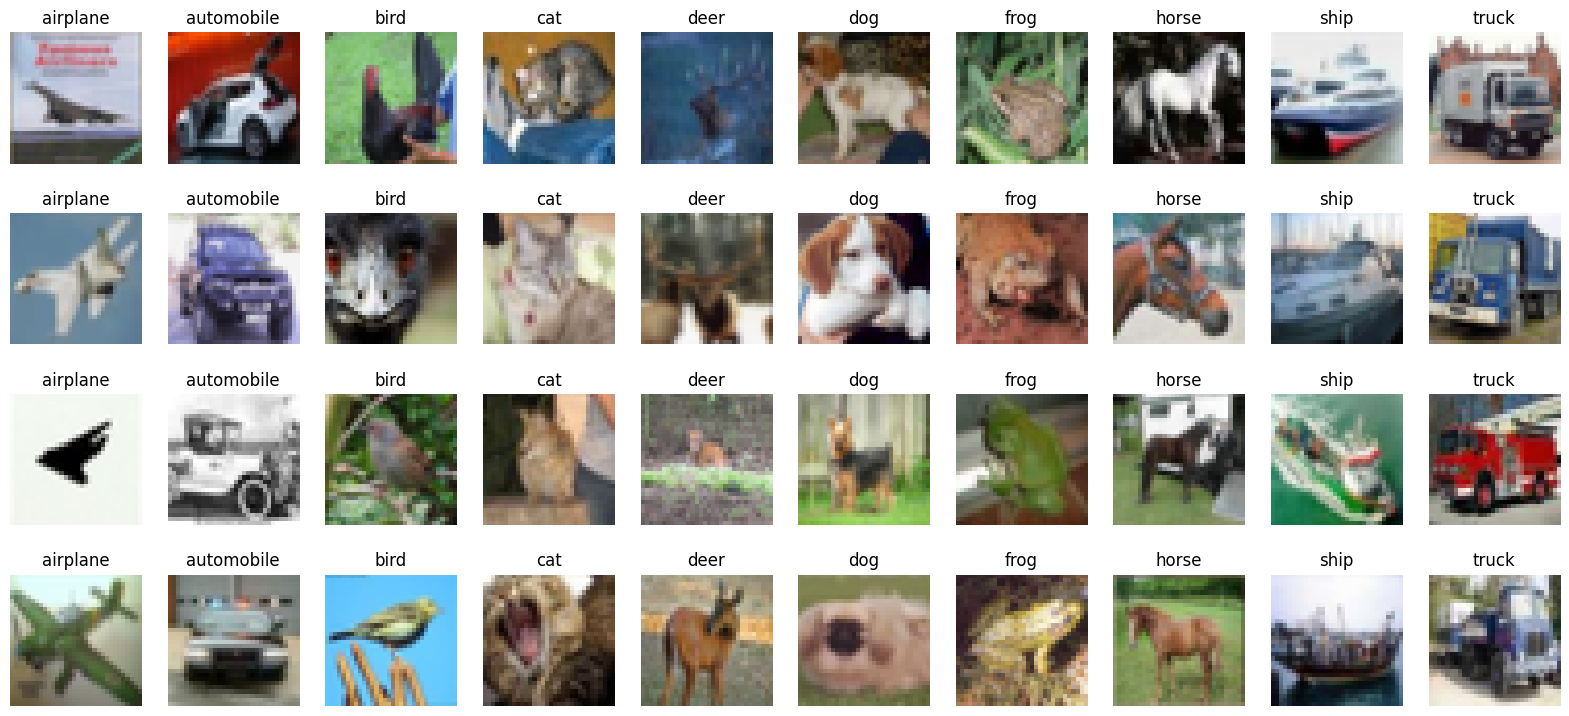

In [6]:

samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

In [7]:
# import shutil
# from sklearn.model_selection import train_test_split

# # Function to split data
# def split_data(source_dir, train_subdir, test_subdir, val_subdir, test_size=0.1, val_size=0.2):
#     # Get list of all files in the source directory
#     files = os.listdir(source_dir)

#     # Split files into training and testing sets
#     train_files, test_files = train_test_split(files, test_size=test_size+val_size, random_state=42)
#     test_files, val_files = train_test_split(test_files, test_size=val_size/(val_size+test_size), random_state=42)

#     # Move files to train and test directories
#     for file in train_files:
#         shutil.move(os.path.join(source_dir, file), os.path.join(train_subdir, file))

#     for file in test_files:
#         shutil.move(os.path.join(source_dir, file), os.path.join(test_subdir, file))

#     for file in val_files:
#         shutil.move(os.path.join(source_dir, file), os.path.join(val_subdir, file))



# # Define paths
# base_dir = '/content/drive/MyDrive/Papers/PhD/Colab/dataset_cancer_v1/classificacao_binaria/'

# sub_dirs=['400X','200X','100X','40X']

# for m in sub_dirs:
#   b_dir=os.path.join(base_dir,m)
#   train_dir = os.path.join(b_dir, 'train')
#   test_dir = os.path.join(b_dir, 'test')
#   val_dir = os.path.join(b_dir, 'val')

#   # Create train and test directories
#   os.makedirs(os.path.join(train_dir, 'benign'), exist_ok=True)
#   os.makedirs(os.path.join(test_dir, 'benign'), exist_ok=True)
#   os.makedirs(os.path.join(val_dir, 'benign'), exist_ok=True)
#   os.makedirs(os.path.join(train_dir, 'malignant'), exist_ok=True)
#   os.makedirs(os.path.join(test_dir, 'malignant'), exist_ok=True)
#   os.makedirs(os.path.join(val_dir, 'malignant'), exist_ok=True)

#   # Split benign data
#   split_data(os.path.join(b_dir, 'benign'), os.path.join(train_dir, 'benign'), os.path.join(test_dir, 'benign'), os.path.join(val_dir, 'benign'))

#   # Split malignant data
#   split_data(os.path.join(b_dir, 'malignant'), os.path.join(train_dir, 'malignant'), os.path.join(test_dir, 'malignant'), os.path.join(val_dir, 'malignant'))

# print("Data split into training and testing sets.")

In [8]:
# # Reaccumulate the images

# base_dir = 'H:\sutanu\BreaKHis\BreaKHis_v2\'

# sub_dirs=['400X','200X','100X','40X']


# for m in sub_dirs:
#   b_dir=os.path.join(base_dir,m)
#   benign_dir = os.path.join(b_dir, 'benign')
#   malignant_dir = os.path.join(b_dir, 'malignant')

#   train_dir_b = os.path.join(b_dir, 'train','benign')
#   train_dir_m = os.path.join(b_dir, 'train','malignant')

#   files_b = os.listdir(train_dir_b)
#   files_m = os.listdir(train_dir_m)

#   # merging benign data
#   for file in files_b:
#     shutil.move( os.path.join(train_dir_b, file),benign_dir)

#   # merging malignant data
#   for file in files_m:
#     shutil.move(os.path.join(train_dir_m, file), malignant_dir)

#   test_dir_b = os.path.join(b_dir, 'test','benign')
#   test_dir_m = os.path.join(b_dir, 'test','malignant')

#   files_b = os.listdir(test_dir_b)
#   files_m = os.listdir(test_dir_m)

#   # merging benign data
#   for file in files_b:
#     shutil.move( os.path.join(test_dir_b, file), benign_dir)

#   # merging malignant data
#   for file in files_m:
#     shutil.move(os.path.join(test_dir_m, file), malignant_dir)


#   val_dir_b = os.path.join(b_dir, 'val','benign')
#   val_dir_m = os.path.join(b_dir, 'val','malignant')

#   files_b = os.listdir(val_dir_b)
#   files_m = os.listdir(val_dir_m)

#   # merging benign data
#   for file in files_b:
#     shutil.move( os.path.join(val_dir_b, file), benign_dir)

#   # merging malignant data
#   for file in files_m:
#     shutil.move(os.path.join(val_dir_m, file), malignant_dir)

# print("Data merge into benign and maignant sets.")

In [9]:
magf='400X'


path='H:\sutanu\BreaKHis\BreaKHis_v2'
sub_dirs=['400X','200X','100X','40X']
types=['train','val','test']

image_size = 224
transform = Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        # Grayscale(num_output_channels=1),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])

root_dir=os.path.join(path, magf)

# Load dataset
image_dataset = ImageFolder(root=root_dir, transform=transform)



In [10]:
# Define split sizes
train_test_val_pecentage=[0.80, 0.20, 0.0]
test_size = int(train_test_val_pecentage[2]* len(image_dataset))   # 70% for training
val_size = int(train_test_val_pecentage[1] * len(image_dataset))    # 15% for validation
train_size = len(image_dataset) - test_size - val_size              # Remaining 15%

dataset={}
dataloader={}
    
# Split the dataset
dataset['train'],  dataset['test'], dataset['val'] ={},{},{}

for d in sub_dirs:
    dataset['train'][d],  dataset['test'][d], dataset['val'][d]=random_split(image_dataset, [train_size, test_size, val_size])

# Create DataLoaders
batch_size = 32  # Define batch size

dataloader['train'] = DataLoader(dataset['train'][magf], batch_size=batch_size, shuffle=True)
dataloader['test'] = DataLoader( dataset['test'][magf], batch_size=batch_size, shuffle=False)
dataloader['val'] = DataLoader(dataset['val'][magf], batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9502801..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.617647..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7030813..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.405462..2.5528543].


Magnification:400X, Type:train, size: torch.Size([3, 224, 224])
Magnification:400X, Type:val, size: torch.Size([3, 224, 224])
Magnification:200X, Type:train, size: torch.Size([3, 224, 224])
Magnification:200X, Type:val, size: torch.Size([3, 224, 224])
Magnification:100X, Type:train, size: torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.512605..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28501397..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.740196..2.2009804].


Magnification:100X, Type:val, size: torch.Size([3, 224, 224])
Magnification:40X, Type:train, size: torch.Size([3, 224, 224])
Magnification:40X, Type:val, size: torch.Size([3, 224, 224])


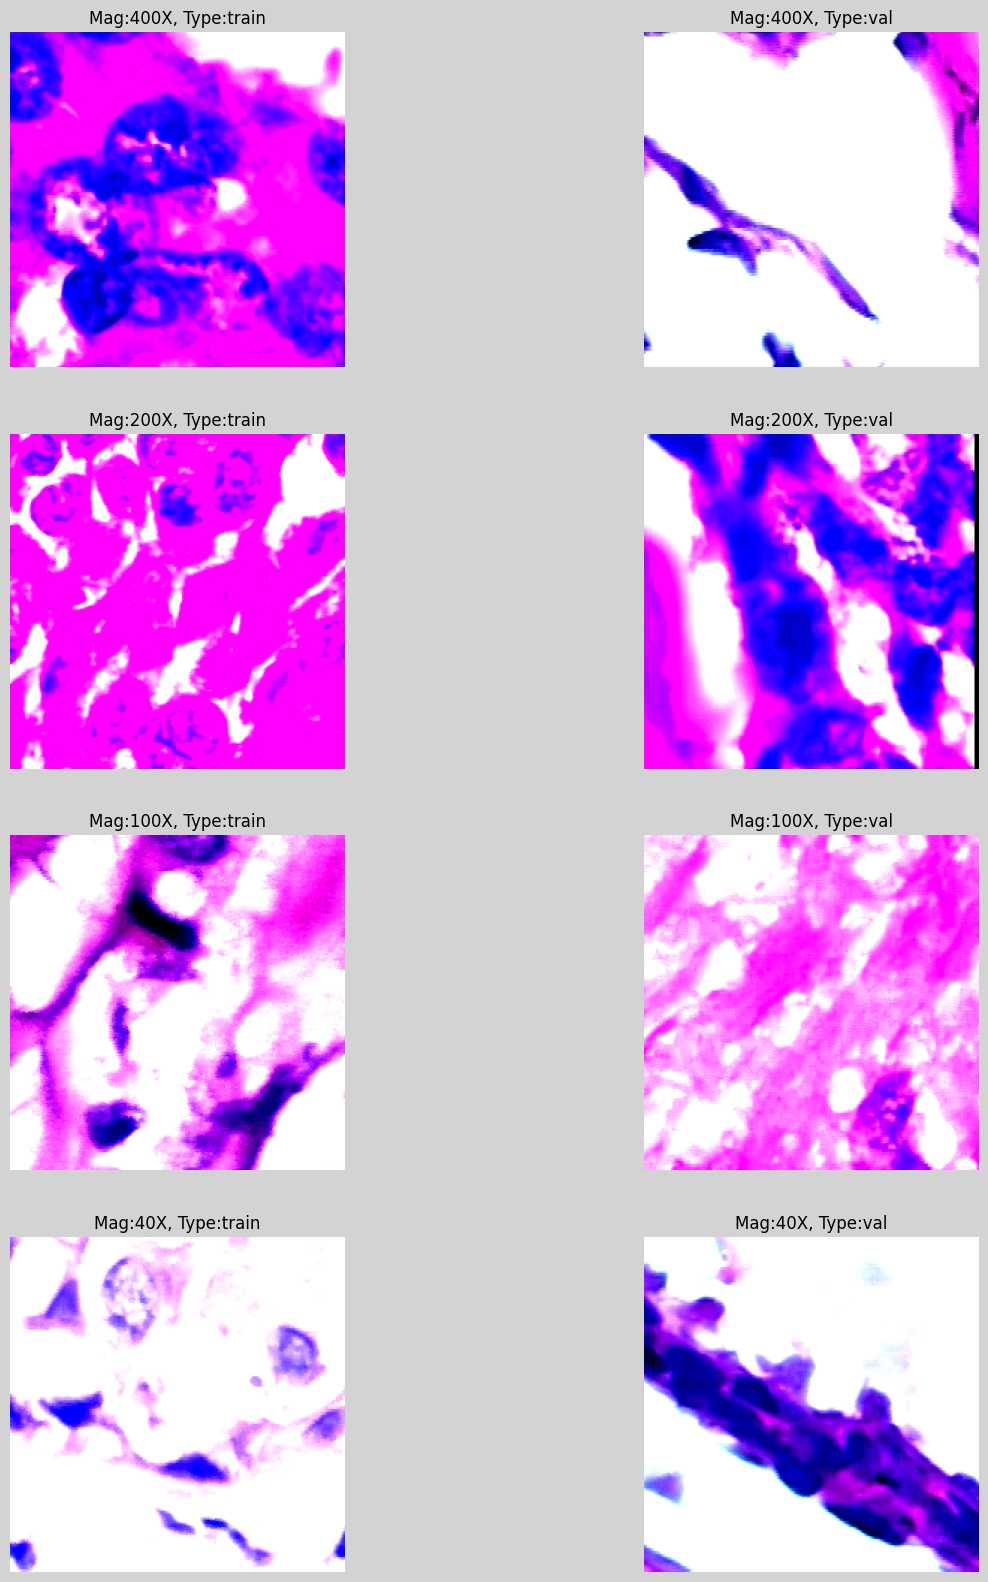

In [11]:
width=3
if test_size==0:
    width=2
fig, ax = plt.subplots(4, width, figsize=(15, 20))
fig.set_facecolor('lightgrey')
i,j=0,0

for d in sub_dirs:
    j=0
    for t in types:
        if test_size==0 and t=='test':
            break;
        image=dataset[t][d][0][0]
        print(f"Magnification:{d}, Type:{t}, size: {image.shape}")
        ax[i,j].imshow(image.permute(1, 2, 0),cmap='gray')
        ax[i,j].set_title(f"Mag:{d}, Type:{t}")
        ax[i,j].axis("off")
        j=j+1
    i=i+1
plt.show()


In [12]:
for image, label in dataloader["train"]:
  print("[image] , shape: {}".format(image.shape))
  print("[label] , shape: {}".format(label.shape))
  break

[image] , shape: torch.Size([32, 3, 224, 224])
[label] , shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77521..2.3760502].


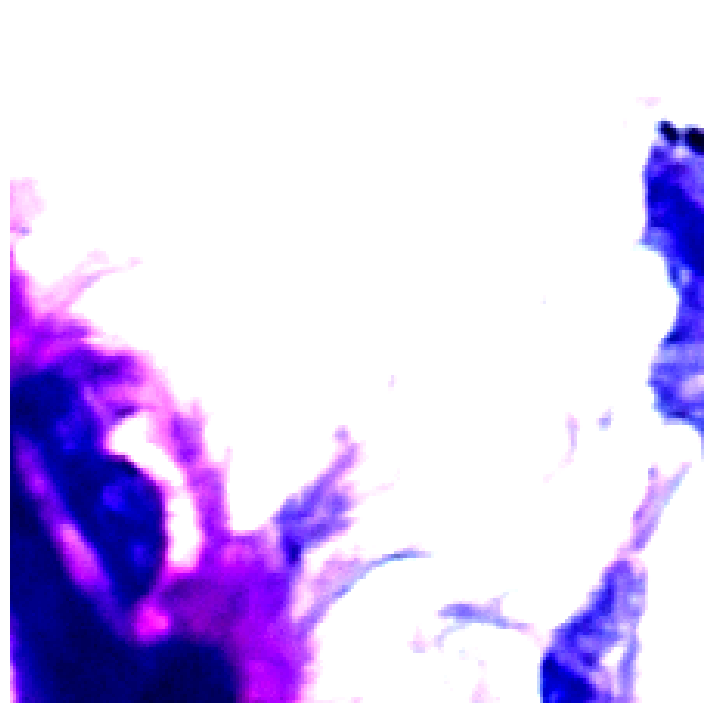

In [13]:
i=random.randint(0,len(image))
img=image[i]
plt.figure(figsize=(20, 9))

# 3. Display the image
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis('off')  # Turn off axis labels
plt.show()


In [14]:
class VGG(nn.Module):
  # ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
  ARCH = [32 , 32, 'M', 64, 64,'M',128, 128, 'M', 256, 256, 'M', 512, 512]

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
#    self.fc1 = nn.Linear(2024, 500)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
#    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = VGG().cuda()

In [15]:
import torch
import torch.nn as nn

# Define the basic block for ResNet (used in ResNet-18 and ResNet-34)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Define the bottleneck block for ResNet (used in ResNet-50 and above)
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU(inplace=True)(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.ReLU(inplace=True)(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = nn.ReLU(inplace=True)(out)

        return out

# Define the ResNet model
class MyResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, trim_percentages=None):
        super(MyResNet, self).__init__()
        if trim_percentages is not None:
            assert len(trim_percentages) == sum(layers)+1, "Invalid trim_percentages"
            self.trim_percentages = trim_percentages
        else:
            self.trim_percentages = [1] * (sum(layers)+1)

        self.in_channels = round(64*self.trim_percentages[0])
        self.conv1 = nn.Conv2d(3, round(64*self.trim_percentages[0]), kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(round(64*self.trim_percentages[0]))
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        start_ind=1
        end_ind=start_ind+layers[0]
        self.layer1 = self._make_layer(block, 64, layers[0],trim_percentages=self.trim_percentages[start_ind:end_ind])
        start_ind=end_ind
        end_ind=start_ind+layers[1]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,trim_percentages=self.trim_percentages[start_ind:end_ind])
        start_ind=end_ind
        end_ind=start_ind+layers[2]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,trim_percentages=self.trim_percentages[start_ind:end_ind])
        start_ind=end_ind
        end_ind=start_ind+layers[3]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,trim_percentages=self.trim_percentages[start_ind:end_ind])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear( round(512 * block.expansion*self.trim_percentages[-1]), num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1,trim_percentages=None):
        if trim_percentages is None:
            trim_percentages=[1]*block
        downsample = None
        if stride != 1 or self.in_channels != round(out_channels * block.expansion * trim_percentages[0]):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, round(out_channels * block.expansion * trim_percentages[0]), kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(round(out_channels * block.expansion * trim_percentages[0])),
            )
        layers = []
        layers.append(block(self.in_channels, round(out_channels*trim_percentages[0]), stride, downsample))
        self.in_channels = round(out_channels * block.expansion*trim_percentages[0])

        for i in range(1, blocks):
            downsample=None
            if stride != 1 or self.in_channels != round(out_channels * block.expansion * trim_percentages[i]):
                downsample = nn.Sequential(
                        nn.Conv2d(self.in_channels, round(out_channels * block.expansion * trim_percentages[i]), kernel_size=1, bias=False),
                        nn.BatchNorm2d(round(out_channels * block.expansion * trim_percentages[i])),
                    )

            layers.append(block(self.in_channels, round(out_channels*trim_percentages[i]),downsample=downsample))
            self.in_channels = round(out_channels * block.expansion*trim_percentages[i])

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Define functions to create different ResNet models
def Myresnet18(num_classes=1000,trim_percentages=None):
    return MyResNet(BasicBlock, [2, 2, 2, 2], num_classes,trim_percentages).cuda()

def Myresnet34(num_classes=1000,trim_percentages=None):
    return MyResNet(BasicBlock, [3, 4, 6, 3], num_classes,trim_percentages).cuda()

def Myresnet50(num_classes=1000,trim_percentages=None):
    return MyResNet(Bottleneck, [3, 4, 6, 3], num_classes,trim_percentages).cuda()

def Myresnet101(num_classes=1000,trim_percentages=None):
    return MyResNet(Bottleneck, [3, 4, 23, 3], num_classes,trim_percentages).cuda()

def Myresnet152(num_classes=1000,trim_percentages=None):
    return MyResNet(Bottleneck, [3, 8, 36, 3], num_classes,trim_percentages).cuda()



In [16]:
# model = models.mobilenet_v2(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

model = models.resnet152(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # num_classes is the number of output classes

# Freeze the feature layers by setting requires_grad=False

# Replace the final layer (fully connected) to fit your dataset

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\anaconda\envs\sutanu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\anaconda\envs\sutanu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  epoch=0,
  callbacks = None
) -> float:
  model.train()
  total_loss = 0
  for inputs, targets in tqdm(dataloader, desc=f'train epoch:{epoch}', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)

    loss = criterion(outputs, targets)
    total_loss += loss.item()


    # Backward propagation
    loss.backward()
    # Update optimizer and LR scheduler
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  return total_loss/len(dataloader)


In [18]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  criterion =None,
  verbose=True,
) :
  model.eval()
  total_loss = float(0)
  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs1 = model(inputs)

    # Convert logits to class indices
    outputs = outputs1.argmax(dim=1)

    # Calculate loss
    if criterion is not None:
      loss = criterion(outputs1, targets)
      total_loss += loss.item()


    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item(), total_loss/len(dataloader)

Helper Functions (Flops, Model Size calculation, etc.)

---
* The computation cost can be estimated by the number of [multiply–accumulate operations (MACs)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation) using [TorchProfile](https://github.com/zhijian-liu/torchprofile):


In [19]:

def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

# We can train the model directly


*As* we are working on a classification problem, we will apply [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function to optimize the model:

In [20]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using [stochastic gradient descent (SGD) or ADAM]
1. 40X: lr:0.0001 m:0.9
2. 100X: lr:0.001 to 0.0001 m:0.9
3. 200X: lr:0.0001 m:0.9
4. 400X: lr:0.0001 m:0.9





In [21]:
# optimizer = Adam(
#   model.parameters(),
#   lr=0.0001,
#   betas=(0.9, 0.999),
#   eps=1e-08,
#   weight_decay=0.0
# )

optimizer = SGD(
  model.parameters(),
  lr=0.0001,
  momentum=0.9,
  weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler (which is adapted from [this blog series](https://myrtle.ai/learn/how-to-train-your-resnet/)):

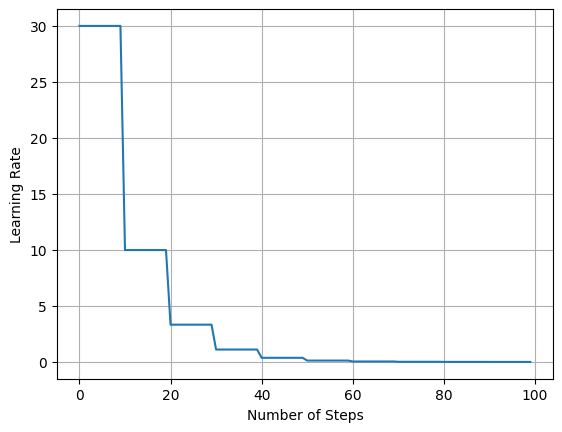

In [22]:
num_epochs = 100
steps_per_epoch = len(dataloader["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.0001, num_epochs],
  [0, 1, 0]
)[0]

lambda_lr = lambda x:30*( 0.333 ** (x // 10))

# Visualize the learning rate schedule
steps = np.arange(num_epochs)
plt.plot(steps, [lambda_lr(step)  for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lambda_lr)

With training and evaluation functions, we can finally start training the model! This will take around 10 minutes.

In [23]:
torch.cuda.empty_cache()

In [24]:
scheduler.get_last_lr()

[0.003]

In [25]:
losses, val_losses,test_losses, accs = [], [],[], []

In [28]:
best_acc=0
best_model=None
for epoch_num in tqdm(range(1, num_epochs + 1)):
  loss=train(model, dataloader["train"], criterion, optimizer, epoch=epoch_num)
  acc, val_loss = evaluate(model, dataloader["val"], criterion)
  if acc>best_acc:
    best_acc=acc
    best_model=copy.deepcopy(model)
  if test_size > 0:
    test_acc, test_loss = evaluate(model, dataloader["test"], criterion)
    print(f"Training Loss: {loss:.6f}. ,Validation Loss: {val_loss:.4f},Test Loss: {test_loss:.4f}, validation Accuracy {acc:.4f},Test Accuracy {test_acc:.4f}")
    test_losses.append(test_loss)
  else:
    print(f"Training Loss: {loss:.6f} LR:{scheduler.get_last_lr()} ,Test Loss: {val_loss:.4f}, Test Accuracy {acc:.4f}")
  losses.append(loss)
  val_losses.append(val_loss)
  accs.append(acc)
  if scheduler is not None:
    scheduler.step()


  0%|          | 0/100 [00:00<?, ?it/s]

train epoch:1:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016064 LR:[5.029949094191683e-08] ,Test Loss: 0.0481, Test Accuracy 98.3517


train epoch:2:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.012722 LR:[5.029949094191683e-08] ,Test Loss: 0.0821, Test Accuracy 97.8022


train epoch:3:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016750 LR:[5.029949094191683e-08] ,Test Loss: 0.0831, Test Accuracy 97.8022


train epoch:4:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.013186 LR:[5.029949094191683e-08] ,Test Loss: 0.0749, Test Accuracy 97.8022


train epoch:5:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.019882 LR:[5.029949094191683e-08] ,Test Loss: 0.0712, Test Accuracy 96.9780


train epoch:6:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.014288 LR:[5.029949094191683e-08] ,Test Loss: 0.0767, Test Accuracy 97.8022


train epoch:7:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.018075 LR:[5.029949094191683e-08] ,Test Loss: 0.0696, Test Accuracy 97.8022


train epoch:8:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.021091 LR:[5.029949094191683e-08] ,Test Loss: 0.0540, Test Accuracy 98.3517


train epoch:9:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.014962 LR:[5.029949094191683e-08] ,Test Loss: 0.0665, Test Accuracy 97.2527


train epoch:10:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.014655 LR:[5.029949094191683e-08] ,Test Loss: 0.0762, Test Accuracy 97.5275


train epoch:11:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.021510 LR:[1.6749730483658302e-08] ,Test Loss: 0.0805, Test Accuracy 98.0769


train epoch:12:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.018914 LR:[1.6749730483658302e-08] ,Test Loss: 0.1162, Test Accuracy 96.4286


train epoch:13:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.017169 LR:[1.6749730483658302e-08] ,Test Loss: 0.0990, Test Accuracy 96.9780


train epoch:14:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.010981 LR:[1.6749730483658302e-08] ,Test Loss: 0.0882, Test Accuracy 98.0769


train epoch:15:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016716 LR:[1.6749730483658302e-08] ,Test Loss: 0.0767, Test Accuracy 96.9780


train epoch:16:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016459 LR:[1.6749730483658302e-08] ,Test Loss: 0.0891, Test Accuracy 96.7033


train epoch:17:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.026052 LR:[1.6749730483658302e-08] ,Test Loss: 0.0336, Test Accuracy 98.9011


train epoch:18:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016659 LR:[1.6749730483658302e-08] ,Test Loss: 0.0539, Test Accuracy 97.5275


train epoch:19:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.015318 LR:[1.6749730483658302e-08] ,Test Loss: 0.0845, Test Accuracy 98.0769


train epoch:20:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.023123 LR:[1.6749730483658302e-08] ,Test Loss: 0.0781, Test Accuracy 97.5275


train epoch:21:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016066 LR:[5.577660251058215e-09] ,Test Loss: 0.0574, Test Accuracy 97.2527


train epoch:22:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.019064 LR:[5.577660251058215e-09] ,Test Loss: 0.0562, Test Accuracy 97.8022


train epoch:23:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.011481 LR:[5.577660251058215e-09] ,Test Loss: 0.0412, Test Accuracy 99.1758


train epoch:24:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.009271 LR:[5.577660251058215e-09] ,Test Loss: 0.0543, Test Accuracy 97.5275


train epoch:25:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.012686 LR:[5.577660251058215e-09] ,Test Loss: 0.0801, Test Accuracy 98.0769


train epoch:26:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016930 LR:[5.577660251058215e-09] ,Test Loss: 0.0621, Test Accuracy 97.8022


train epoch:27:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.023945 LR:[5.577660251058215e-09] ,Test Loss: 0.0656, Test Accuracy 97.5275


train epoch:28:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.012109 LR:[5.577660251058215e-09] ,Test Loss: 0.0739, Test Accuracy 97.8022


train epoch:29:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.019857 LR:[5.577660251058215e-09] ,Test Loss: 0.0827, Test Accuracy 97.5275


train epoch:30:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.023512 LR:[5.577660251058215e-09] ,Test Loss: 0.0411, Test Accuracy 98.0769


train epoch:31:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.019547 LR:[1.8573608636023858e-09] ,Test Loss: 0.0576, Test Accuracy 98.3517


train epoch:32:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.012860 LR:[1.8573608636023858e-09] ,Test Loss: 0.0820, Test Accuracy 97.5275


train epoch:33:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.010584 LR:[1.8573608636023858e-09] ,Test Loss: 0.0880, Test Accuracy 97.5275


train epoch:34:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.012342 LR:[1.8573608636023858e-09] ,Test Loss: 0.0466, Test Accuracy 97.8022


train epoch:35:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016408 LR:[1.8573608636023858e-09] ,Test Loss: 0.0398, Test Accuracy 98.3517


train epoch:36:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.026282 LR:[1.8573608636023858e-09] ,Test Loss: 0.0596, Test Accuracy 98.0769


train epoch:37:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016457 LR:[1.8573608636023858e-09] ,Test Loss: 0.0808, Test Accuracy 97.5275


train epoch:38:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016776 LR:[1.8573608636023858e-09] ,Test Loss: 0.0644, Test Accuracy 98.0769


train epoch:39:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.011195 LR:[1.8573608636023858e-09] ,Test Loss: 0.0485, Test Accuracy 97.8022


train epoch:40:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.018590 LR:[1.8573608636023858e-09] ,Test Loss: 0.0579, Test Accuracy 97.8022


train epoch:41:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.018554 LR:[6.185011675795945e-10] ,Test Loss: 0.0625, Test Accuracy 97.8022


train epoch:42:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016035 LR:[6.185011675795945e-10] ,Test Loss: 0.0774, Test Accuracy 97.5275


train epoch:43:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.012718 LR:[6.185011675795945e-10] ,Test Loss: 0.0677, Test Accuracy 98.0769


train epoch:44:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016130 LR:[6.185011675795945e-10] ,Test Loss: 0.0606, Test Accuracy 98.0769


train epoch:45:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.013081 LR:[6.185011675795945e-10] ,Test Loss: 0.0573, Test Accuracy 97.8022


train epoch:46:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.026898 LR:[6.185011675795945e-10] ,Test Loss: 0.0598, Test Accuracy 96.9780


train epoch:47:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.018988 LR:[6.185011675795945e-10] ,Test Loss: 0.0405, Test Accuracy 98.9011


train epoch:48:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.013833 LR:[6.185011675795945e-10] ,Test Loss: 0.0966, Test Accuracy 96.7033


train epoch:49:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.031583 LR:[6.185011675795945e-10] ,Test Loss: 0.0522, Test Accuracy 98.9011


train epoch:50:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.021079 LR:[6.185011675795945e-10] ,Test Loss: 0.0595, Test Accuracy 97.5275


train epoch:51:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.020393 LR:[2.0596088880400498e-10] ,Test Loss: 0.0721, Test Accuracy 97.8022


train epoch:52:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.014366 LR:[2.0596088880400498e-10] ,Test Loss: 0.0788, Test Accuracy 97.8022


train epoch:53:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.016937 LR:[2.0596088880400498e-10] ,Test Loss: 0.0849, Test Accuracy 97.5275


train epoch:54:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.020152 LR:[2.0596088880400498e-10] ,Test Loss: 0.0953, Test Accuracy 97.2527


train epoch:55:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.013707 LR:[2.0596088880400498e-10] ,Test Loss: 0.0475, Test Accuracy 97.8022


train epoch:56:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.015347 LR:[2.0596088880400498e-10] ,Test Loss: 0.0710, Test Accuracy 98.3517


train epoch:57:   0%|          | 0/46 [00:00<?, ?it/s]

eval:   0%|          | 0/12 [00:00<?, ?it/s]

Training Loss: 0.018462 LR:[2.0596088880400498e-10] ,Test Loss: 0.0721, Test Accuracy 97.8022


train epoch:58:   0%|          | 0/46 [00:00<?, ?it/s]

KeyboardInterrupt: 

Saving the trained model

In [36]:
model=copy.deepcopy(best_model)
metric,_ = evaluate(model, dataloader["val"])
print(f"epoch {epoch_num}:", metric)

eval:   0%|          | 0/12 [00:00<?, ?it/s]

epoch 58: 97.25274658203125


In [33]:
for inputs, targets in dataloader['val']:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

def get_labels_preds(model, dataloader):
  all_labels = []
  all_preds = []
  all_outputs=[]
  for inputs, targets in dataloader:
    preds1=model(inputs.cuda())
    preds=preds1.argmax(dim=1)
    preds = preds.cpu().numpy()  # Convert to numpy array for sklearn
    all_outputs.append(preds1.cpu().detach().numpy())
    all_preds.append(preds)
    all_labels.append(targets.numpy())  # Convert to numpy array for sklearn
    loss = criterion(preds1, targets.cuda())

  all_preds=[item for sublist in all_preds for item in sublist]
  all_labels = [item for sublist in all_labels for item in sublist]
  all_outputs = [item for sublist in all_outputs for item in sublist]

  return all_labels, all_preds, all_outputs, loss
all_labels, all_preds,all_outputs,loss = get_labels_preds(model, dataloader["test"])

print(all_outputs)
print(all_preds)
print(all_labels)
print(loss)

[inputs] dtype: torch.float32, shape: torch.Size([32, 3, 224, 224])
[targets] dtype: torch.int64, shape: torch.Size([32])


UnboundLocalError: local variable 'loss' referenced before assignment

In [134]:
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix

NameError: name 'all_labels' is not defined

In [135]:
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

NameError: name 'all_labels' is not defined

In [ ]:
PATH="/content/vgg.cifar.pretrained.pth"
torch.save(model.state_dict(), PATH)
cp = torch.load(download_url(PATH), map_location="cpu")
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = torch.nn.Linear(num_features, 2)  # num_classes is the number of output classes

# model = VGG()
# Freeze the feature layers by setting requires_grad=False

# Replace the final layer (fully connected) to fit your dataset

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
recover_model = lambda: model.load_state_dict(cp)
recover_model()
metric,_ = evaluate(model, dataloader["test"])
print(f"epoch {epoch_num}:", metric)

<ipython-input-176-2d37bc3c978d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cp = torch.load(download_url(PATH), map_location="cpu")
/usr/local/lib/python3.10/dist-pack

eval:   0%|          | 0/7 [00:00<?, ?it/s]

epoch 5: 99.50248718261719


#OR Optional dowloading

Load the pretrained model and the CIFAR-10 dataset. This part is optional


In [ ]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint)
recover_model = lambda: model.load_state_dict(checkpoint)

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


<ipython-input-17-f1f022fb6140>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained VGG model for classifying images in CIFAR10 dataset.

Let's first evaluate the accuracy and model size of this model.

In [ ]:
dense_model_accuracy,_ = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
model_macs=get_model_macs(model, torch.randn(1,3,224,224).to('cuda'))
model_sparsity=get_model_sparsity(model)
num_parameters=get_num_parameters(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
print(f"number of macs for the model={model_macs}")
print(f"model parameters={num_parameters}")


eval:   0%|          | 0/7 [00:00<?, ?it/s]

dense model has accuracy=99.50%
dense model has size=8.49 MiB
number of macs for the model=306176224
model parameters=2226434


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources.
As we can see from the results above, a model for the task as simple as classifying $32\times32$ images into 10 classes can be as large as 35 MiB.
For embedded mobile applications, these resource demands become prohibitive.

Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.

The goal of pruning is to reduce the model size while maintaining the accuracy.

In [ ]:
epochs=[i for i in range(len(accs))]

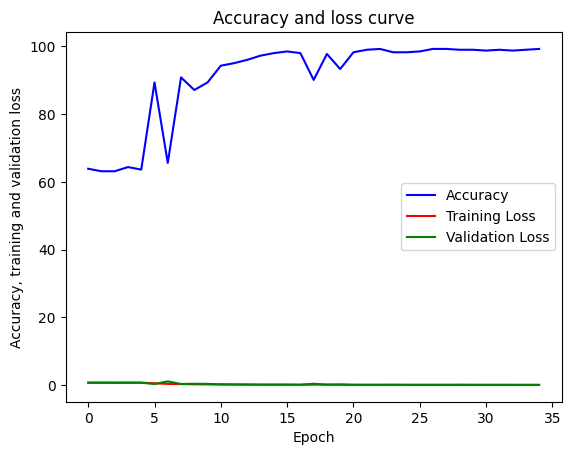

In [ ]:
plt.plot(epochs, accs, label='Accuracy', color='b')  # Plot first curve in blue
plt.plot(epochs, losses, label='Training Loss', color='r')  # Plot second curve in red
plt.plot(epochs, val_losses, label='Validation Loss', color='g')  # Plot second curve in red

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy, training and validation loss')
plt.title('Accuracy and loss curve')

# Show the legend
plt.legend()

# Display the plot
plt.show()

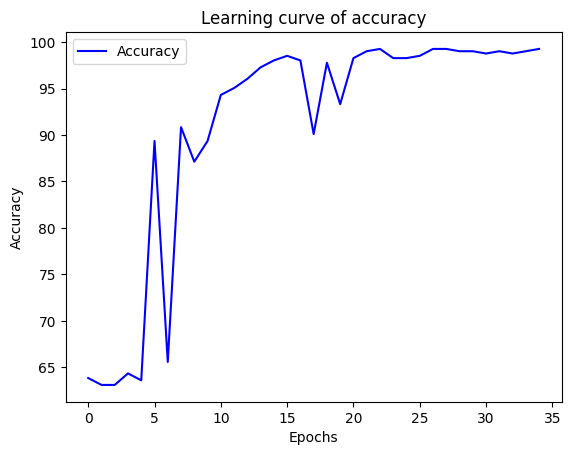

In [ ]:
plt.plot(epochs, accs, label='Accuracy', color='b')  # Plot first curve in blue

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning curve of accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()

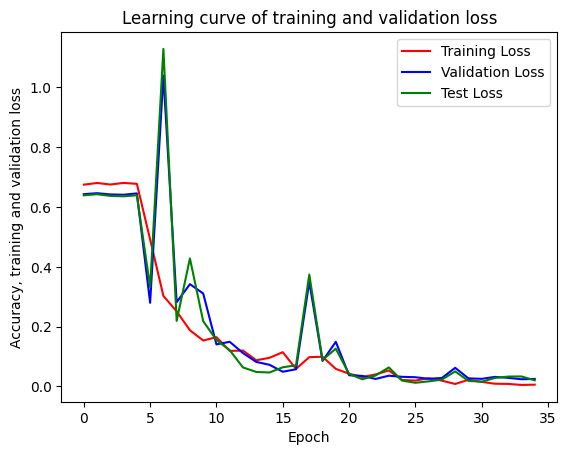

In [ ]:
plt.plot(epochs, losses, label='Training Loss', color='r')  # Plot second curve in red
plt.plot(epochs, val_losses, label='Validation Loss', color='b')  # Plot second curve in red
plt.plot(epochs, test_losses, label='Test Loss', color='g')  # Plot second curve in red

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy, training and validation loss')
plt.title('Learning curve of training and validation loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

# Fine-grained Pruning

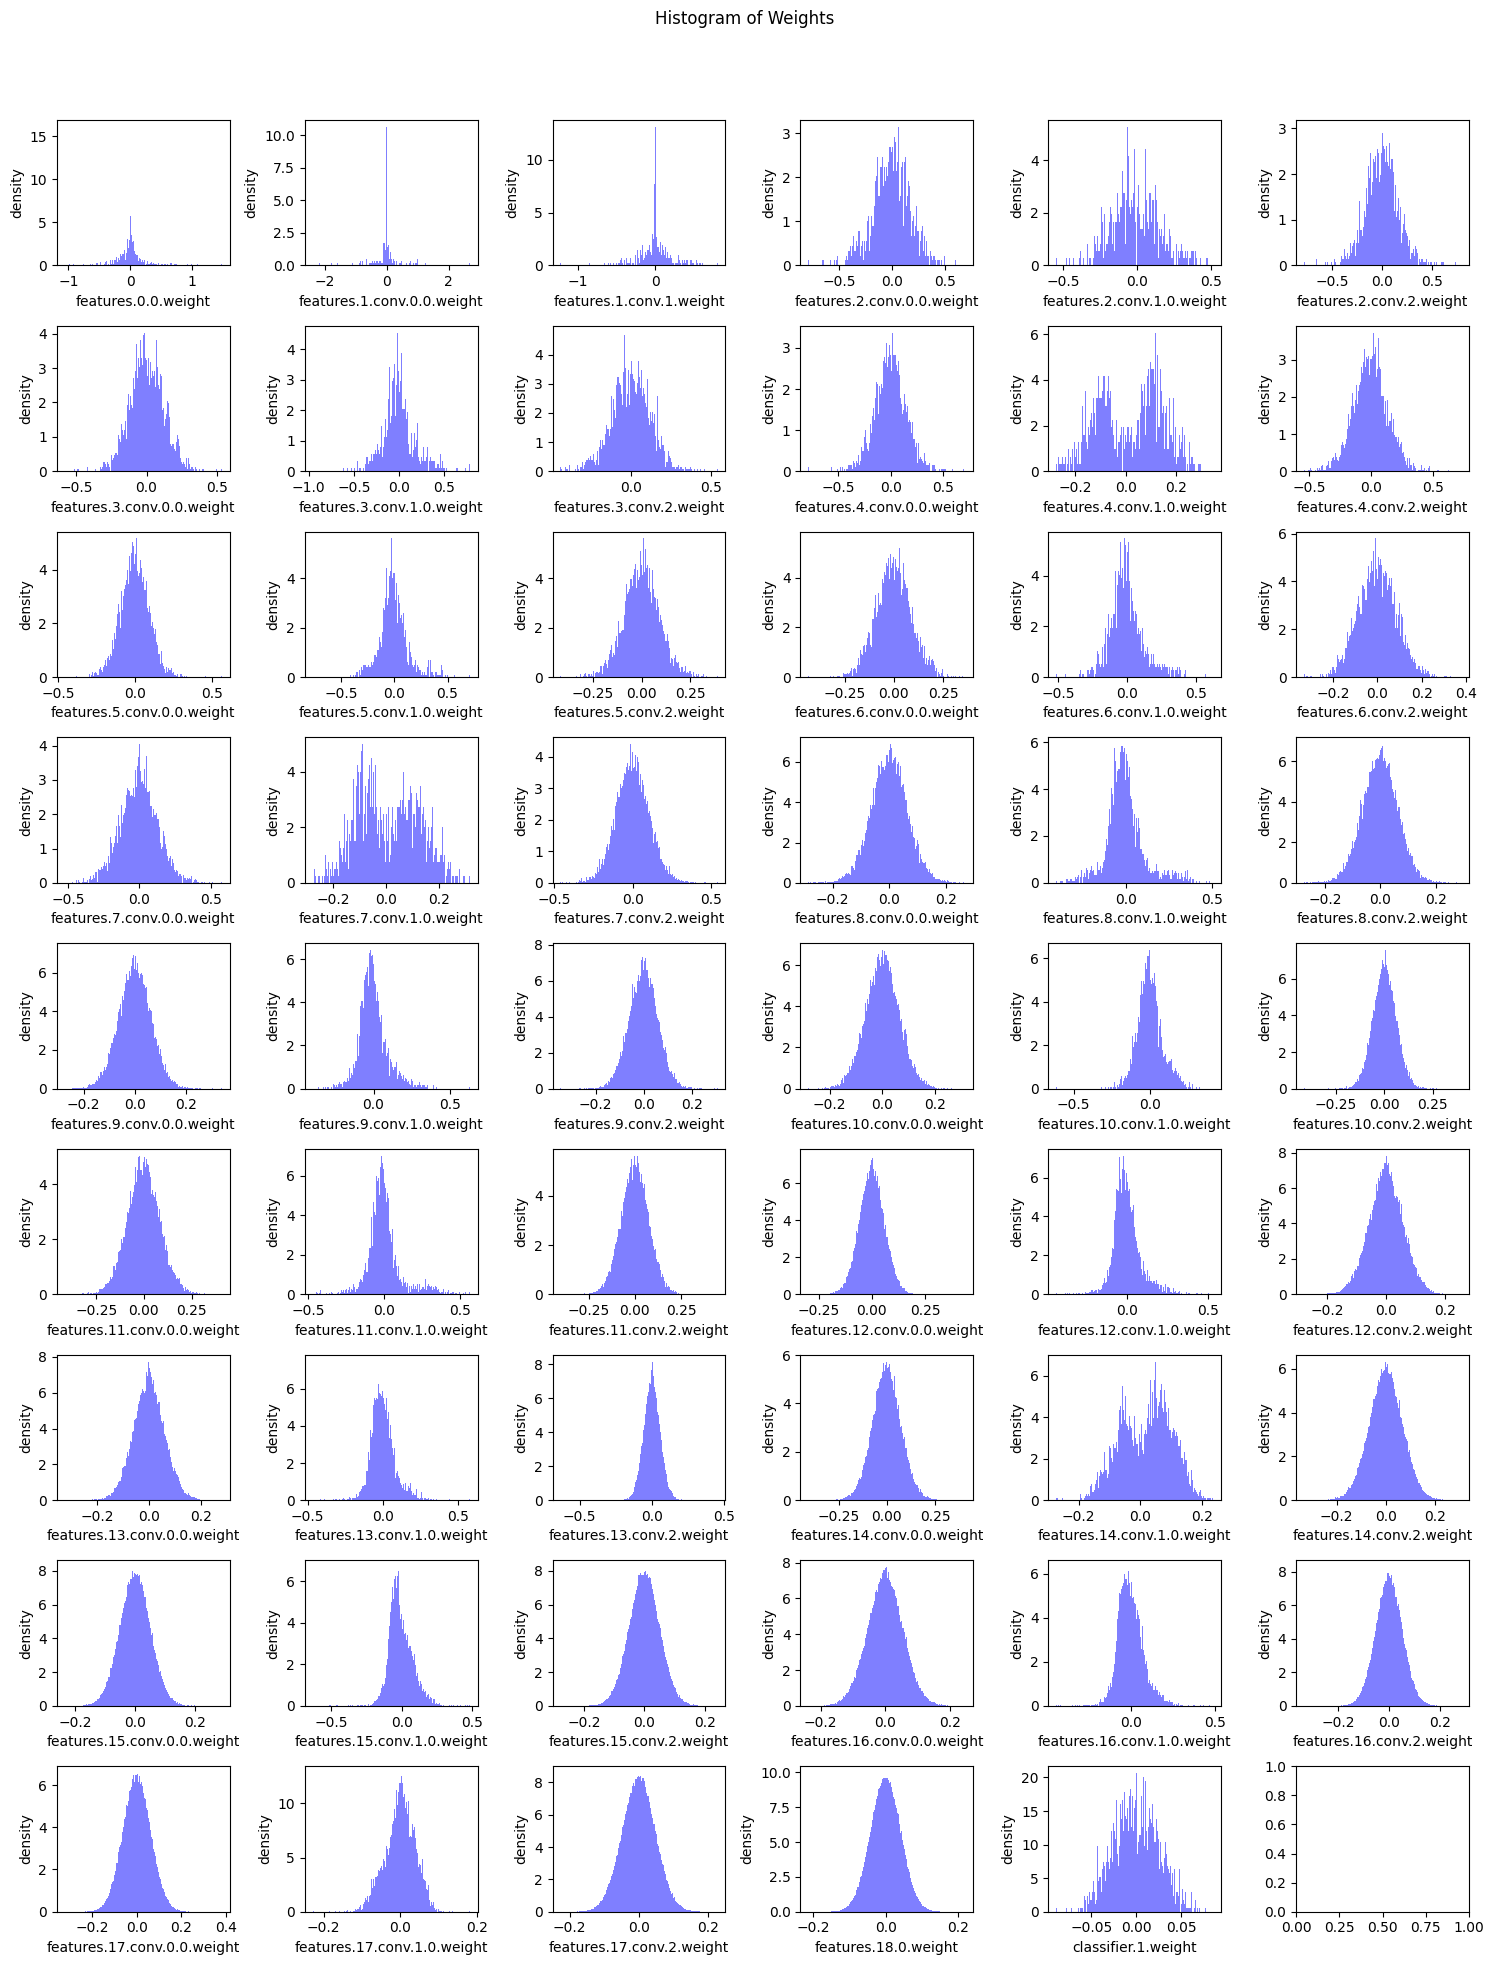

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(9,6, figsize=(15, 20))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

Define misc functions for verification.

In [ ]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    #fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.

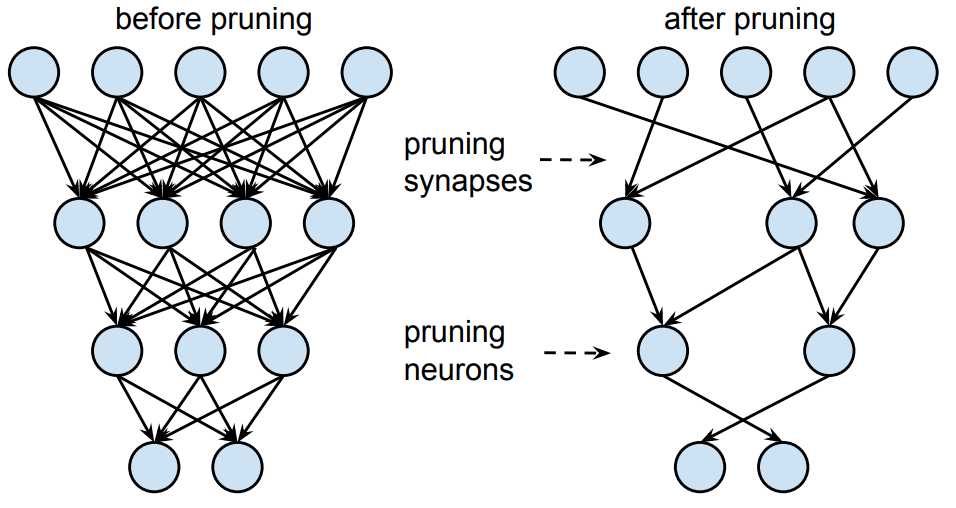

## Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

Please complete the following magnitude-based fine-grained pruning function.

**Hint**:
*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [ ]:
sparsity = min(max(0.0, 0.75), 1.0)

TypeError: 'Tensor' object is not callable

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements*sparsity)
    print(num_zeros)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    print(importance)
    # Step 3: calculate the pruning threshold
    threshold,ind=  torch.kthvalue(torch.abs(tensor.view(-1)), num_zeros)
    print(threshold)
    # Step 4: calculate the pruning mask
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance.gt(threshold)
    print(mask)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

Let's verify the functionality of defined fine-grained pruning by applying the function above on a dummy tensor.

### Test pruning fuction





The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

TypeError: 'Tensor' object is not callable

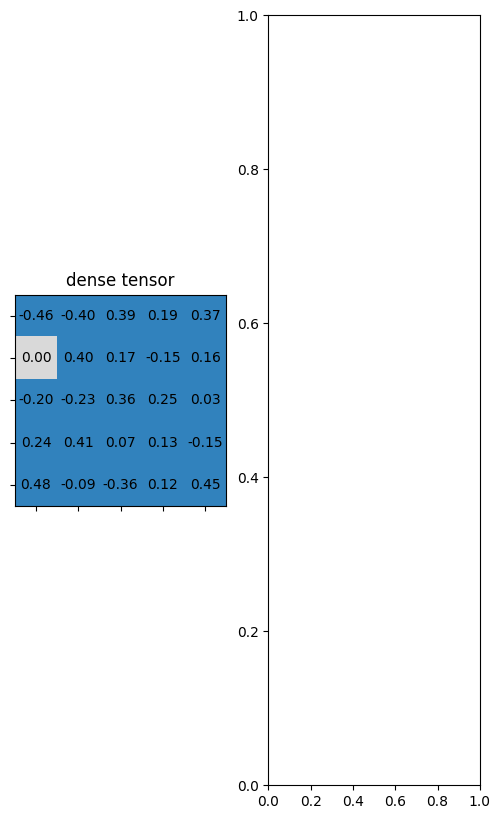

In [ ]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = .75 # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=6)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


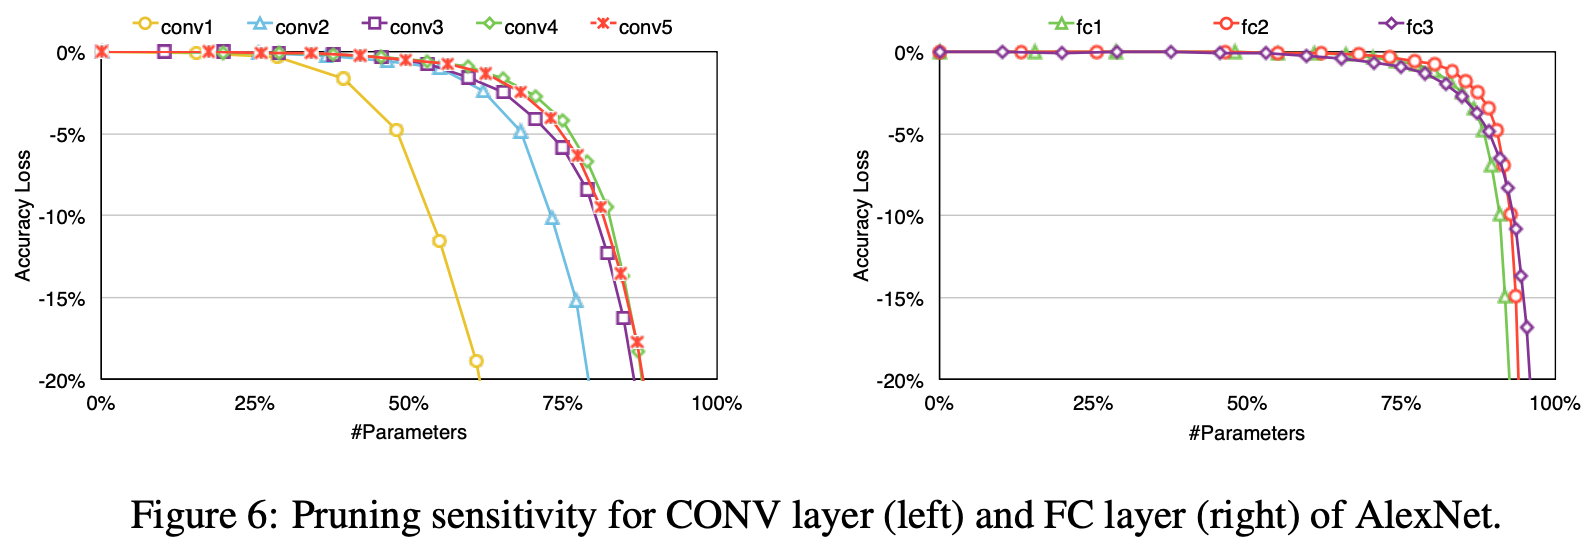

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc,_ = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

Please run the following cells to plot the sensitivity curves. It should take around 2 minutes to finish.

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['val'], scan_step=0.1, scan_start=0.1, scan_end=1.0)

scanning 0/53 weight - features.0.0.weight:   0%|          | 0/9 [00:00<?, ?it/s]

TypeError: 'Tensor' object is not callable

IndexError: index 21 is out of bounds for axis 0 with size 21

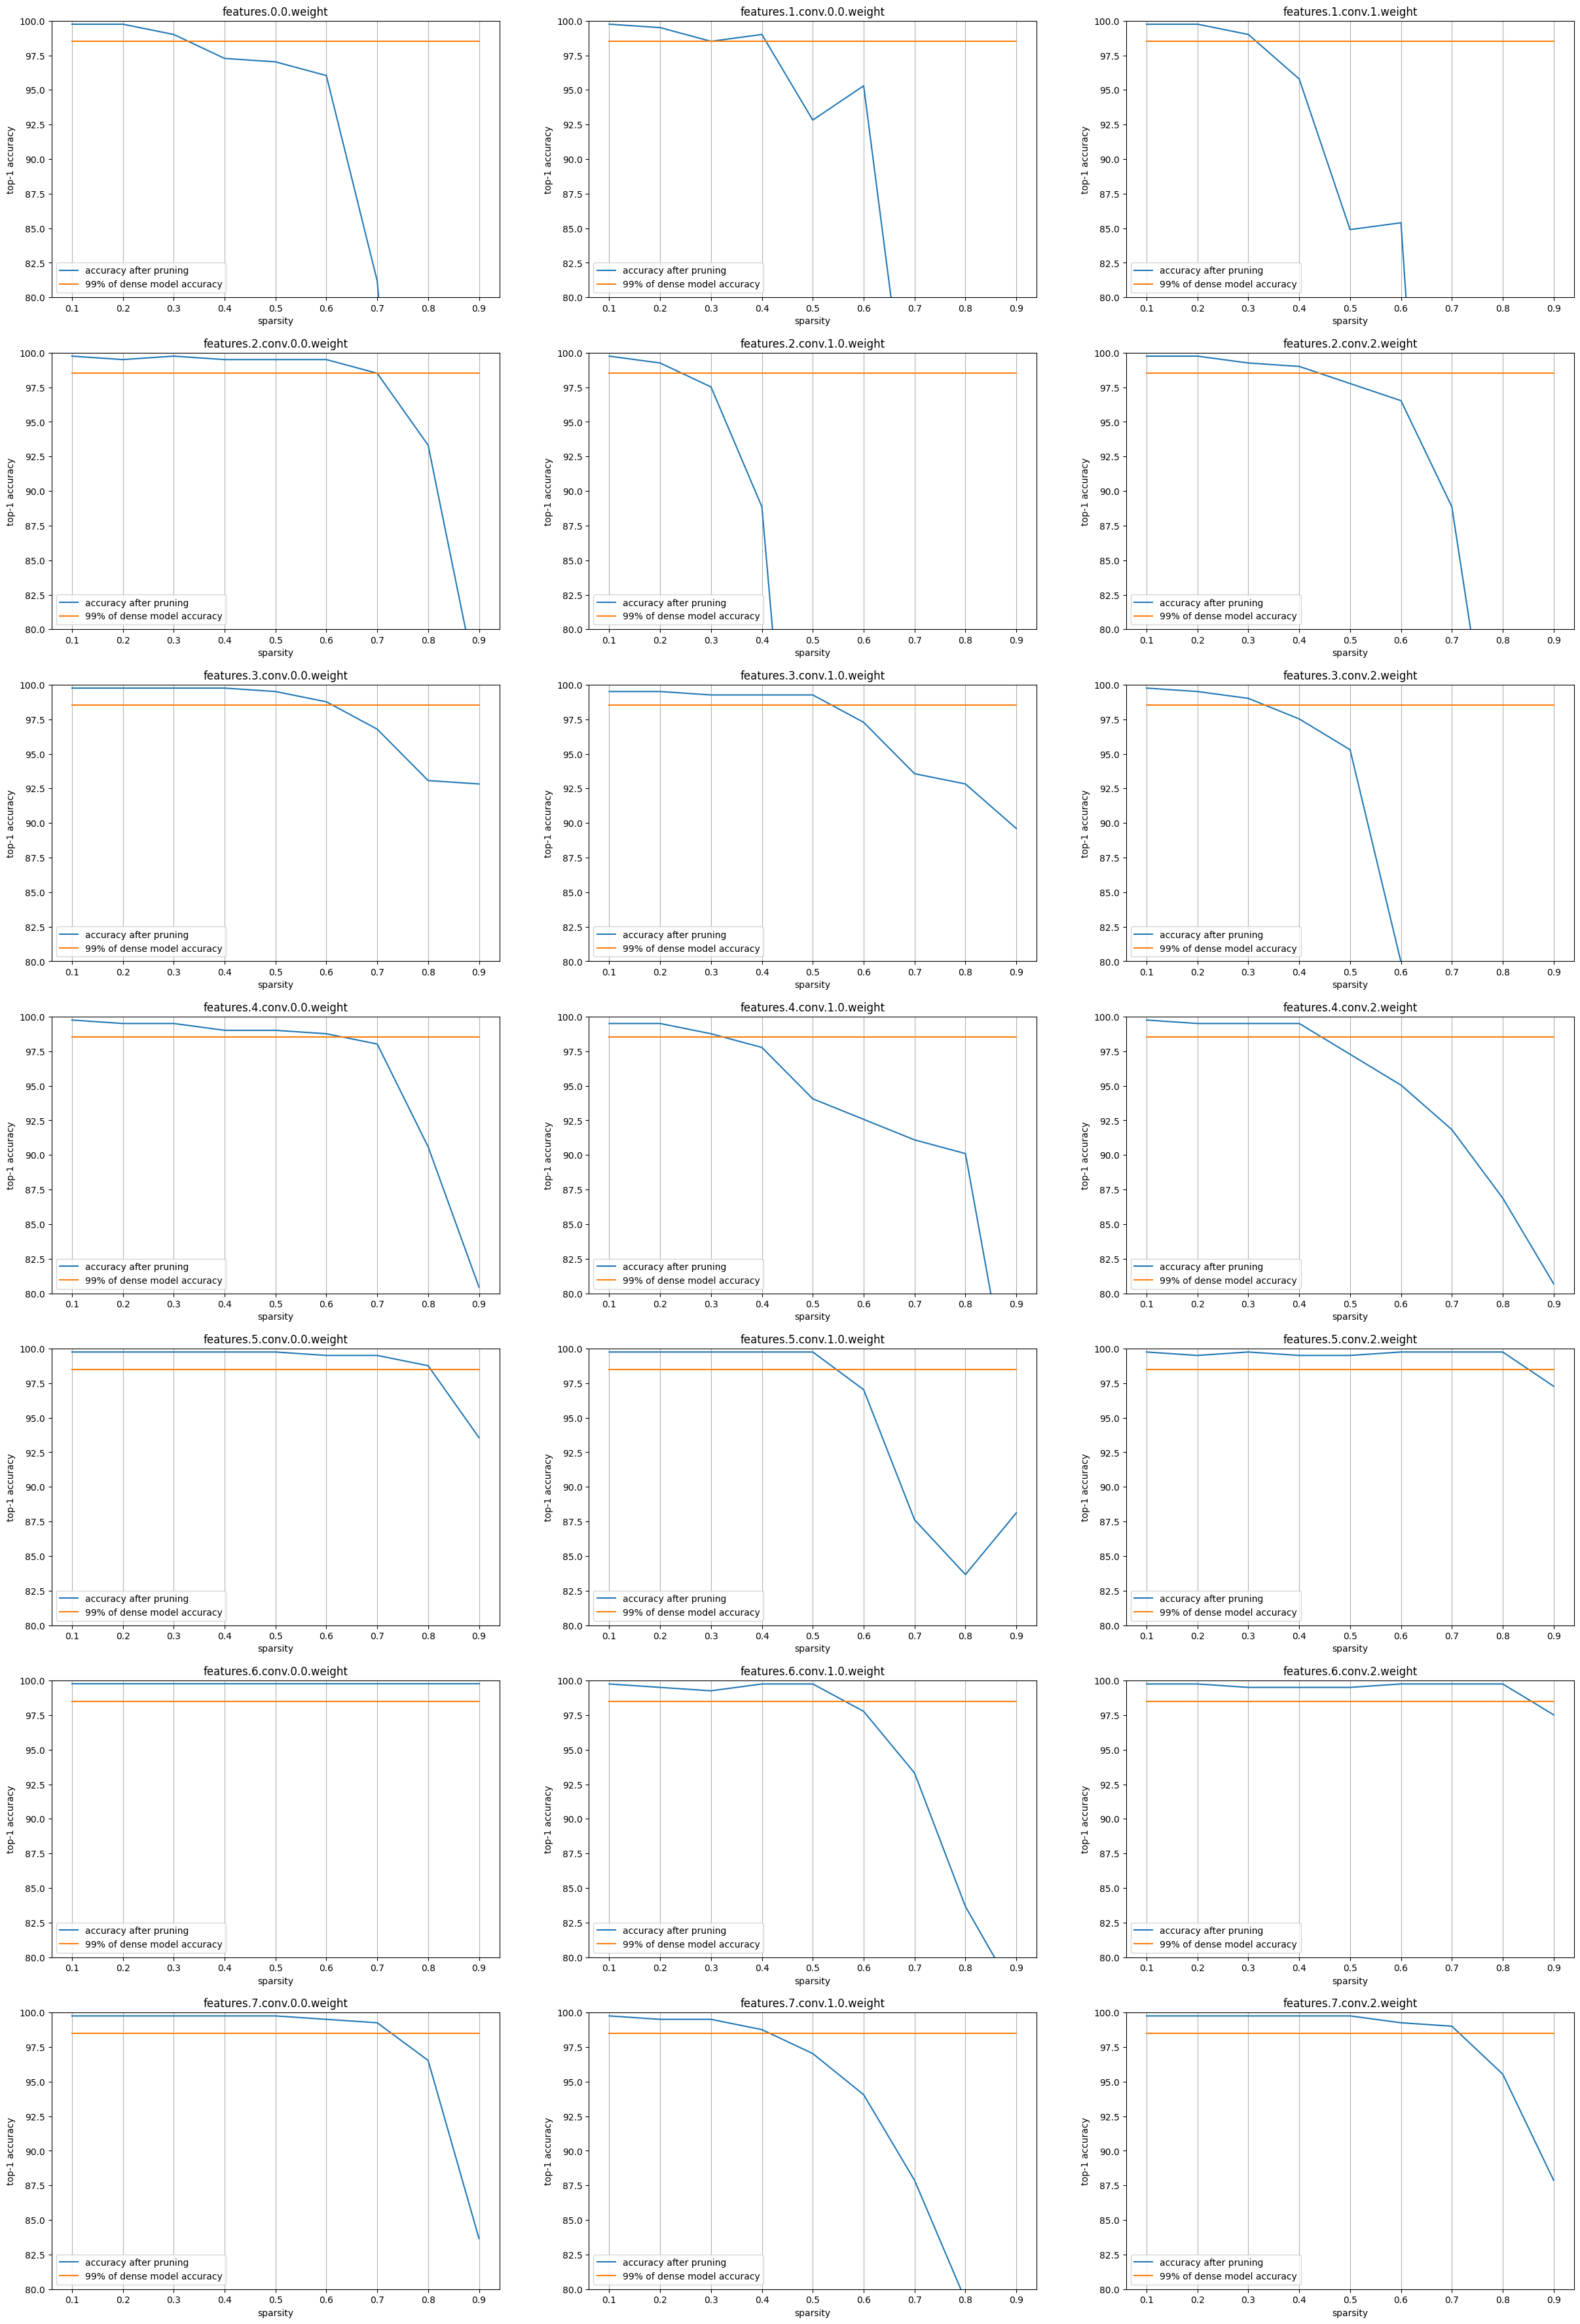

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(7, 3,figsize=(30,45))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.1, stop=1.0, step=0.1))
            ax.set_ylim(80, 100)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

#### Important points

* The relationship between pruning sparsity and model accuracy (*i.e.*, does accuracy increase or decrease when sparsity becomes higher?)

* All the layers does not have the same sensitivity

* Layer with less parameters is the most sensitive to the pruning sparsity

* In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

In [ ]:
thrshold=[]
t=90
for acc in accuracies:
  tn = torch.tensor(acc)
  bin=tn>t
  thrshold.append(int(torch.nonzero(bin)[-1])*.1)
thrshold

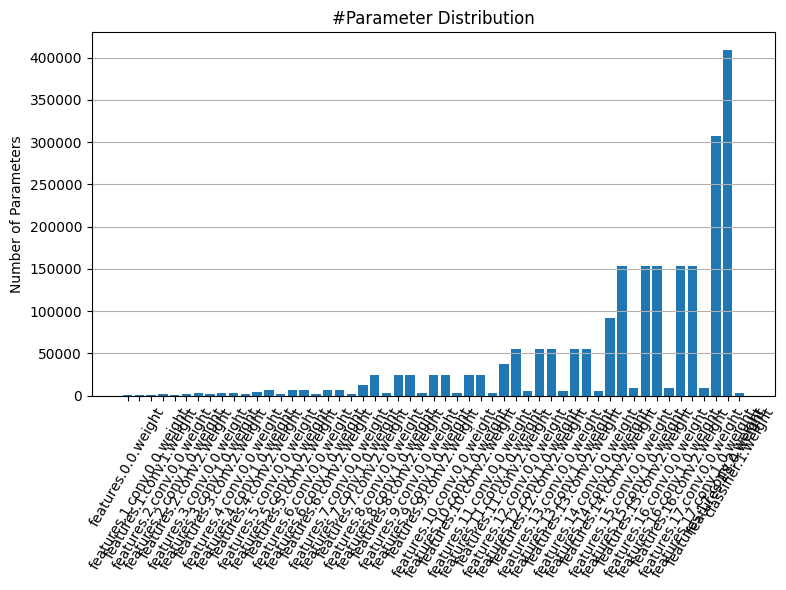

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution





Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.
:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [ ]:
evaluate(model, dataloader["val"])

eval:   0%|          | 0/13 [00:00<?, ?it/s]

(99.75247192382812, 0.0)

In [ ]:
print(thrshold)

[0.5, 0.5, 0.30000000000000004, 0.7000000000000001, 0.2, 0.5, 0.8, 0.7000000000000001, 0.4, 0.7000000000000001, 0.7000000000000001, 0.6000000000000001, 0.8, 0.5, 0.8, 0.8, 0.6000000000000001, 0.8, 0.7000000000000001, 0.5, 0.7000000000000001, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7000000000000001, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]


In [ ]:
i=0
for name, parameter in model.named_parameters():
    if parameter.dim() > 1:
        print(f"'{name}': {thrshold[i]},")
        i+=1


'features.0.0.weight': 0.5,
'features.1.conv.0.0.weight': 0.5,
'features.1.conv.1.weight': 0.30000000000000004,
'features.2.conv.0.0.weight': 0.7000000000000001,
'features.2.conv.1.0.weight': 0.2,
'features.2.conv.2.weight': 0.5,
'features.3.conv.0.0.weight': 0.8,
'features.3.conv.1.0.weight': 0.7000000000000001,
'features.3.conv.2.weight': 0.4,
'features.4.conv.0.0.weight': 0.7000000000000001,
'features.4.conv.1.0.weight': 0.7000000000000001,
'features.4.conv.2.weight': 0.6000000000000001,
'features.5.conv.0.0.weight': 0.8,
'features.5.conv.1.0.weight': 0.5,
'features.5.conv.2.weight': 0.8,
'features.6.conv.0.0.weight': 0.8,
'features.6.conv.1.0.weight': 0.6000000000000001,
'features.6.conv.2.weight': 0.8,
'features.7.conv.0.0.weight': 0.7000000000000001,
'features.7.conv.1.0.weight': 0.5,
'features.7.conv.2.weight': 0.7000000000000001,
'features.8.conv.0.0.weight': 0.8,
'features.8.conv.1.0.weight': 0.8,
'features.8.conv.2.weight': 0.8,
'features.9.conv.0.0.weight': 0.8,
'features.9.

In [ ]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
'features.0.0.weight': 0.5,
'features.1.conv.0.0.weight': 0.5,
'features.1.conv.1.weight': 0.30000000000000004,
'features.2.conv.0.0.weight': 0.7000000000000001,
'features.2.conv.1.0.weight': 0.2,
'features.2.conv.2.weight': 0.5,
'features.3.conv.0.0.weight': 0.8,
'features.3.conv.1.0.weight': 0.7000000000000001,
'features.3.conv.2.weight': 0.4,
'features.4.conv.0.0.weight': 0.7000000000000001,
'features.4.conv.1.0.weight': 0.7000000000000001,
'features.4.conv.2.weight': 0.6000000000000001,
'features.5.conv.0.0.weight': 0.8,
'features.5.conv.1.0.weight': 0.5,
'features.5.conv.2.weight': 0.8,
'features.6.conv.0.0.weight': 0.8,
'features.6.conv.1.0.weight': 0.6000000000000001,
'features.6.conv.2.weight': 0.8,
'features.7.conv.0.0.weight': 0.7000000000000001,
'features.7.conv.1.0.weight': 0.5,
'features.7.conv.2.weight': 0.7000000000000001,
'features.8.conv.0.0.weight': 0.8,
'features.8.conv.1.0.weight': 0.8,
'features.8.conv.2.weight': 0.8,
'features.9.conv.0.0.weight': 0.8,
'features.9.conv.1.0.weight': 0.8,
'features.9.conv.2.weight': 0.8,
'features.10.conv.0.0.weight': 0.8,
'features.10.conv.1.0.weight': 0.8,
'features.10.conv.2.weight': 0.8,
'features.11.conv.0.0.weight': 0.8,
'features.11.conv.1.0.weight': 0.8,
'features.11.conv.2.weight': 0.8,
'features.12.conv.0.0.weight': 0.8,
'features.12.conv.1.0.weight': 0.8,
'features.12.conv.2.weight': 0.8,
'features.13.conv.0.0.weight': 0.8,
'features.13.conv.1.0.weight': 0.8,
'features.13.conv.2.weight': 0.8,
'features.14.conv.0.0.weight': 0.8,
'features.14.conv.1.0.weight': 0.7000000000000001,
'features.14.conv.2.weight': 0.8,
'features.15.conv.0.0.weight': 0.8,
'features.15.conv.1.0.weight': 0.8,
'features.15.conv.2.weight': 0.8,
'features.16.conv.0.0.weight': 0.8,
'features.16.conv.1.0.weight': 0.8,
'features.16.conv.2.weight': 0.8,
'features.17.conv.0.0.weight': 0.8,
'features.17.conv.1.0.weight': 0.8,
'features.17.conv.2.weight': 0.8,
'features.18.0.weight': 0.8,
'classifier.1.weight': 0.8,
      ##################### YOUR CODE ENDS HERE #######################
}

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.0.1.num_batches_tracked", "features.1.conv.0.0.weight", "features.1.conv.0.1.weight", "features.1.conv.0.1.bias", "features.1.conv.0.1.running_mean", "features.1.conv.0.1.running_var", "features.1.conv.0.1.num_batches_tracked", "features.1.conv.1.weight", "features.1.conv.2.weight", "features.1.conv.2.bias", "features.1.conv.2.running_mean", "features.1.conv.2.running_var", "features.1.conv.2.num_batches_tracked", "features.2.conv.0.0.weight", "features.2.conv.0.1.weight", "features.2.conv.0.1.bias", "features.2.conv.0.1.running_mean", "features.2.conv.0.1.running_var", "features.2.conv.0.1.num_batches_tracked", "features.2.conv.1.0.weight", "features.2.conv.1.1.weight", "features.2.conv.1.1.bias", "features.2.conv.1.1.running_mean", "features.2.conv.1.1.running_var", "features.2.conv.1.1.num_batches_tracked", "features.2.conv.2.weight", "features.2.conv.3.weight", "features.2.conv.3.bias", "features.2.conv.3.running_mean", "features.2.conv.3.running_var", "features.2.conv.3.num_batches_tracked", "features.3.conv.0.0.weight", "features.3.conv.0.1.weight", "features.3.conv.0.1.bias", "features.3.conv.0.1.running_mean", "features.3.conv.0.1.running_var", "features.3.conv.0.1.num_batches_tracked", "features.3.conv.1.0.weight", "features.3.conv.1.1.weight", "features.3.conv.1.1.bias", "features.3.conv.1.1.running_mean", "features.3.conv.1.1.running_var", "features.3.conv.1.1.num_batches_tracked", "features.3.conv.2.weight", "features.3.conv.3.weight", "features.3.conv.3.bias", "features.3.conv.3.running_mean", "features.3.conv.3.running_var", "features.3.conv.3.num_batches_tracked", "features.4.conv.0.0.weight", "features.4.conv.0.1.weight", "features.4.conv.0.1.bias", "features.4.conv.0.1.running_mean", "features.4.conv.0.1.running_var", "features.4.conv.0.1.num_batches_tracked", "features.4.conv.1.0.weight", "features.4.conv.1.1.weight", "features.4.conv.1.1.bias", "features.4.conv.1.1.running_mean", "features.4.conv.1.1.running_var", "features.4.conv.1.1.num_batches_tracked", "features.4.conv.2.weight", "features.4.conv.3.weight", "features.4.conv.3.bias", "features.4.conv.3.running_mean", "features.4.conv.3.running_var", "features.4.conv.3.num_batches_tracked", "features.5.conv.0.0.weight", "features.5.conv.0.1.weight", "features.5.conv.0.1.bias", "features.5.conv.0.1.running_mean", "features.5.conv.0.1.running_var", "features.5.conv.0.1.num_batches_tracked", "features.5.conv.1.0.weight", "features.5.conv.1.1.weight", "features.5.conv.1.1.bias", "features.5.conv.1.1.running_mean", "features.5.conv.1.1.running_var", "features.5.conv.1.1.num_batches_tracked", "features.5.conv.2.weight", "features.5.conv.3.weight", "features.5.conv.3.bias", "features.5.conv.3.running_mean", "features.5.conv.3.running_var", "features.5.conv.3.num_batches_tracked", "features.6.conv.0.0.weight", "features.6.conv.0.1.weight", "features.6.conv.0.1.bias", "features.6.conv.0.1.running_mean", "features.6.conv.0.1.running_var", "features.6.conv.0.1.num_batches_tracked", "features.6.conv.1.0.weight", "features.6.conv.1.1.weight", "features.6.conv.1.1.bias", "features.6.conv.1.1.running_mean", "features.6.conv.1.1.running_var", "features.6.conv.1.1.num_batches_tracked", "features.6.conv.2.weight", "features.6.conv.3.weight", "features.6.conv.3.bias", "features.6.conv.3.running_mean", "features.6.conv.3.running_var", "features.6.conv.3.num_batches_tracked", "features.7.conv.0.0.weight", "features.7.conv.0.1.weight", "features.7.conv.0.1.bias", "features.7.conv.0.1.running_mean", "features.7.conv.0.1.running_var", "features.7.conv.0.1.num_batches_tracked", "features.7.conv.1.0.weight", "features.7.conv.1.1.weight", "features.7.conv.1.1.bias", "features.7.conv.1.1.running_mean", "features.7.conv.1.1.running_var", "features.7.conv.1.1.num_batches_tracked", "features.7.conv.2.weight", "features.7.conv.3.weight", "features.7.conv.3.bias", "features.7.conv.3.running_mean", "features.7.conv.3.running_var", "features.7.conv.3.num_batches_tracked", "features.8.conv.0.0.weight", "features.8.conv.0.1.weight", "features.8.conv.0.1.bias", "features.8.conv.0.1.running_mean", "features.8.conv.0.1.running_var", "features.8.conv.0.1.num_batches_tracked", "features.8.conv.1.0.weight", "features.8.conv.1.1.weight", "features.8.conv.1.1.bias", "features.8.conv.1.1.running_mean", "features.8.conv.1.1.running_var", "features.8.conv.1.1.num_batches_tracked", "features.8.conv.2.weight", "features.8.conv.3.weight", "features.8.conv.3.bias", "features.8.conv.3.running_mean", "features.8.conv.3.running_var", "features.8.conv.3.num_batches_tracked", "features.9.conv.0.0.weight", "features.9.conv.0.1.weight", "features.9.conv.0.1.bias", "features.9.conv.0.1.running_mean", "features.9.conv.0.1.running_var", "features.9.conv.0.1.num_batches_tracked", "features.9.conv.1.0.weight", "features.9.conv.1.1.weight", "features.9.conv.1.1.bias", "features.9.conv.1.1.running_mean", "features.9.conv.1.1.running_var", "features.9.conv.1.1.num_batches_tracked", "features.9.conv.2.weight", "features.9.conv.3.weight", "features.9.conv.3.bias", "features.9.conv.3.running_mean", "features.9.conv.3.running_var", "features.9.conv.3.num_batches_tracked", "features.10.conv.0.0.weight", "features.10.conv.0.1.weight", "features.10.conv.0.1.bias", "features.10.conv.0.1.running_mean", "features.10.conv.0.1.running_var", "features.10.conv.0.1.num_batches_tracked", "features.10.conv.1.0.weight", "features.10.conv.1.1.weight", "features.10.conv.1.1.bias", "features.10.conv.1.1.running_mean", "features.10.conv.1.1.running_var", "features.10.conv.1.1.num_batches_tracked", "features.10.conv.2.weight", "features.10.conv.3.weight", "features.10.conv.3.bias", "features.10.conv.3.running_mean", "features.10.conv.3.running_var", "features.10.conv.3.num_batches_tracked", "features.11.conv.0.0.weight", "features.11.conv.0.1.weight", "features.11.conv.0.1.bias", "features.11.conv.0.1.running_mean", "features.11.conv.0.1.running_var", "features.11.conv.0.1.num_batches_tracked", "features.11.conv.1.0.weight", "features.11.conv.1.1.weight", "features.11.conv.1.1.bias", "features.11.conv.1.1.running_mean", "features.11.conv.1.1.running_var", "features.11.conv.1.1.num_batches_tracked", "features.11.conv.2.weight", "features.11.conv.3.weight", "features.11.conv.3.bias", "features.11.conv.3.running_mean", "features.11.conv.3.running_var", "features.11.conv.3.num_batches_tracked", "features.12.conv.0.0.weight", "features.12.conv.0.1.weight", "features.12.conv.0.1.bias", "features.12.conv.0.1.running_mean", "features.12.conv.0.1.running_var", "features.12.conv.0.1.num_batches_tracked", "features.12.conv.1.0.weight", "features.12.conv.1.1.weight", "features.12.conv.1.1.bias", "features.12.conv.1.1.running_mean", "features.12.conv.1.1.running_var", "features.12.conv.1.1.num_batches_tracked", "features.12.conv.2.weight", "features.12.conv.3.weight", "features.12.conv.3.bias", "features.12.conv.3.running_mean", "features.12.conv.3.running_var", "features.12.conv.3.num_batches_tracked", "features.13.conv.0.0.weight", "features.13.conv.0.1.weight", "features.13.conv.0.1.bias", "features.13.conv.0.1.running_mean", "features.13.conv.0.1.running_var", "features.13.conv.0.1.num_batches_tracked", "features.13.conv.1.0.weight", "features.13.conv.1.1.weight", "features.13.conv.1.1.bias", "features.13.conv.1.1.running_mean", "features.13.conv.1.1.running_var", "features.13.conv.1.1.num_batches_tracked", "features.13.conv.2.weight", "features.13.conv.3.weight", "features.13.conv.3.bias", "features.13.conv.3.running_mean", "features.13.conv.3.running_var", "features.13.conv.3.num_batches_tracked", "features.14.conv.0.0.weight", "features.14.conv.0.1.weight", "features.14.conv.0.1.bias", "features.14.conv.0.1.running_mean", "features.14.conv.0.1.running_var", "features.14.conv.0.1.num_batches_tracked", "features.14.conv.1.0.weight", "features.14.conv.1.1.weight", "features.14.conv.1.1.bias", "features.14.conv.1.1.running_mean", "features.14.conv.1.1.running_var", "features.14.conv.1.1.num_batches_tracked", "features.14.conv.2.weight", "features.14.conv.3.weight", "features.14.conv.3.bias", "features.14.conv.3.running_mean", "features.14.conv.3.running_var", "features.14.conv.3.num_batches_tracked", "features.15.conv.0.0.weight", "features.15.conv.0.1.weight", "features.15.conv.0.1.bias", "features.15.conv.0.1.running_mean", "features.15.conv.0.1.running_var", "features.15.conv.0.1.num_batches_tracked", "features.15.conv.1.0.weight", "features.15.conv.1.1.weight", "features.15.conv.1.1.bias", "features.15.conv.1.1.running_mean", "features.15.conv.1.1.running_var", "features.15.conv.1.1.num_batches_tracked", "features.15.conv.2.weight", "features.15.conv.3.weight", "features.15.conv.3.bias", "features.15.conv.3.running_mean", "features.15.conv.3.running_var", "features.15.conv.3.num_batches_tracked", "features.16.conv.0.0.weight", "features.16.conv.0.1.weight", "features.16.conv.0.1.bias", "features.16.conv.0.1.running_mean", "features.16.conv.0.1.running_var", "features.16.conv.0.1.num_batches_tracked", "features.16.conv.1.0.weight", "features.16.conv.1.1.weight", "features.16.conv.1.1.bias", "features.16.conv.1.1.running_mean", "features.16.conv.1.1.running_var", "features.16.conv.1.1.num_batches_tracked", "features.16.conv.2.weight", "features.16.conv.3.weight", "features.16.conv.3.bias", "features.16.conv.3.running_mean", "features.16.conv.3.running_var", "features.16.conv.3.num_batches_tracked", "features.17.conv.0.0.weight", "features.17.conv.0.1.weight", "features.17.conv.0.1.bias", "features.17.conv.0.1.running_mean", "features.17.conv.0.1.running_var", "features.17.conv.0.1.num_batches_tracked", "features.17.conv.1.0.weight", "features.17.conv.1.1.weight", "features.17.conv.1.1.bias", "features.17.conv.1.1.running_mean", "features.17.conv.1.1.running_var", "features.17.conv.1.1.num_batches_tracked", "features.17.conv.2.weight", "features.17.conv.3.weight", "features.17.conv.3.bias", "features.17.conv.3.running_mean", "features.17.conv.3.running_var", "features.17.conv.3.num_batches_tracked", "features.18.0.weight", "features.18.1.weight", "features.18.1.bias", "features.18.1.running_mean", "features.18.1.running_var", "features.18.1.num_batches_tracked", "classifier.1.weight", "classifier.1.bias". 

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

In [ ]:
pruned_model=copy.deepcopy(model)

In [ ]:
pruner = FineGrainedPruner(pruned_model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in pruned_model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy,_ = evaluate(pruned_model, dataloader['val'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(pruned_model, count_nonzero_only=True)

Streaming output truncated to the last 5000 lines.
         [[False, False,  True],
          [False,  True, False],
          [False, False, False]],

         [[False,  True,  True],
          [False, False, False],
          [False, False, False]],

         ...,

         [[False, False,  True],
          [False, False, False],
          [False, False, False]],

         [[ True, False, False],
          [ True,  True,  True],
          [False, False,  True]],

         [[ True,  True,  True],
          [False,  True, False],
          [False,  True,  True]]],


        [[[ True, False, False],
          [False, False, False],
          [False, False, False]],

         [[ True,  True, False],
          [False, False, False],
          [False,  True, False]],

         [[False, False, False],
          [False, False, False],
          [False, False, False]],

         ...,

         [[ True,  True,  True],
          [ True,  True,  True],
          [False, False,  True]],

        

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Sparse model has accuracy=68.58% before fintuning


NameError: name 'plot_weight_distribution' is not defined

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [ ]:
num_finetune_epochs = 15
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train_loss=train(pruned_model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(pruned_model)])
    val_acc ,val_loss = evaluate(pruned_model, dataloader['val'],criterion)
    accuracy ,test_loss = evaluate(pruned_model, dataloader['test'],criterion)
    is_best = val_acc > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(pruned_model.state_dict())
        best_accuracy = val_acc
    print(f'    Epoch {epoch+1} Accuracy {val_acc:.2f}% / Best Accuracy: {best_accuracy:.2f}%, test accuracy:{accuracy:.2f} train loss: {train_loss:.4f}, val loss {val_loss:.4f}, test loss {test_loss:.4f}')

Finetuning Fine-grained Pruned Sparse Model


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 1 Accuracy 98.27% / Best Accuracy: 98.27%, test accuracy:97.01 train loss: 0.0571, val loss 0.0626, test loss 0.0735


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 2 Accuracy 98.27% / Best Accuracy: 98.27%, test accuracy:98.01 train loss: 0.0456, val loss 0.0543, test loss 0.0602


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 3 Accuracy 97.52% / Best Accuracy: 98.27%, test accuracy:97.51 train loss: 0.0523, val loss 0.0712, test loss 0.0653


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 4 Accuracy 98.02% / Best Accuracy: 98.27%, test accuracy:97.01 train loss: 0.0509, val loss 0.0595, test loss 0.0638


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7b9f160356c0>:   0%|          | 0/44 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

eval:   0%|          | 0/7 [00:00<?, ?it/s]

    Epoch 5 Accuracy 98.51% / Best Accuracy: 98.51%, test accuracy:98.51 train loss: 0.0532, val loss 0.0571, test loss 0.0549


Run the following cell to see the information of best finetuned sparse model.

In [ ]:
all_labels, all_preds,all_outputs,loss = get_labels_preds(pruned_model, dataloader["test"])
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
conf_matrix=confusion_matrix(all_labels, all_preds)
print(conf_matrix)

Precision: 0.9541, Recall: 0.9656, F1: 0.9595
[[ 60   2]
 [  5 132]]


In [ ]:
# load the best sparse model checkpoint to evaluate the final performance
pruned_model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

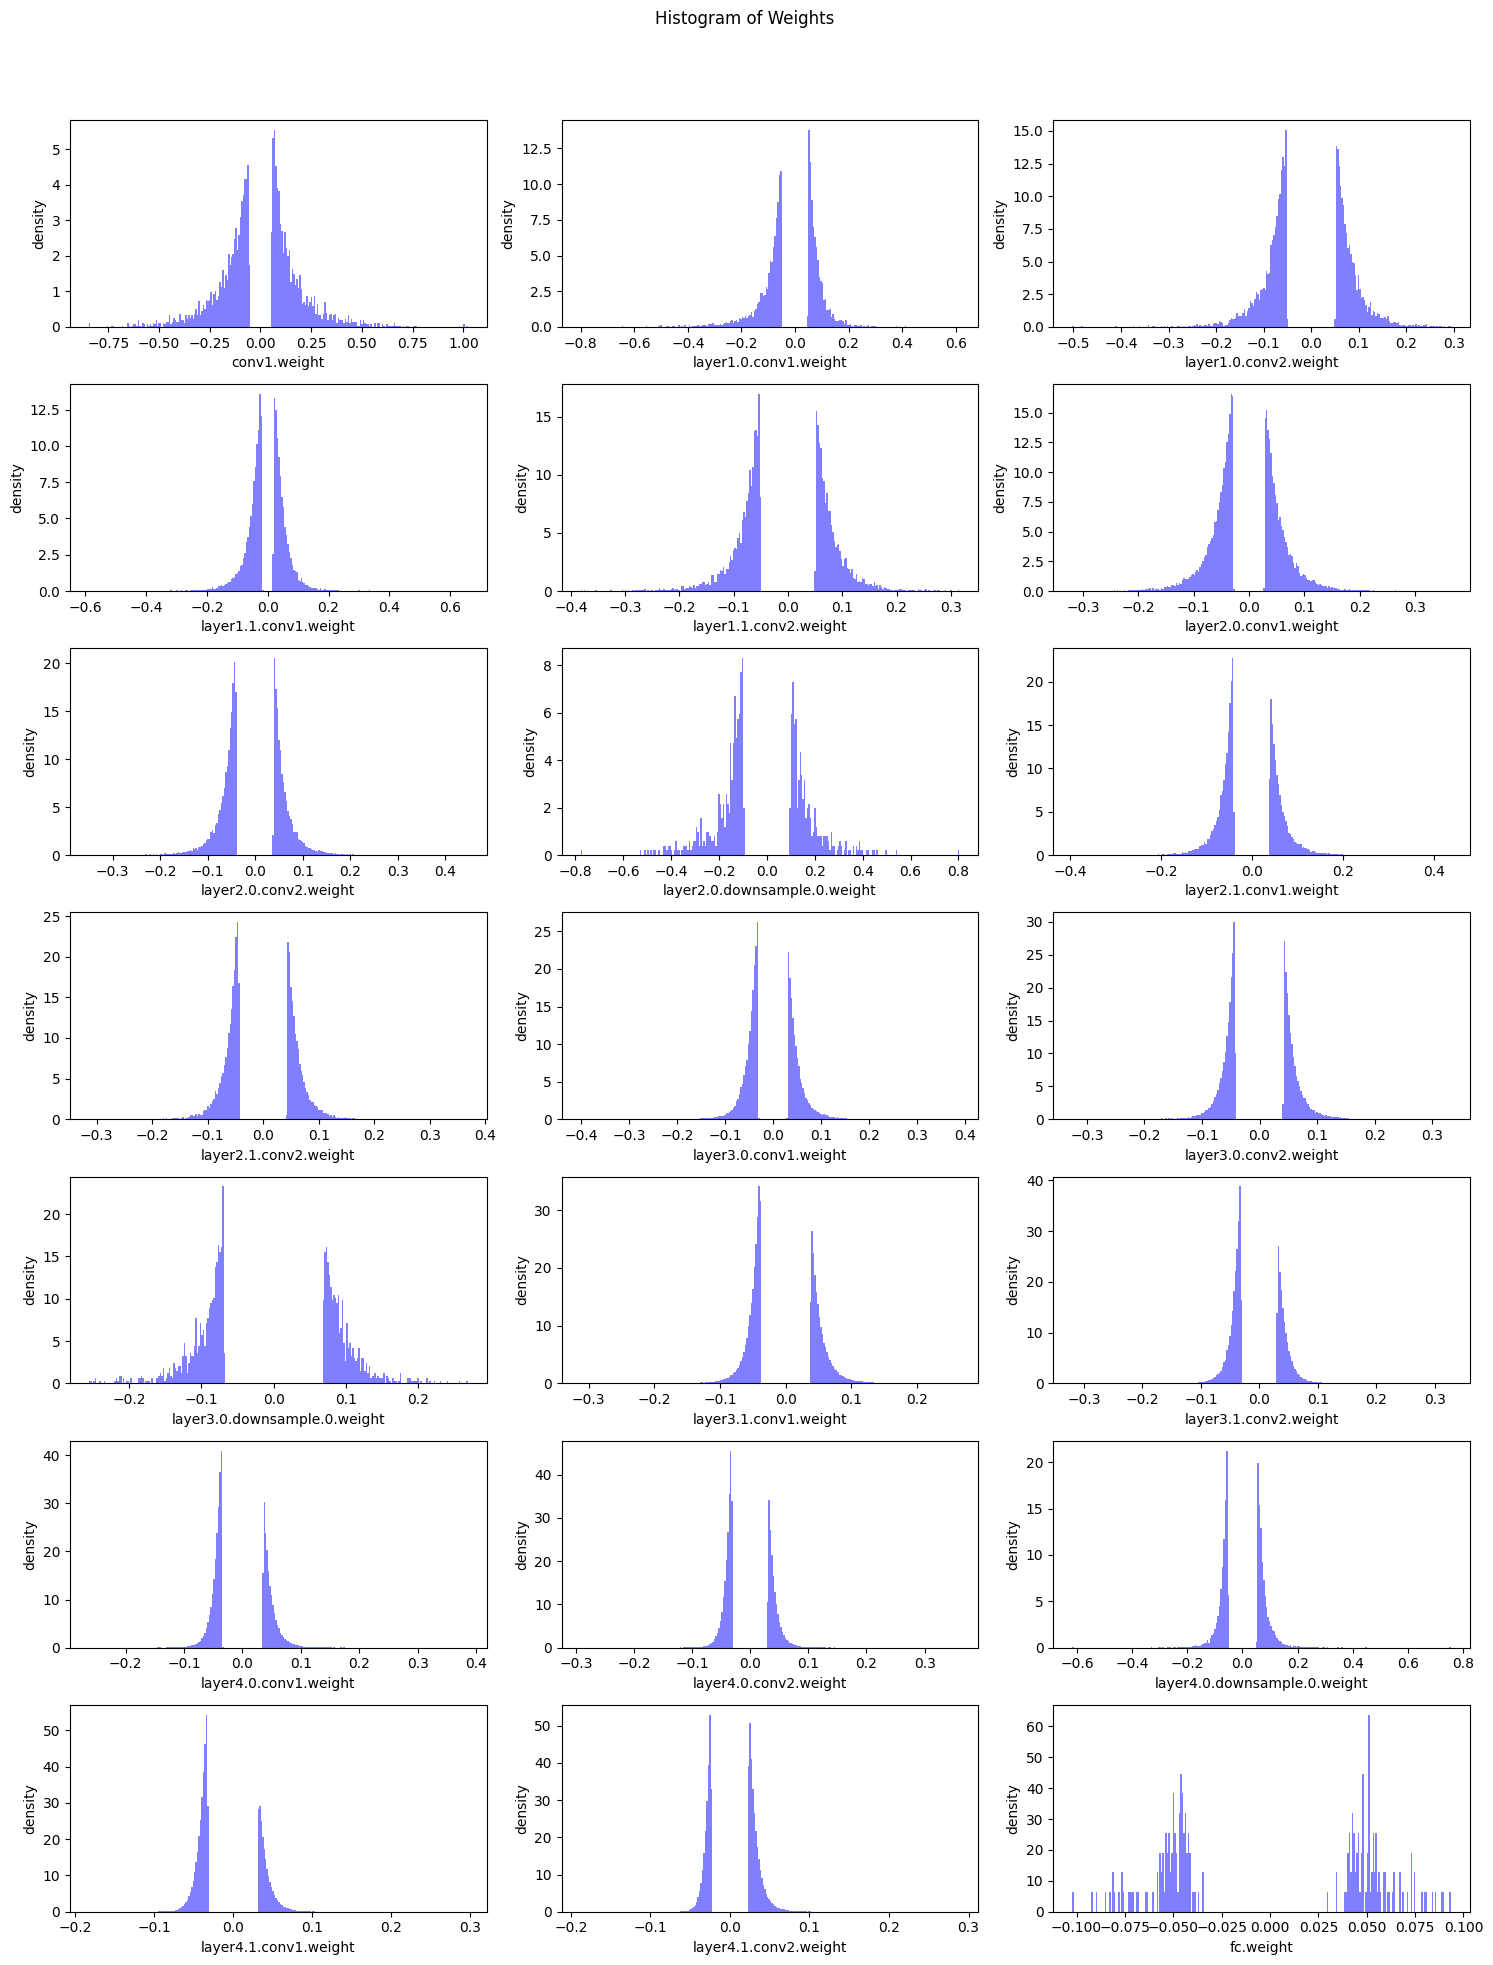

In [ ]:
plot_weight_distribution(pruned_model, count_nonzero_only=True)

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).cuda()
get_model_macs(pruned_model, dummy_input)

1816046592

In [ ]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 224, 224).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model,count_nonzero_only=True)
pruned_param = get_num_parameters(pruned_model,count_nonzero_only=True)
print(table_template.format('Param (M)',
                            round(int(original_param) / 1e6, 2),
                            round(int(pruned_param) / 1e6, 2),
                            round(int(original_param) / int(pruned_param), 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    55.2            63.6            0.9            
MACs (M)        1816            1816            1.0            
Param (M)       11.18           1.82            6.1            


# Channel Pruning

In this section, we will implement the channel pruning. Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm).

In [ ]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy,_ = evaluate(model, dataloader['val'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/14 [00:00<?, ?it/s]

dense model has accuracy=98.56%


## Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.


Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [ ]:
all_convs = [(name, layer) for name, layer in pruned_model.named_modules() if isinstance(layer, nn.Conv2d)]
all_bns = [(name, layer) for name, layer in pruned_model.named_modules() if isinstance(layer, nn.BatchNorm2d)]

for name, conv in all_convs:
  print(name, conv.weight.shape)

print()
for name, bn in all_bns:
  print(name, bn.weight.shape)

conv1 torch.Size([19, 3, 7, 7])
layer1.0.conv1 torch.Size([19, 19, 3, 3])
layer1.0.conv2 torch.Size([19, 19, 3, 3])
layer1.1.conv1 torch.Size([19, 19, 3, 3])
layer1.1.conv2 torch.Size([19, 19, 3, 3])
layer2.0.conv1 torch.Size([38, 19, 3, 3])
layer2.0.conv2 torch.Size([38, 38, 3, 3])
layer2.0.downsample.0 torch.Size([38, 19, 3, 3])
layer2.1.conv1 torch.Size([38, 38, 3, 3])
layer2.1.conv2 torch.Size([38, 38, 3, 3])
layer3.0.conv1 torch.Size([77, 38, 3, 3])
layer3.0.conv2 torch.Size([77, 77, 3, 3])
layer3.0.downsample.0 torch.Size([77, 38, 3, 3])
layer3.1.conv1 torch.Size([77, 77, 3, 3])
layer3.1.conv2 torch.Size([77, 77, 3, 3])
layer4.0.conv1 torch.Size([154, 77, 3, 3])
layer4.0.conv2 torch.Size([154, 154, 3, 3])
layer4.0.downsample.0 torch.Size([154, 77, 3, 3])
layer4.1.conv1 torch.Size([154, 154, 3, 3])
layer4.1.conv2 torch.Size([512, 154, 3, 3])

bn1 torch.Size([19])
layer1.0.bn1 torch.Size([19])
layer1.0.bn2 torch.Size([19])
layer1.1.bn1 torch.Size([19])
layer1.1.bn2 torch.Size([19])

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return round(channels*(1-prune_ratio))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([(name,layer) for name, layer in model.named_modules() if isinstance(layer, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [(name, layer) for name, layer in model.named_modules() if isinstance(layer, nn.Conv2d)]
    all_bns = [(name, layer) for name, layer in model.named_modules() if isinstance(layer, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        print(all_convs[i_ratio][0])
        if "downsample" in all_convs[i_ratio][0]:
          prev_conv = all_convs[i_ratio][1]
          prev_bn = all_bns[i_ratio][1]
          next_conv = all_convs[i_ratio + 1][1]
          original_channels = prev_conv.out_channels  # same as next_conv.in_channels
          n_keep = get_num_channels_to_keep(original_channels, p_ratio)
          print(prev_conv.weight.shape)
          # prune the output of the previous conv and bn
          prev_conv.weight.set_(prev_conv.weight.detach()[:,:n_keep//2])
          prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])

          prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
          prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
          prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
          prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])
          next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep])
        else:
          prev_conv = all_convs[i_ratio][1]
          prev_bn = all_bns[i_ratio][1]
          next_conv = all_convs[i_ratio + 1][1]
          original_channels = prev_conv.out_channels  # same as next_conv.in_channels
          n_keep = get_num_channels_to_keep(original_channels, p_ratio)

          # prune the output of the previous conv and bn
          prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
          prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
          prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
          prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
          prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])
          next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep])
    all_convs[n_conv-1].weight.set_(all_convs[n_conv-1].weight.detach()[:n_keep])
    all_bns[n_conv-1].weight.set_(all_bns[n_conv-1].weight.detach()[:n_keep])
    all_bns[n_conv-1].bias.set_(all_bns[n_conv-1].bias.detach()[:n_keep])
    all_bns[n_conv-1].running_mean.set_(all_bns[n_conv-1].running_mean.detach()[:n_keep])
    all_bns[n_conv-1].running_var.set_(all_bns[n_conv-1].running_var.detach()[:n_keep])
    model.fc.weight.set_(model.fc.weight.detach()[:,:n_keep])
    model.fc.bias.set_(model.fc.bias.detach()[:n_keep])
    return model


In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return round(channels*(1-prune_ratio))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep])
 #       next_conv.in_channels=n_keep
 #       prev_conv.out_channels=n_keep
        ##################### YOUR CODE ENDS HERE #####################

    return model


Run the following cell to perform a sanity check to make sure the implementation is correct.

In [ ]:
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d):
        print(name,layer.weight.shape)
    else:
        print(name)


conv1 torch.Size([64, 3, 7, 7])
bn1 torch.Size([64])
relu
maxpool
layer1
layer1.0
layer1.0.conv1 torch.Size([64, 64, 3, 3])
layer1.0.bn1 torch.Size([64])
layer1.0.conv2 torch.Size([64, 64, 3, 3])
layer1.0.bn2 torch.Size([64])
layer1.1
layer1.1.conv1 torch.Size([64, 64, 3, 3])
layer1.1.bn1 torch.Size([64])
layer1.1.conv2 torch.Size([64, 64, 3, 3])
layer1.1.bn2 torch.Size([64])
layer2
layer2.0
layer2.0.conv1 torch.Size([128, 64, 3, 3])
layer2.0.bn1 torch.Size([128])
layer2.0.conv2 torch.Size([128, 128, 3, 3])
layer2.0.bn2 torch.Size([128])
layer2.0.downsample
layer2.0.downsample.0 torch.Size([128, 64, 1, 1])
layer2.0.downsample.1 torch.Size([128])
layer2.1
layer2.1.conv1 torch.Size([128, 128, 3, 3])
layer2.1.bn1 torch.Size([128])
layer2.1.conv2 torch.Size([128, 128, 3, 3])
layer2.1.bn2 torch.Size([128])
layer3
layer3.0
layer3.0.conv1 torch.Size([256, 128, 3, 3])
layer3.0.bn1 torch.Size([256])
layer3.0.conv2 torch.Size([256, 256, 3, 3])
layer3.0.bn2 torch.Size([256])
layer3.0.downsample


In [ ]:
for name, layer in pruned_model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d):
        print(name,layer.weight.shape)
    else:
        print(name)


conv1 torch.Size([19, 3, 7, 7])
bn1 torch.Size([19])
relu
maxpool
layer1
layer1.0
layer1.0.conv1 torch.Size([19, 19, 3, 3])
layer1.0.bn1 torch.Size([19])
layer1.0.conv2 torch.Size([19, 19, 3, 3])
layer1.0.bn2 torch.Size([19])
layer1.1
layer1.1.conv1 torch.Size([19, 19, 3, 3])
layer1.1.bn1 torch.Size([19])
layer1.1.conv2 torch.Size([19, 19, 3, 3])
layer1.1.bn2 torch.Size([19])
layer2
layer2.0
layer2.0.conv1 torch.Size([38, 19, 3, 3])
layer2.0.bn1 torch.Size([38])
layer2.0.conv2 torch.Size([38, 38, 3, 3])
layer2.0.bn2 torch.Size([38])
layer2.0.downsample
layer2.0.downsample.0 torch.Size([38, 19, 1, 1])
layer2.0.downsample.1 torch.Size([38])
layer2.1
layer2.1.conv1 torch.Size([38, 38, 3, 3])
layer2.1.bn1 torch.Size([38])
layer2.1.conv2 torch.Size([38, 38, 3, 3])
layer2.1.bn2 torch.Size([38])
layer3
layer3.0
layer3.0.conv1 torch.Size([77, 38, 3, 3])
layer3.0.bn1 torch.Size([77])
layer3.0.conv2 torch.Size([77, 77, 3, 3])
layer3.0.bn2 torch.Size([77])
layer3.0.downsample
layer3.0.downsample

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).cuda()
pruned_model = channel_prune(model, prune_ratio=0.7)
macs = get_model_macs(model, dummy_input)
print("model macs:",macs)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print("pruned model macs:",pruned_macs)
# for name, param in pruned_model.named_parameters():
#   print(name+str(param.shape))
# print(model.backbone)
# print(macs)
# print(305388064-pruned_macs)

# assert pruned_macs == 305388064
# print('* Check passed. Right MACs for the pruned model.')

NameError: name 'channel_prune' is not defined

Now let's evaluate the performance of the model after uniform channel pruning with 30% pruning rate.

As you may see, directly removing 30% of the channels leads to low accuracy.

In [ ]:
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(name,layer.weight.shape)
    elif isinstance(layer, nn.BatchNorm2d):
        print(name,f"{layer.weight.shape}, {layer.bias.shape},{layer.running_mean.shape},{layer.running_var.shape}")


conv1 torch.Size([64, 3, 7, 7])
bn1 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer1.0.conv1 torch.Size([64, 64, 3, 3])
layer1.0.bn1 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer1.0.conv2 torch.Size([64, 64, 3, 3])
layer1.0.bn2 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer1.1.conv1 torch.Size([64, 64, 3, 3])
layer1.1.bn1 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer1.1.conv2 torch.Size([64, 64, 3, 3])
layer1.1.bn2 torch.Size([64]), torch.Size([64]),torch.Size([64]),torch.Size([64])
layer2.0.conv1 torch.Size([128, 64, 3, 3])
layer2.0.bn1 torch.Size([128]), torch.Size([128]),torch.Size([128]),torch.Size([128])
layer2.0.conv2 torch.Size([128, 128, 3, 3])
layer2.0.bn2 torch.Size([128]), torch.Size([128]),torch.Size([128]),torch.Size([128])
layer2.0.downsample.0 torch.Size([128, 64, 1, 1])
layer2.0.downsample.1 torch.Size([128]), torch.Size([128]),torch.Size([128]),torch.Size([1

In [ ]:
for name, layer in pruned_model.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(name,layer.weight.shape)
    elif isinstance(layer, nn.BatchNorm2d):
        print(name,f"{layer.weight.shape}, {layer.bias.shape},{layer.running_mean.shape},{layer.running_var.shape}")


conv1 torch.Size([19, 3, 7, 7])
bn1 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer1.0.conv1 torch.Size([19, 19, 3, 3])
layer1.0.bn1 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer1.0.conv2 torch.Size([19, 19, 3, 3])
layer1.0.bn2 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer1.1.conv1 torch.Size([19, 19, 3, 3])
layer1.1.bn1 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer1.1.conv2 torch.Size([19, 19, 3, 3])
layer1.1.bn2 torch.Size([19]), torch.Size([19]),torch.Size([19]),torch.Size([19])
layer2.0.conv1 torch.Size([38, 19, 3, 3])
layer2.0.bn1 torch.Size([38]), torch.Size([38]),torch.Size([38]),torch.Size([38])
layer2.0.conv2 torch.Size([38, 38, 3, 3])
layer2.0.bn2 torch.Size([38]), torch.Size([38]),torch.Size([38]),torch.Size([38])
layer2.0.downsample.0 torch.Size([38, 19, 1, 1])
layer2.0.downsample.1 torch.Size([38]), torch.Size([38]),torch.Size([38]),torch.Size([38])
layer2.1.co

In [ ]:
for name, layer in model.named_children():
    print(layer)


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:

dummy_input = torch.randn(1, 3, 224, 224).cuda()

# Iterate over each layer and pass the dummy input through it
print("Passing data through each layer input shape:\n")

# This is the first conv-bn-relu-maxpool part of ResNet18
x = dummy_input
identity=x
for name, layer in model.named_children():
    print(f"Layer: {name} | Input shape: {x.shape} ")
    if isinstance(layer, nn.Linear):
        x = torch.flatten(x, 1)
        print(layer.weight.shape)
    if isinstance(layer, nn.Sequential):
        for name, la in layer.named_children():
          for name, l in la.named_children():
            if(isinstance(l,nn.Sequential)):
              for name, ll in l.named_children():
                print(f"       Inner Sequential Layer: {ll.weight.shape} | Input shape: {x.shape} ")
                x = l(x)
                print(f"       Output Sequential shape: {x.shape}")
            else:
              print(f"       Inner Layer: {l} | Input shape: {x.shape} ")
              x = l(x)
              print(f"       Output shape: {x.shape}")
    else:
        x = layer(x)
    print(f"Layer: {name} | Output shape: {x.shape} ")


Passing data through each layer input shape:

Layer: conv1 | Input shape: torch.Size([1, 3, 224, 224]) 
Layer: conv1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer1 | Input shape: torch.Size([1, 19, 56, 56]) 
       Inner Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) | Input shape: torch.Size([1, 19, 56, 56]) 
       Output shape: torch.Size([1, 19, 56, 56])
       Inner Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) | Input shape: torch.Size([1, 19, 56, 56]) 
       Output shape: torch.Size([1, 19, 56, 56])
       Inner Layer: ReLU(inplace=True) | 

RuntimeError: Given groups=1, weight of size [38, 19, 1, 1], expected input[1, 38, 28, 28] to have 19 channels, but got 38 channels instead

In [ ]:

dummy_input = torch.randn(1, 3, 224, 224).cuda()

# Iterate over each layer and pass the dummy input through it
print("Passing data through each layer input shape:\n")

# This is the first conv-bn-relu-maxpool part of ResNet18
x = dummy_input
identity=x
for name, layer in pruned_model.named_children():
    print(f"Layer: {name} | Input shape: {x.shape} ")
    if isinstance(layer, nn.Linear):
        x = torch.flatten(x, 1)
        print(layer.weight.shape)
    if isinstance(layer, nn.Sequential):
        for name, l in layer.named_children():
            print(f"       Inner Layer: {name} | Input shape: {x.shape} ")
            x = l(x)
            print(f"       Output shape: {x.shape}")
    else:
        x = layer(x)
    print(f"Layer: {name} | Output shape: {x.shape} ")


Passing data through each layer input shape:

Layer: conv1 | Input shape: torch.Size([1, 3, 224, 224]) 
Layer: conv1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer1 | Input shape: torch.Size([1, 19, 56, 56]) 
       Inner Layer: 0 | Input shape: torch.Size([1, 19, 56, 56]) 
       Output shape: torch.Size([1, 19, 56, 56])
       Inner Layer: 1 | Input shape: torch.Size([1, 19, 56, 56]) 
       Output shape: torch.Size([1, 19, 56, 56])
Layer: 1 | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer2 | Input shape: torch.Size([1, 19, 56, 56]) 
       Inner Layer: 0 | Input shape: torch.Size([1, 19, 56, 56]) 
       Output sha

RuntimeError: The size of tensor a (512) must match the size of tensor b (154) at non-singleton dimension 1

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).cuda()

# Iterate over each layer and pass the dummy input through it
print("Passing data through each layer input shape:\n")

# This is the first conv-bn-relu-maxpool part of ResNet18
x = dummy_input
for name, layer in pruned_model.named_children():
    print(f"Layer: {name} | Input shape: {x.shape} ")
    if isinstance(layer, nn.Linear):
      x = torch.flatten(x, 1)
      print(layer.weight.shape)
    x = layer(x)
    print(f"Layer: {name} | Output shape: {x.shape} ")


Passing data through each layer input shape:

Layer: conv1 | Input shape: torch.Size([1, 3, 224, 224]) 
Layer: conv1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: bn1 | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: relu | Output shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Input shape: torch.Size([1, 19, 112, 112]) 
Layer: maxpool | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer1 | Input shape: torch.Size([1, 19, 56, 56]) 
Layer: layer1 | Output shape: torch.Size([1, 19, 56, 56]) 
Layer: layer2 | Input shape: torch.Size([1, 19, 56, 56]) 
Layer: layer2 | Output shape: torch.Size([1, 38, 28, 28]) 
Layer: layer3 | Input shape: torch.Size([1, 38, 28, 28]) 
Layer: layer3 | Output shape: torch.Size([1, 77, 14, 14]) 
Layer: layer4 | Input shape: torch.Size([1, 77, 14, 14]) 


RuntimeError: The size of tensor a (512) must match the size of tensor b (154) at non-singleton dimension 1

In [ ]:
pruned_model_accuracy,_ = evaluate(pruned_model, dataloader['val'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/7 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [38, 38, 1, 1], expected input[32, 19, 56, 56] to have 38 channels, but got 19 channels instead

## Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.

### Question 7 (15 pts)
Please complete the following functions for sorting the weight tensor based on the Frobenius norm.

**Hint**:
* To calculate Frobenius norm of a tensor, Pytorch provides [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) APIs.

In [ ]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.linalg.norm(channel_weight)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Now run the following cell to sanity check if the results are correct.

In [ ]:
print('Before sorting...')
dense_model_accuracy,_ = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy,_ = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/13 [00:00<?, ?it/s]

dense model has accuracy=98.25%
After sorting...


eval:   0%|          | 0/13 [00:00<?, ?it/s]

sorted model has accuracy=98.25%
* Check passed.


Finally, we compare the pruned models' accuracy with and without sorting.

In [ ]:
channel_pruning_ratio = 0.7  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/13 [00:00<?, ?it/s]

pruned model has accuracy=68.67%
 * With sorting...


eval:   0%|          | 0/13 [00:00<?, ?it/s]

pruned model has accuracy=68.67%


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [ ]:
num_finetune_epochs = 20
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.00001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train_loss=train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy,test_loss = evaluate(pruned_model, dataloader['test'],criterion)
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%, train_loss:{train_loss:.4f}, test_loss:{test_loss:.4f}')

train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Accuracy 93.73% / Best Accuracy: 93.73%, train_loss:0.1711, test_loss:0.1578


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Accuracy 93.98% / Best Accuracy: 93.98%, train_loss:0.1644, test_loss:0.1548


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Accuracy 93.73% / Best Accuracy: 93.98%, train_loss:0.1835, test_loss:0.1634


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Accuracy 93.98% / Best Accuracy: 93.98%, train_loss:0.1460, test_loss:0.1630


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Accuracy 94.24% / Best Accuracy: 94.24%, train_loss:0.1764, test_loss:0.1525


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 Accuracy 93.98% / Best Accuracy: 94.24%, train_loss:0.1562, test_loss:0.1543


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 Accuracy 93.48% / Best Accuracy: 94.24%, train_loss:0.1584, test_loss:0.1571


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 Accuracy 93.98% / Best Accuracy: 94.24%, train_loss:0.1523, test_loss:0.1562


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 Accuracy 94.24% / Best Accuracy: 94.24%, train_loss:0.1824, test_loss:0.1525


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 Accuracy 93.98% / Best Accuracy: 94.24%, train_loss:0.1532, test_loss:0.1583


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 Accuracy 94.24% / Best Accuracy: 94.24%, train_loss:0.1490, test_loss:0.1547


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 Accuracy 93.98% / Best Accuracy: 94.24%, train_loss:0.1925, test_loss:0.1538


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 Accuracy 94.74% / Best Accuracy: 94.74%, train_loss:0.1671, test_loss:0.1573


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 Accuracy 94.74% / Best Accuracy: 94.74%, train_loss:0.1771, test_loss:0.1549


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 Accuracy 94.49% / Best Accuracy: 94.74%, train_loss:0.1573, test_loss:0.1602


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 Accuracy 95.24% / Best Accuracy: 95.24%, train_loss:0.1562, test_loss:0.1453


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 Accuracy 94.49% / Best Accuracy: 95.24%, train_loss:0.1446, test_loss:0.1511


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 Accuracy 94.49% / Best Accuracy: 95.24%, train_loss:0.1603, test_loss:0.1545


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 Accuracy 94.24% / Best Accuracy: 95.24%, train_loss:0.1604, test_loss:0.1502


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7dbc36d087f0>:   0%|          | 0/50 [00:0…

eval:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 Accuracy 94.99% / Best Accuracy: 95.24%, train_loss:0.1557, test_loss:0.1473


In [ ]:
sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

Sparse model has size=3.53 MiB = 19.61% of dense model size


In [ ]:
for name, param in pruned_model.named_parameters():
    if param.dim() > 1:
        print(name, param.shape)

backbone.conv0.weight torch.Size([10, 3, 3, 3])
backbone.conv1.weight torch.Size([10, 10, 3, 3])
backbone.conv2.weight torch.Size([19, 10, 3, 3])
backbone.conv3.weight torch.Size([19, 19, 3, 3])
backbone.conv4.weight torch.Size([38, 19, 3, 3])
backbone.conv5.weight torch.Size([38, 38, 3, 3])
backbone.conv6.weight torch.Size([77, 38, 3, 3])
backbone.conv7.weight torch.Size([77, 77, 3, 3])
backbone.conv8.weight torch.Size([154, 77, 3, 3])
backbone.conv9.weight torch.Size([512, 154, 3, 3])
fc2.weight torch.Size([2, 512])


## Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [ ]:
for name, layer in pruned_model.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(layer.weight.shape)

torch.Size([10, 3, 3, 3])
torch.Size([10, 10, 3, 3])
torch.Size([19, 10, 3, 3])
torch.Size([19, 19, 3, 3])
torch.Size([38, 19, 3, 3])
torch.Size([38, 38, 3, 3])
torch.Size([77, 38, 3, 3])
torch.Size([77, 77, 3, 3])
torch.Size([154, 77, 3, 3])
torch.Size([512, 154, 3, 3])


In [ ]:
table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 224, 224).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    98.9            21.1            4.7            
MACs (M)        3287            407             8.1            
Param (M)       4.72            0.92            5.1            


#### Point

Explain why removing 30% of channels roughly leads to 50% computation reduction.

Explain why the latency reduction ratio is slightly smaller than computation reduction.



After all experiments in this lab, you may have become familiar with both fine-grained pruning and channel pruning.

Please answer the following questions using what you have learned from the lectures and this lab.\

What are the advantages and disadvantages of fine-grained pruning and channel pruning? You can discuss from the perspective of compression ratio, accuracy, latency, hardware support (*i.e.*, requiring specialized hardware accelerator), etc.


If you want to make your model run faster on a smartphone, which pruning method will you use? Why?

In [ ]:

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Change output layer for 2 classes

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()


In [ ]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()  # This expects raw logits

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in dataloader["train"]:
        # Move inputs and labels to GPU if available
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Get logits
        loss = criterion(outputs, labels)  # Compute loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader["train"]):.4f}')


Epoch [1/10], Loss: 0.0147
Epoch [2/10], Loss: 0.0109
Epoch [3/10], Loss: 0.0102
Epoch [4/10], Loss: 0.0073
Epoch [5/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0195
Epoch [7/10], Loss: 0.0189
Epoch [8/10], Loss: 0.0083
Epoch [9/10], Loss: 0.0055
Epoch [10/10], Loss: 0.0071


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)  # Get logits
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Example usage (assuming you have a validation DataLoader)
# evaluate_model(model, val_loader)


In [ ]:
evaluate_model(model, dataloader["test"])

Accuracy: 96.99%
